# OLED Optimization with FourierFields


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L #+ 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [# mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

sources = [
    mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),     # 연속파 광원
              component=mp.Ez,                # z 방향 전기장
              center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))
]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    k_point = mp.Vector3(0,0,0),
                    extra_materials=[ALU],)
                    

<Axes: xlabel='X', ylabel='Y'>

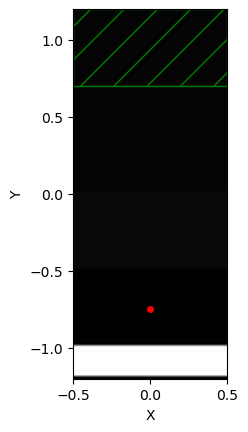

In [3]:
sim.plot2D()

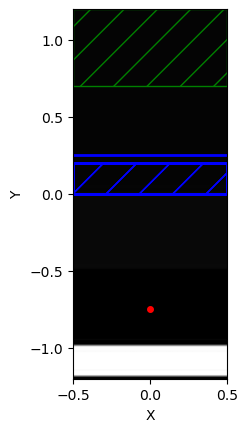

In [4]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields[:,:]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)
opt.plot2D(True)

In [5]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [6]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [7]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    print("FoM: {}".format(np.real(f0)))
    print("Gradient: {}".format(np.real(dJ_du)))

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  # backprop

    evaluation_history.append(np.real(f0))

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [8]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 10
update_factor = 20
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...


Starting adjoint run...


Calculating gradient...
FoM: 0.3660139216366777
Gradient: [-1.34553159e-03 -2.50588074e-03 -1.13603543e-03  9.27063542e-05
  7.74632154e-04  6.99187698e-04 -1.89197948e-04 -1.04750980e-03
 -1.60362002e-03 -1.66047614e-03 -1.70788853e-03 -1.16894368e-03
 -2.14415667e-03 -8.76664859e-04  2.30226807e-04  8.09720756e-04
  6.80454878e-04 -1.90353795e-04 -9.98894063e-04 -1.50767645e-03
 -1.54552728e-03 -1.57878057e-03 -8.58875279e-04 -1.51416297e-03
 -4.39104832e-04  4.45158141e-04  8.42793614e-04  6.23100463e-04
 -2.02484302e-04 -9.12811707e-04 -1.33075469e-03 -1.33102005e-03
 -1.32529832e-03 -4.89978957e-04 -7.76634125e-04  4.00101757e-05
  6.39718616e-04  8.17183815e-04  5.00756305e-04 -2.37160725e-04
 -8.05581077e-04 -1.09870116e-03 -1.04799369e-03 -9.83642482e-04
 -1.48596393e-04 -1.14920660e-04  4.11730014e-04  7.15217981e-04
  6.84491761e-04  3.00840664e-04 -2.96095590e-04 -6.90011664e-04
 -8.41201615e-04 -7.37972177e-04 -6.16140499e-04  8.98234804e-05
  3.15153756e-04  5.61469743e-04

Calculating gradient...
FoM: 0.3662552748410162
Gradient: [-1.36018594e-03 -2.53962877e-03 -1.17053268e-03  6.20236461e-05
  7.52001238e-04  6.88204908e-04 -1.84958000e-04 -1.03158591e-03
 -1.57838978e-03 -1.62924876e-03 -1.65557111e-03 -1.18126392e-03
 -2.17243457e-03 -9.05324351e-04  2.04994340e-04  7.91376586e-04
  6.71925622e-04 -1.86365430e-04 -9.85353345e-04 -1.48659249e-03
 -1.51964533e-03 -1.53569387e-03 -8.67193483e-04 -1.53309251e-03
 -4.57871002e-04  4.29060675e-04  8.31510844e-04  6.18410456e-04
 -1.99240944e-04 -9.03602062e-04 -1.31691739e-03 -1.31430802e-03
 -1.29777714e-03 -4.93751165e-04 -7.85015041e-04  3.22161195e-05
  6.33517295e-04  8.13259247e-04  4.99575350e-04 -2.35500919e-04
 -8.01879879e-04 -1.09344706e-03 -1.04175719e-03 -9.73331669e-04
 -1.48505970e-04 -1.14459088e-04  4.12804036e-04  7.16604059e-04
  6.85680397e-04  3.01161119e-04 -2.97083171e-04 -6.92056382e-04
 -8.43916415e-04 -7.40827354e-04 -6.19818693e-04  9.21517613e-05
  3.20552948e-04  5.66981830e-04

Calculating gradient...
FoM: 0.36862743131858483
Gradient: [-1.49210296e-03 -2.84247371e-03 -1.47764147e-03 -2.08524164e-04
  5.55558532e-04  5.98115276e-04 -1.39548558e-04 -8.82378677e-04
 -1.34700699e-03 -1.34532887e-03 -1.18214558e-03 -1.29228756e-03
 -2.42643584e-03 -1.16062693e-03 -1.75573634e-05  6.32176338e-04
  6.02204862e-04 -1.44791558e-04 -8.59034509e-04 -1.29374044e-03
 -1.28478227e-03 -1.14634638e-03 -9.42337118e-04 -1.70348645e-03
 -6.25232787e-04  2.87084288e-04  7.33755012e-04  5.80545676e-04
 -1.66818884e-04 -8.18467971e-04 -1.19110371e-03 -1.16335134e-03
 -1.04990288e-03 -5.28027054e-04 -8.60804195e-04 -3.73366362e-05
  5.79081794e-04  7.79711979e-04  4.90730038e-04 -2.19583105e-04
 -7.68258182e-04 -1.04637290e-03 -9.86099900e-04 -8.81191182e-04
 -1.47905846e-04 -1.10586843e-04  4.22680667e-04  7.29627661e-04
  6.96987041e-04  3.04403466e-04 -3.06096790e-04 -7.10905984e-04
 -8.68918902e-04 -7.66989737e-04 -6.53119183e-04  1.13137517e-04
  3.69333924e-04  6.17060717e-0

Calculating gradient...
FoM: 0.3944794763795068
Gradient: [-1.34115343e-03 -2.51770939e-03 -1.22177352e-03 -1.25221418e-04
  3.54598729e-04 -1.08715981e-04 -1.23260354e-03 -2.29047119e-03
 -2.91339040e-03 -2.88208666e-03 -3.15893320e-03 -1.18669544e-03
 -2.19629555e-03 -9.74070499e-04  4.01526670e-05  4.62712208e-04
  1.07395690e-05 -1.06604405e-03 -2.05090306e-03 -2.62119154e-03
 -2.58435975e-03 -2.80424440e-03 -9.07341371e-04 -1.61906122e-03
 -5.40501660e-04  3.16643230e-04  6.31719922e-04  1.98400620e-04
 -7.86665192e-04 -1.63646992e-03 -2.10990248e-03 -2.06161800e-03
 -2.17648838e-03 -5.57361555e-04 -9.05446596e-04 -3.09052157e-05
  6.11276469e-04  7.84118475e-04  3.72330708e-04 -4.81343233e-04
 -1.15409906e-03 -1.50286093e-03 -1.44034555e-03 -1.43990420e-03
 -2.06046181e-04 -2.05671188e-04  4.22967118e-04  8.20252395e-04
  8.40894667e-04  4.53542623e-04 -2.36721872e-04 -7.16206460e-04
 -9.35002370e-04 -8.63486780e-04 -7.90375566e-04  7.62143638e-05
  3.31564022e-04  7.01530797e-04

Calculating gradient...
FoM: 0.8093024320257078
Gradient: [-1.30401733e-03 -2.00407389e-03  3.68343683e-04  2.28202091e-03
  3.24179478e-03  3.37855161e-03  2.44641034e-03  2.62624218e-03
  4.08532546e-03  6.97625970e-03  1.84426311e-02 -1.60819219e-03
 -2.77563840e-03 -6.41102054e-04  1.02066280e-03  1.74423208e-03
  1.50420276e-03  6.15799444e-04  6.32967736e-04  1.85681798e-03
  4.42524979e-03  1.37166912e-02 -1.88032023e-03 -3.49993308e-03
 -1.67504713e-03 -3.55642963e-04  2.68815437e-05 -7.54145161e-04
 -1.69566612e-03 -2.00620304e-03 -1.24523423e-03  7.06114436e-04
  6.53803420e-03 -1.62801133e-03 -2.97723480e-03 -1.29302392e-03
 -1.84745863e-04 -7.21448268e-05 -1.23987838e-03 -2.52751261e-03
 -3.31847154e-03 -3.21810422e-03 -2.12307250e-03  2.63829781e-04
 -4.93148078e-04 -3.40832871e-04  1.52475316e-03  2.67518730e-03
  2.69226958e-03  1.54111143e-03 -4.65709453e-04 -1.82468962e-03
 -2.49962676e-03 -2.39603421e-03 -2.29216707e-03  1.47080080e-03
  4.25970633e-03  6.55011307e-03

Calculating gradient...
FoM: 0.47711819305804926
Gradient: [-9.09744341e-04 -1.37122298e-03  3.49008994e-04  1.68217530e-03
  2.02031248e-03  7.96228906e-04 -1.72703295e-03 -3.98505010e-03
 -5.54154526e-03 -5.97381914e-03 -7.74484466e-03 -8.39291901e-04
 -1.25988768e-03  3.35332677e-04  1.56038547e-03  1.89170892e-03
  8.28319574e-04 -1.37927199e-03 -3.32959726e-03 -4.67578146e-03
 -5.05800105e-03 -6.52390171e-03 -7.08231430e-04 -1.04966808e-03
  3.24532812e-04  1.36392962e-03  1.65722844e-03  8.38828219e-04
 -8.66347748e-04 -2.32061847e-03 -3.29893595e-03 -3.55540549e-03
 -4.46927610e-03 -5.31856460e-04 -7.61862470e-04  3.32074719e-04
  1.14418820e-03  1.36047147e-03  7.83848603e-04 -4.12545006e-04
 -1.34882261e-03 -1.91164381e-03 -1.97650053e-03 -2.24284129e-03
 -3.31231081e-04 -4.32172900e-04  3.47999901e-04  9.00851898e-04
  1.01226395e-03  6.24105049e-04 -1.30736923e-04 -6.22528635e-04
 -8.26893750e-04 -7.18991701e-04 -4.62683132e-04 -1.31970864e-04
 -1.09460337e-04  3.43859247e-0

Calculating gradient...
FoM: 0.5294315749930354
Gradient: [-4.04271466e-04 -2.86564126e-04  1.25351435e-03  2.25952923e-03
  2.07606571e-03 -4.81010992e-05 -3.31713447e-03 -6.24550471e-03
 -8.38272797e-03 -9.20439459e-03 -1.28261205e-02 -4.16993703e-04
 -3.45343526e-04  1.12660441e-03  2.11731568e-03  2.03043401e-03
  2.21739687e-04 -2.64680324e-03 -5.18658422e-03 -7.04046575e-03
 -7.76346621e-03 -1.08042725e-02 -4.29957448e-04 -4.31023712e-04
  9.10286198e-04  1.85575429e-03  1.90013329e-03  5.88400353e-04
 -1.63515407e-03 -3.54447145e-03 -4.90729299e-03 -5.41695647e-03
 -7.43389869e-03 -4.23058120e-04 -4.97202329e-04  6.49358650e-04
  1.49810152e-03  1.64633071e-03  8.40262252e-04 -6.93605910e-04
 -1.92419203e-03 -2.73692698e-03 -2.96383864e-03 -3.82747138e-03
 -3.74346731e-04 -4.94754089e-04  3.85988547e-04  1.05851692e-03
  1.23940997e-03  8.33552414e-04 -7.70991881e-05 -7.14285055e-04
 -1.05265184e-03 -1.03660196e-03 -9.92542820e-04 -2.65346487e-04
 -3.76217973e-04  1.79418600e-04

Calculating gradient...
FoM: 0.743831524442268
Gradient: [-3.25977282e-03 -8.13181446e-03 -1.05348367e-02 -1.39343769e-02
 -1.84963077e-02 -2.65710679e-02 -2.88013775e-02 -3.20903890e-02
 -3.37566883e-02 -3.31680613e-02 -4.53319164e-02 -2.63850562e-03
 -6.42775753e-03 -7.97161307e-03 -1.03790361e-02 -1.39131766e-02
 -2.05680280e-02 -2.28187575e-02 -2.58476064e-02 -2.74949754e-02
 -2.71942628e-02 -3.72644717e-02 -1.70567858e-03 -3.86268328e-03
 -4.09302638e-03 -4.96719711e-03 -6.90571699e-03 -1.12727891e-02
 -1.35614781e-02 -1.61305099e-02 -1.76604258e-02 -1.77121119e-02
 -2.42957717e-02 -9.27839579e-04 -1.70854565e-03 -7.89412171e-04
 -2.83093149e-04 -7.39046350e-04 -2.84750107e-03 -4.98128481e-03
 -6.93280102e-03 -8.16748846e-03 -8.39444824e-03 -1.13282546e-02
 -7.05437592e-04 -1.07685418e-03  2.47815912e-04  1.35710161e-03
  1.72192806e-03  1.07595325e-03 -4.39559240e-04 -1.61400362e-03
 -2.31575703e-03 -2.39796627e-03 -2.73203829e-03 -1.16264407e-03
 -2.34929322e-03 -1.63401582e-03 

Calculating gradient...
FoM: 3.7460467247334974
Gradient: [-4.34196940e-02 -6.45304465e-02  2.97879077e-02  1.42472603e-01
  2.60212762e-01  4.06334543e-01  4.30876251e-01  4.60007008e-01
  4.68709487e-01  4.58359272e-01  6.55849184e-01 -3.89806655e-02
 -5.99527537e-02  1.87521339e-02  1.12026667e-01  2.08695781e-01
  3.27857211e-01  3.47442312e-01  3.70757933e-01  3.77687510e-01
  3.69208179e-01  5.27528199e-01 -2.98594502e-02 -4.83788819e-02
  4.45517968e-03  6.54525878e-02  1.27151505e-01  2.01645494e-01
  2.13498256e-01  2.27751865e-01  2.32248855e-01  2.27331925e-01
  3.24719744e-01 -1.62283343e-02 -2.71523692e-02 -1.72621275e-03
  2.48047803e-02  4.93578086e-02  7.71194796e-02  8.05751809e-02
  8.60601524e-02  8.89322309e-02  8.87626749e-02  1.29535407e-01
  3.29333053e-04  3.21534329e-03  8.49146119e-03  9.25828822e-03
  6.22486851e-03  1.00813628e-03 -2.83097805e-03 -2.74200856e-03
  3.28952111e-04  5.11964556e-03  1.65591044e-02  1.61056851e-02
  3.61924937e-02  3.39198332e-02

Calculating gradient...
FoM: 0.45586194674999153
Gradient: [-2.35429823e-03 -4.73551067e-03 -3.09611283e-03 -1.06580719e-03
  7.26481390e-04  1.74939727e-03  1.12305351e-03  8.10237899e-05
 -8.74481763e-04 -1.33662794e-03 -1.66658965e-03 -2.04127920e-03
 -4.06313490e-03 -2.53216201e-03 -6.85649861e-04  8.84835102e-04
  1.70791225e-03  1.00188087e-03 -1.44278424e-05 -9.02152222e-04
 -1.29971980e-03 -1.58066400e-03 -1.50064692e-03 -2.90663913e-03
 -1.58227591e-03 -9.04142264e-05  1.07203214e-03  1.53695907e-03
  7.36821885e-04 -2.00434653e-04 -9.44740160e-04 -1.21735500e-03
 -1.38898132e-03 -8.82559029e-04 -1.60656112e-03 -5.78735260e-04
  4.45808294e-04  1.09804894e-03  1.14265504e-03  3.22765525e-04
 -4.42764995e-04 -9.64051110e-04 -1.07067238e-03 -1.08835230e-03
 -3.42769408e-04 -5.14972172e-04  1.39670972e-04  6.56891491e-04
  8.15151807e-04  5.08242943e-04 -1.82477276e-04 -6.83455223e-04
 -9.26631139e-04 -8.53040006e-04 -7.03259172e-04 -4.89765415e-06
  9.99796351e-05  3.44842399e-0

Calculating gradient...
FoM: 0.490858695903499
Gradient: [-2.44955412e-03 -4.83591375e-03 -2.93731380e-03 -7.97567456e-04
  9.92256502e-04  1.91289405e-03  1.09596268e-03 -9.79709584e-05
 -1.19834274e-03 -1.79800992e-03 -2.58961810e-03 -2.14861656e-03
 -4.20344912e-03 -2.44264269e-03 -4.99968438e-04  1.07138461e-03
  1.80469810e-03  9.38027665e-04 -2.07593891e-04 -1.21568012e-03
 -1.72610128e-03 -2.40722624e-03 -1.62135151e-03 -3.10055046e-03
 -1.59734116e-03 -2.21420855e-05  1.14905659e-03  1.54353577e-03
  6.31677905e-04 -3.99597223e-04 -1.22690406e-03 -1.57482706e-03
 -2.04452579e-03 -9.97540099e-04 -1.81150435e-03 -6.55873715e-04
  4.41875915e-04  1.11202560e-03  1.11004434e-03  2.18584963e-04
 -6.12366454e-04 -1.18434978e-03 -1.33101796e-03 -1.53170248e-03
 -4.19087512e-04 -6.46747311e-04  1.06011045e-04  6.90057583e-04
  8.72373649e-04  5.40089705e-04 -2.16711826e-04 -7.74806219e-04
 -1.05457056e-03 -1.00005763e-03 -9.30091749e-04 -1.15899255e-05
  1.22305366e-04  4.60457744e-04 

Calculating gradient...
FoM: 0.6226230301807514
Gradient: [-7.38426450e-04 -1.62547193e-03 -1.80182483e-03 -3.00186349e-03
 -5.64898580e-03 -1.09070763e-02 -1.40631837e-02 -1.69218913e-02
 -1.82680027e-02 -1.77958227e-02 -2.32922546e-02 -6.52029819e-04
 -1.32742070e-03 -1.18846658e-03 -1.93960720e-03 -4.01924852e-03
 -8.46584859e-03 -1.13704017e-02 -1.39512683e-02 -1.51924055e-02
 -1.48207053e-02 -1.93222252e-02 -5.46208433e-04 -9.37887756e-04
 -3.29777453e-04 -3.84879939e-04 -1.55223926e-03 -4.58736396e-03
 -7.05724867e-03 -9.14516371e-03 -1.01920908e-02 -9.98058473e-03
 -1.28459996e-02 -5.13789501e-04 -7.52809425e-04  2.25774370e-04
  7.93697351e-04  5.16885075e-04 -1.02132864e-03 -2.84551718e-03
 -4.29536193e-03 -5.06208903e-03 -4.99361758e-03 -6.17253021e-03
 -6.11194950e-04 -9.77135574e-04  4.76758013e-05  8.82979513e-04
  1.16166300e-03  7.08351988e-04 -3.37812109e-04 -1.11811200e-03
 -1.52430410e-03 -1.47634238e-03 -1.46380999e-03 -8.06748831e-04
 -1.56755715e-03 -9.03233460e-04

Calculating gradient...
FoM: 1.66878112505451
Gradient: [-5.69545378e-02 -1.46066520e-01 -1.95942972e-01 -2.51812939e-01
 -3.05685391e-01 -3.77206113e-01 -3.48299844e-01 -3.41378171e-01
 -3.23865908e-01 -2.96141471e-01 -3.89855440e-01 -4.44475862e-02
 -1.13650136e-01 -1.51741668e-01 -1.94802993e-01 -2.36742408e-01
 -2.94357046e-01 -2.72723296e-01 -2.68299395e-01 -2.55170935e-01
 -2.33471129e-01 -3.06939541e-01 -2.53672966e-02 -6.41426118e-02
 -8.40914549e-02 -1.07404798e-01 -1.31050818e-01 -1.65810997e-01
 -1.56319521e-01 -1.55833117e-01 -1.49495964e-01 -1.37156588e-01
 -1.79550236e-01 -8.94583593e-03 -2.14332469e-02 -2.54424738e-02
 -3.12852823e-02 -3.88558884e-02 -5.23517104e-02 -5.28945019e-02
 -5.53870309e-02 -5.48092729e-02 -5.08141404e-02 -6.54715970e-02
 -3.56382982e-03 -7.29001237e-03 -5.43930071e-03 -4.08825945e-03
 -4.29798826e-03 -7.47036978e-03 -1.00366304e-02 -1.23451012e-02
 -1.31660866e-02 -1.22298078e-02 -1.43288845e-02 -1.25270268e-02
 -3.03597756e-02 -3.57917271e-02 -

Calculating gradient...
FoM: 4.339953511304986
Gradient: [-1.30132352e-01 -2.76793434e-01 -2.27768345e-01 -1.57611623e-01
 -7.28162338e-02  2.15350974e-02  8.54054340e-02  1.16135400e-01
  1.25295731e-01  1.16980547e-01  1.41291413e-01 -1.05834507e-01
 -2.23137875e-01 -1.77959446e-01 -1.15612715e-01 -4.24078676e-02
  3.80245525e-02  8.66667715e-02  1.09240900e-01  1.13790034e-01
  1.03913287e-01  1.22727416e-01 -6.65100833e-02 -1.37149301e-01
 -1.00579740e-01 -5.35973664e-02 -1.77637929e-03  5.36209336e-02
  7.90147534e-02  8.95774202e-02  8.83244048e-02  7.78576000e-02
  8.88566519e-02 -2.72155125e-02 -5.33012784e-02 -3.11415045e-02
 -6.04256297e-03  1.85583162e-02  4.32609599e-02  4.86662178e-02
  4.99351962e-02  4.67332580e-02  4.01575697e-02  4.53592736e-02
 -3.14453463e-03 -6.01710528e-03 -3.89941008e-03 -4.15577992e-03
 -6.24873072e-03 -1.05784050e-02 -1.17330350e-02 -1.12990396e-02
 -8.61540425e-03 -4.51419389e-03  8.06978890e-04 -3.49800923e-03
 -1.51783658e-02 -3.56627876e-02 

Calculating gradient...
FoM: 0.5678796770162458
Gradient: [-2.15804054e-03 -4.57587058e-03 -3.83633881e-03 -3.16169675e-03
 -2.80709268e-03 -3.27481010e-03 -3.37058143e-03 -3.57490470e-03
 -3.21365601e-03 -2.08270774e-03  2.90590791e-04 -2.01209894e-03
 -4.22923799e-03 -3.44514933e-03 -2.74200614e-03 -2.38420195e-03
 -2.84585979e-03 -3.04429435e-03 -3.33342044e-03 -3.09995030e-03
 -2.15402743e-03 -2.78049742e-04 -1.68800036e-03 -3.46418859e-03
 -2.59361388e-03 -1.83871056e-03 -1.48208888e-03 -1.92436331e-03
 -2.34303619e-03 -2.78913572e-03 -2.78268646e-03 -2.15949351e-03
 -1.06971788e-03 -1.15047274e-03 -2.20712295e-03 -1.22697541e-03
 -4.26236439e-04 -1.03773487e-04 -5.24791767e-04 -1.25956023e-03
 -1.90197689e-03 -2.17078974e-03 -1.93393920e-03 -1.64644416e-03
 -4.10902439e-04 -5.03215832e-04  5.54145082e-04  1.33340489e-03
  1.55499931e-03  1.14927715e-03  7.09161983e-05 -7.56445215e-04
 -1.28488218e-03 -1.41642042e-03 -1.72870838e-03  4.19356219e-04
  1.36412241e-03  2.38620111e-03

Calculating gradient...
FoM: 1.7528007431660384
Gradient: [ 2.84108742e-02  7.40352478e-02  1.01468585e-01  1.29891278e-01
  1.55343116e-01  1.92382510e-01  1.83015655e-01  1.90840442e-01
  1.99517994e-01  2.07872926e-01  3.31747505e-01  2.01393061e-02
  5.31817208e-02  7.44339852e-02  9.61271239e-02  1.15232612e-01
  1.43079418e-01  1.36397039e-01  1.43290252e-01  1.51503290e-01
  1.59914366e-01  2.59077374e-01  8.22382179e-03  2.31024500e-02
  3.53150715e-02  4.70741113e-02  5.67286845e-02  7.04143824e-02
  6.75575079e-02  7.25828793e-02  7.94881243e-02  8.73435670e-02
  1.47999397e-01 -2.40305611e-04  1.65088089e-03  7.11396417e-03
  1.11364162e-02  1.30775405e-02  1.46492700e-02  1.32195033e-02
  1.51163033e-02  1.91650910e-02  2.47813499e-02  4.92435126e-02
  8.90712073e-04  4.28888849e-03  9.66780456e-03  1.24364713e-02
  1.19241914e-02  9.20108656e-03  3.91863142e-03  1.24679852e-03
  3.76574229e-04  1.19824718e-03  5.40748729e-03  1.33308705e-02
  3.52179547e-02  4.79914117e-02

Calculating gradient...
FoM: 4.637964629173713
Gradient: [-3.81051510e-02 -3.71204547e-02  1.01115229e-01  2.66193627e-01
  4.38725294e-01  6.56376372e-01  6.82502169e-01  7.21383977e-01
  7.29557640e-01  7.08820834e-01  1.00629038e+00 -3.66645053e-02
 -4.22672694e-02  7.18703842e-02  2.07351516e-01  3.48106925e-01
  5.25122982e-01  5.46378320e-01  5.77762928e-01  5.84485167e-01
  5.67778793e-01  8.05095695e-01 -3.12727637e-02 -4.38110354e-02
  3.09484243e-02  1.17806704e-01  2.06358371e-01  3.16033429e-01
  3.30051920e-01  3.49789225e-01  3.54702720e-01  3.45169156e-01
  4.89377288e-01 -1.87439438e-02 -2.95885689e-02  4.73248844e-03
  4.10533918e-02  7.54081027e-02  1.15799310e-01  1.20777394e-01
  1.28907744e-01  1.32749964e-01  1.31661019e-01  1.90291400e-01
  1.88269088e-03  7.47113193e-03  1.42972607e-02  1.50181722e-02
  1.08182018e-02  4.26932133e-03 -9.26402873e-04 -7.40656064e-04
  3.19786293e-03  9.20683685e-03  2.48035769e-02  2.67872785e-02
  6.14498256e-02  6.14815774e-02 

Calculating gradient...
FoM: 5.052598619299255
Gradient: [-1.79208911e-01 -3.92171664e-01 -3.55783106e-01 -2.95744827e-01
 -2.15608391e-01 -1.30393774e-01 -4.08731367e-02 -2.49238412e-03
  1.19515088e-02  7.56284188e-03 -2.06617300e-02 -1.44509311e-01
 -3.13493308e-01 -2.76696140e-01 -2.20573561e-01 -1.49365646e-01
 -7.47731151e-02 -6.56761913e-03  2.13328269e-02  2.90006025e-02
  2.10150769e-02 -1.98945538e-03 -8.90044657e-02 -1.88827997e-01
 -1.54722798e-01 -1.08749362e-01 -5.57125404e-02 -1.58439503e-03
  3.38564327e-02  4.63562544e-02  4.53116127e-02  3.41475036e-02
  2.00488973e-02 -3.50143553e-02 -7.04989507e-02 -4.72447601e-02
 -2.05025293e-02  6.18554182e-03  3.19459898e-02  3.95925791e-02
  4.04907294e-02  3.60491376e-02  2.78470461e-02  2.35576977e-02
 -4.62638953e-03 -9.74984614e-03 -8.70208891e-03 -1.00143549e-02
 -1.29159814e-02 -1.85844515e-02 -1.90743427e-02 -1.83731024e-02
 -1.50604527e-02 -1.00270206e-02 -5.68775028e-03 -1.03260331e-02
 -3.41279709e-02 -6.40474202e-02 

Calculating gradient...
FoM: 5.411475880090286
Gradient: [-7.76199097e-02 -1.22971394e-01  2.55528477e-02  2.08255978e-01
  4.04912958e-01  6.49916025e-01  6.97307842e-01  7.44875949e-01
  7.53524042e-01  7.26477176e-01  1.01275383e+00 -6.84109796e-02
 -1.10707148e-01  1.31832626e-02  1.64486554e-01  3.26164599e-01
  5.26891297e-01  5.64312596e-01  6.01963799e-01  6.08036904e-01
  5.85021719e-01  8.12635342e-01 -5.05995639e-02 -8.46702594e-02
 -1.74355864e-03  9.71824417e-02  2.00653424e-01  3.27048860e-01
  3.49836606e-01  3.72431145e-01  3.75478036e-01  3.60293294e-01
  4.97590688e-01 -2.59920733e-02 -4.42807144e-02 -5.18493019e-03
  3.74289699e-02  7.89394812e-02  1.27292748e-01  1.34832261e-01
  1.43389230e-01  1.45492659e-01  1.40952354e-01  1.96239108e-01
  1.42407985e-03  6.15081616e-03  1.21418523e-02  1.18695657e-02
  6.95391210e-03 -2.99465690e-04 -4.77215604e-03 -3.96229663e-03
  8.02416132e-04  7.65194589e-03  2.36106345e-02  2.49943815e-02
  5.45053044e-02  4.66139558e-02 

Calculating gradient...
FoM: 5.744537244250478
Gradient: [-1.56625170e-01 -3.18867597e-01 -2.19283801e-01 -8.62351624e-02
  6.79937849e-02  2.51373990e-01  3.35443921e-01  3.85527724e-01
  3.98914121e-01  3.80545396e-01  5.05724692e-01 -1.29162294e-01
 -2.61040138e-01 -1.73892087e-01 -5.96141349e-02  7.06654624e-02
  2.24220920e-01  2.89119466e-01  3.27251864e-01  3.35016068e-01
  3.16634525e-01  4.15805713e-01 -8.36905926e-02 -1.66107688e-01
 -1.01839239e-01 -2.12434456e-02  6.69905339e-02  1.68598559e-01
  2.04457281e-01  2.24792080e-01  2.25528977e-01  2.09539840e-01
  2.69215793e-01 -3.57817513e-02 -6.80937679e-02 -3.35350691e-02
  5.36935698e-03  4.42109012e-02  8.66315687e-02  9.63565687e-02
  1.01874000e-01  1.00138579e-01  9.20478239e-02  1.16955332e-01
 -1.93901837e-03 -2.74721631e-03  1.68696503e-04 -1.52445913e-03
 -6.24305375e-03 -1.35822589e-02 -1.55515824e-02 -1.42466619e-02
 -9.39216762e-03 -2.56459886e-03  8.19052710e-03  6.26938167e-03
  5.74685453e-03 -1.87923065e-02 

Calculating gradient...
FoM: 5.744537244250478
Gradient: [-1.56625170e-01 -3.18867597e-01 -2.19283801e-01 -8.62351624e-02
  6.79937849e-02  2.51373990e-01  3.35443921e-01  3.85527724e-01
  3.98914121e-01  3.80545396e-01  5.05724692e-01 -1.29162294e-01
 -2.61040138e-01 -1.73892087e-01 -5.96141349e-02  7.06654624e-02
  2.24220920e-01  2.89119466e-01  3.27251864e-01  3.35016068e-01
  3.16634525e-01  4.15805713e-01 -8.36905926e-02 -1.66107688e-01
 -1.01839239e-01 -2.12434456e-02  6.69905339e-02  1.68598559e-01
  2.04457281e-01  2.24792080e-01  2.25528977e-01  2.09539840e-01
  2.69215793e-01 -3.57817513e-02 -6.80937679e-02 -3.35350691e-02
  5.36935698e-03  4.42109012e-02  8.66315687e-02  9.63565687e-02
  1.01874000e-01  1.00138579e-01  9.20478239e-02  1.16955332e-01
 -1.93901837e-03 -2.74721631e-03  1.68696503e-04 -1.52445913e-03
 -6.24305375e-03 -1.35822589e-02 -1.55515824e-02 -1.42466619e-02
 -9.39216762e-03 -2.56459886e-03  8.19052710e-03  6.26938167e-03
  5.74685453e-03 -1.87923065e-02 

Calculating gradient...
FoM: 6.373981346829078
Gradient: [ 2.53954600e-01  7.00126298e-01  1.06307290e+00  1.48678129e+00
  1.92273675e+00  2.53118459e+00  2.47893099e+00  2.56513283e+00
  2.58258464e+00  2.52515262e+00  3.64096299e+00  1.81945659e-01
  5.09512076e-01  7.91928173e-01  1.12192456e+00  1.46176807e+00
  1.94142608e+00  1.90871478e+00  1.98433480e+00  2.00732327e+00
  1.97098934e+00  2.85376252e+00  7.90779955e-02  2.34725064e-01
  3.94665819e-01  5.80878867e-01  7.73018244e-01  1.04773467e+00
  1.04666066e+00  1.10411841e+00  1.13293334e+00  1.12661659e+00
  1.65118619e+00  7.98010550e-03  3.83684002e-02  9.41531677e-02
  1.53952981e-01  2.13515136e-01  2.99570153e-01  3.10979784e-01
  3.41866143e-01  3.66611657e-01  3.79983096e-01  5.79519683e-01
  2.18504659e-02  5.96639773e-02  8.30042056e-02  9.02951892e-02
  8.31207062e-02  7.39117397e-02  5.20874955e-02  4.69341388e-02
  4.85499596e-02  5.39519171e-02  9.28553549e-02  1.33537676e-01
  3.33806299e-01  4.12769784e-01 

Calculating gradient...
FoM: 0.5787214793009947
Gradient: [ 3.06021757e-04  8.87542391e-04  1.12161778e-03  2.16194331e-04
 -2.43767145e-03 -8.18837218e-03 -1.28441163e-02 -1.69238099e-02
 -1.93715973e-02 -1.97156807e-02 -2.69320518e-02  1.96607235e-04
  7.11738738e-04  1.17925798e-03  6.70085989e-04 -1.40897056e-03
 -6.20616509e-03 -1.03220833e-02 -1.38896918e-02 -1.60399521e-02
 -1.63574952e-02 -2.22709182e-02 -1.95645009e-05  3.23726886e-04
  1.12992358e-03  1.23272276e-03  7.54420781e-05 -3.14337638e-03
 -6.34387076e-03 -9.04738656e-03 -1.06862799e-02 -1.09413403e-02
 -1.47227647e-02 -3.21812272e-04 -2.94470893e-04  7.60755293e-04
  1.41751059e-03  1.18319671e-03 -3.83252642e-04 -2.49222645e-03
 -4.20739885e-03 -5.24684896e-03 -5.40144852e-03 -6.99079198e-03
 -6.49584976e-04 -1.06141798e-03 -1.37499160e-05  9.00099561e-04
  1.28449011e-03  9.45312835e-04 -1.04604005e-04 -9.25303618e-04
 -1.40257574e-03 -1.42974828e-03 -1.48423328e-03 -8.93609373e-04
 -1.74575167e-03 -1.01553493e-03

Calculating gradient...
FoM: 0.8452274928434392
Gradient: [-2.19771684e-02 -5.54516408e-02 -7.22166709e-02 -9.10780591e-02
 -1.08716978e-01 -1.31264565e-01 -1.16521021e-01 -1.08329855e-01
 -9.57795788e-02 -7.99875757e-02 -9.13514726e-02 -1.76578867e-02
 -4.42909528e-02 -5.70837081e-02 -7.16461076e-02 -8.53477857e-02
 -1.03332650e-01 -9.16086220e-02 -8.50583817e-02 -7.49371752e-02
 -6.21284638e-02 -6.98691202e-02 -1.08468948e-02 -2.67182806e-02
 -3.33291733e-02 -4.12483686e-02 -4.90118940e-02 -5.98347479e-02
 -5.33869616e-02 -4.96298639e-02 -4.34348918e-02 -3.53557486e-02
 -3.80254763e-02 -4.39839475e-03 -1.01576712e-02 -1.11529467e-02
 -1.31484039e-02 -1.58761929e-02 -2.04985850e-02 -1.93083387e-02
 -1.84613819e-02 -1.61675215e-02 -1.26723863e-02 -1.19606541e-02
 -9.86997935e-04 -1.58165801e-03 -1.22075026e-04  4.25368551e-04
 -2.74513595e-04 -2.45923734e-03 -4.24429400e-03 -5.34444142e-03
 -5.48026419e-03 -4.69597354e-03 -4.65682054e-03 -1.91940264e-03
 -4.37550975e-03 -4.73466986e-03

Calculating gradient...
FoM: 9.101031048518838
Gradient: [-5.52768813e-01 -1.29373194e+00 -1.42253594e+00 -1.53013942e+00
 -1.58457303e+00 -1.68581580e+00 -1.38144855e+00 -1.26139894e+00
 -1.15702750e+00 -1.06461843e+00 -1.48444375e+00 -4.37617337e-01
 -1.01758495e+00 -1.10133755e+00 -1.16683495e+00 -1.19071347e+00
 -1.25351973e+00 -1.01690535e+00 -9.26174031e-01 -8.51589176e-01
 -7.88790094e-01 -1.11353683e+00 -2.57613329e-01 -5.88762398e-01
 -6.10221154e-01 -6.19859410e-01 -6.07534898e-01 -6.18679021e-01
 -4.90695796e-01 -4.44929736e-01 -4.12950648e-01 -3.90599005e-01
 -5.71328394e-01 -9.18350735e-02 -2.01109596e-01 -1.85788712e-01
 -1.68240177e-01 -1.47754646e-01 -1.36635031e-01 -1.02645278e-01
 -9.31520051e-02 -8.99723029e-02 -9.09849129e-02 -1.46534559e-01
 -1.48394267e-02 -3.62937128e-02 -4.56192762e-02 -5.98263109e-02
 -7.50469433e-02 -9.79659935e-02 -9.31797245e-02 -8.91974392e-02
 -7.83092666e-02 -6.26214828e-02 -6.52162686e-02 -6.25993954e-02
 -1.78136164e-01 -2.78312478e-01 

Calculating gradient...
FoM: 9.313764387245264
Gradient: [ 0.04249906  0.23448215  0.63235994  1.11843708  1.64259545  2.34570041
  2.39792861  2.51817755  2.53260488  2.44271416  3.41906379  0.01396992
  0.14280183  0.46184798  0.85137459  1.27098839  1.83588607  1.8827147
  1.98210713  1.99705282  1.92769193  2.69721222 -0.02040428  0.02226277
  0.21697177  0.45288527  0.70599594  1.04606543  1.0868866   1.15379865
  1.16971991  1.13322904  1.58674528 -0.02730602 -0.03359976  0.04374958
  0.13091066  0.22139025  0.34158133  0.36494873  0.39656789  0.41134926
  0.40639066  0.57740174  0.0182743   0.04869609  0.06395618  0.0626935
  0.04972894  0.03538299  0.02059931  0.02083028  0.02873143  0.04014746
  0.08011573  0.11465217  0.27255462  0.30115339  0.29488644  0.26087036
  0.23308263  0.16847957  0.14951097  0.14574223  0.15233071  0.25634702
  0.22658067  0.55125502  0.64938088  0.70465737  0.72046077  0.78478436
  0.68524916  0.66886515  0.65582035  0.64187957  0.95914721  0.30092

Calculating gradient...
FoM: 9.98290052187909
Gradient: [-2.52076218e-01 -4.99460511e-01 -2.98161167e-01 -2.72741279e-02
  2.95255685e-01  7.10985671e-01  8.94120512e-01  1.02650601e+00
  1.07797096e+00  1.05270366e+00  1.44994027e+00 -2.11875952e-01
 -4.18753336e-01 -2.47311001e-01 -1.94733790e-02  2.49025529e-01
  5.92953949e-01  7.38973857e-01  8.44007210e-01  8.82404223e-01
  8.57584467e-01  1.17271929e+00 -1.42556297e-01 -2.79700421e-01
 -1.60029870e-01 -6.54130579e-03  1.69461801e-01  3.90957839e-01
  4.79571753e-01  5.42624351e-01  5.62982087e-01  5.42601467e-01
  7.32128721e-01 -6.30925503e-02 -1.20795279e-01 -6.17908319e-02
  5.53274704e-03  7.71226122e-02  1.64282329e-01  1.96124505e-01
  2.20232457e-01  2.28671411e-01  2.21008146e-01  2.97555516e-01
  4.49358138e-03  1.27764314e-02  1.60814952e-02  6.99086397e-03
 -8.98705741e-03 -2.87055702e-02 -3.39480157e-02 -3.06915610e-02
 -1.96670972e-02 -4.62164964e-03  1.91206627e-02  4.08266594e-02
  8.09079730e-02  4.49155477e-02 -

Calculating gradient...
FoM: 10.08656937798079
Gradient: [-2.75369598e-01 -5.57849702e-01 -3.73049557e-01 -1.20109196e-01
  1.85995891e-01  5.79416943e-01  7.74906659e-01  9.10420483e-01
  9.67112953e-01  9.49058997e-01  1.30680114e+00 -2.29850015e-01
 -4.63732993e-01 -3.04817547e-01 -9.06085611e-02  1.65485311e-01
  4.92206632e-01  6.47815983e-01  7.55138203e-01  7.97349003e-01
  7.77849840e-01  1.06219830e+00 -1.52446492e-01 -3.04333008e-01
 -1.91241036e-01 -4.49315999e-02  1.24578337e-01  3.36741344e-01
  4.30386963e-01  4.94410420e-01  5.16492669e-01  4.98660270e-01
  6.70606724e-01 -6.61012973e-02 -1.28200331e-01 -7.09614618e-02
 -5.59455471e-03  6.41973954e-02  1.48586925e-01  1.81676937e-01
  2.05787057e-01  2.14405167e-01  2.07187356e-01  2.77689321e-01
  3.57017423e-03  1.03686055e-02  1.28331107e-02  3.05610508e-03
 -1.33661214e-02 -3.37808456e-02 -3.84603536e-02 -3.50322514e-02
 -2.37421034e-02 -8.32724899e-03  1.42472975e-02  3.57787692e-02
  6.77557611e-02  2.71704208e-02 

Calculating gradient...
FoM: 10.938841910833204
Gradient: [-3.39989312e-01 -7.16557611e-01 -5.67634814e-01 -3.50398371e-01
 -7.09177461e-02  2.92829181e-01  5.38515966e-01  7.01181477e-01
  7.86312139e-01  7.95783591e-01  1.11585716e+00 -2.81038707e-01
 -5.89084726e-01 -4.57564282e-01 -2.70443110e-01 -3.39135243e-02
  2.70764045e-01  4.66824821e-01  5.96061885e-01  6.60774817e-01
  6.62674997e-01  9.19163841e-01 -1.82534209e-01 -3.77454276e-01
 -2.78959962e-01 -1.46978818e-01  1.29006210e-02  2.14293996e-01
  3.32063726e-01  4.09480034e-01  4.44845522e-01  4.39168054e-01
  5.97519434e-01 -7.64740948e-02 -1.52997339e-01 -9.98199426e-02
 -3.88220811e-02  2.80787525e-02  1.09450792e-01  1.51026420e-01
  1.80251075e-01  1.93836052e-01  1.90952010e-01  2.58721260e-01
  2.99222240e-03  8.52821016e-03  9.19887874e-03 -3.47386136e-03
 -2.30747444e-02 -4.74940844e-02 -5.18248700e-02 -4.80094567e-02
 -3.54306852e-02 -1.81055079e-02  3.09983619e-03  3.08913278e-02
  5.32412515e-02  2.90982056e-03

Calculating gradient...
FoM: 1.8321008987957017
Gradient: [ 4.45595711e-02  1.23407507e-01  1.93684287e-01  2.93289981e-01
  4.18700074e-01  6.19281657e-01  6.69303871e-01  7.40720213e-01
  7.81221447e-01  7.84918084e-01  1.14097666e+00  2.83675187e-02
  8.08807592e-02  1.33209698e-01  2.09123964e-01  3.06242959e-01
  4.63345849e-01  5.07088686e-01  5.66232899e-01  6.01120431e-01
  6.06638311e-01  8.84877367e-01  6.79503700e-03  2.35954705e-02
  4.98723950e-02  9.04961480e-02  1.44903972e-01  2.34612426e-01
  2.67990163e-01  3.07269477e-01  3.32250864e-01  3.39354982e-01
  4.99302305e-01 -3.96376144e-03 -6.69159662e-03  5.11107226e-04
  1.22628868e-02  2.93059520e-02  5.85413361e-02  7.52284747e-02
  9.21729512e-02  1.04162349e-01  1.09449323e-01  1.64077765e-01
  9.07194991e-03  2.36694212e-02  3.11008850e-02  3.41648958e-02
  3.30178933e-02  3.19197258e-02  2.37450320e-02  1.99681209e-02
  1.69958455e-02  1.46818152e-02  1.93624321e-02  4.71141901e-02
  1.17970975e-01  1.46466942e-01

Calculating gradient...
FoM: 11.074436499760424
Gradient: [ 0.52620925  1.43417596  2.15001162  3.02113582  3.95821905  5.29991232
  5.25073066  5.44877402  5.45992243  5.27509786  7.42680547  0.37908668
  1.045627    1.59790492  2.27318333  3.00181888  4.05646456  4.03378246
  4.20222406  4.22521958  4.09242958  5.77325376  0.16893052  0.48603807
  0.79081091  1.16727206  1.57820743  2.18206708  2.20611717  2.32787105
  2.36567775  2.30939812  3.27724536  0.02356702  0.08724455  0.1843677
  0.30095138  0.43042315  0.62661099  0.66311828  0.72613698  0.76235295
  0.7637205   1.10583783  0.05120393  0.13217301  0.16988126  0.18196402
  0.17278869  0.16824295  0.13299314  0.12575809  0.12517383  0.1266715
  0.19330043  0.27736997  0.69013287  0.84742329  0.9378965   0.95637499
  1.00861055  0.82814627  0.75326928  0.6830522   0.61754125  0.84509979
  0.61321197  1.53430333  1.91872439  2.20255049  2.36564773  2.6715091
  2.34904307  2.23993483  2.0963728   1.92500926  2.63336837  0.89292

Calculating gradient...
FoM: 0.6694776079237357
Gradient: [-2.26948020e-03 -8.80102876e-03 -1.96755407e-02 -3.39442913e-02
 -5.05110702e-02 -7.38231954e-02 -7.61730639e-02 -7.89533572e-02
 -7.64312072e-02 -6.89080241e-02 -8.48394124e-02 -1.61335361e-03
 -6.48274208e-03 -1.49236330e-02 -2.61465210e-02 -3.93356827e-02
 -5.81879785e-02 -6.03379717e-02 -6.27305512e-02 -6.07621858e-02
 -5.46464667e-02 -6.67968472e-02 -7.63072764e-04 -3.23598474e-03
 -7.81738231e-03 -1.42012427e-02 -2.20609715e-02 -3.37445795e-02
 -3.57861836e-02 -3.76566416e-02 -3.66219769e-02 -3.27722887e-02
 -3.92914122e-02 -3.83095466e-04 -1.10427911e-03 -1.97524943e-03
 -3.66916093e-03 -6.40288519e-03 -1.11729045e-02 -1.30185436e-02
 -1.44210458e-02 -1.43635701e-02 -1.28115746e-02 -1.46694498e-02
 -9.52095989e-04 -1.68046200e-03 -4.56088740e-04  6.50623349e-04
  1.08009226e-03  5.14145315e-04 -7.86326668e-04 -1.84504545e-03
 -2.45632550e-03 -2.48454347e-03 -2.89727776e-03 -2.41597021e-03
 -5.09460939e-03 -4.08985062e-03

Calculating gradient...
FoM: 3.9068411580189233
Gradient: [-4.42260682e-01 -1.14469815e+00 -1.56347336e+00 -2.03962784e+00
 -2.50140805e+00 -3.11043658e+00 -2.85236776e+00 -2.75173089e+00
 -2.55585946e+00 -2.28287736e+00 -2.91628585e+00 -3.41445699e-01
 -8.83726381e-01 -1.20722458e+00 -1.57560374e+00 -1.93120643e+00
 -2.40543872e+00 -2.19963824e+00 -2.11838468e+00 -1.96351437e+00
 -1.74872120e+00 -2.22448359e+00 -1.88539315e-01 -4.87446425e-01
 -6.65233556e-01 -8.69462894e-01 -1.06630400e+00 -1.33269208e+00
 -1.21841480e+00 -1.17124777e+00 -1.08123133e+00 -9.56210903e-01
 -1.20186305e+00 -5.87724730e-02 -1.50215101e-01 -2.01736154e-01
 -2.64137437e-01 -3.27472223e-01 -4.16515410e-01 -3.85860509e-01
 -3.72334958e-01 -3.42102067e-01 -2.97989755e-01 -3.62171462e-01
 -1.96044414e-02 -4.68660787e-02 -5.43234606e-02 -6.23065456e-02
 -7.17053073e-02 -9.17417279e-02 -9.02790886e-02 -9.27027824e-02
 -9.00366162e-02 -8.22214786e-02 -1.05508495e-01 -9.66848121e-02
 -2.43796733e-01 -3.10994194e-01

Calculating gradient...
FoM: 12.764709051516288
Gradient: [-7.31040879e-01 -1.72356194e+00 -1.92922527e+00 -2.11032966e+00
 -2.20890951e+00 -2.33640824e+00 -1.85156197e+00 -1.59674597e+00
 -1.35348889e+00 -1.13421286e+00 -1.40645033e+00 -5.82113416e-01
 -1.36486209e+00 -1.50776715e+00 -1.62890651e+00 -1.68266563e+00
 -1.75869344e+00 -1.37146479e+00 -1.16791854e+00 -9.79133387e-01
 -8.14047090e-01 -1.00777999e+00 -3.47029976e-01 -8.02039563e-01
 -8.55812278e-01 -8.95441528e-01 -8.95277903e-01 -9.04612460e-01
 -6.78587920e-01 -5.57449258e-01 -4.51221913e-01 -3.64848221e-01
 -4.47285329e-01 -1.24971888e-01 -2.79090134e-01 -2.73803794e-01
 -2.68085953e-01 -2.52950279e-01 -2.39276517e-01 -1.64268524e-01
 -1.20362358e-01 -8.33302201e-02 -5.61223151e-02 -5.93085325e-02
 -1.05784893e-02 -2.76984988e-02 -4.21387800e-02 -6.93201029e-02
 -1.00669072e-01 -1.41852098e-01 -1.37891347e-01 -1.31539400e-01
 -1.14079395e-01 -8.97417464e-02 -9.17022254e-02 -5.20573395e-02
 -1.61239430e-01 -2.83258164e-01

Calculating gradient...
FoM: 13.127331494923014
Gradient: [-3.59364507e-01 -7.69625730e-01 -6.44077792e-01 -4.41476579e-01
 -1.55121818e-01  2.54232520e-01  5.84385588e-01  8.28401488e-01
  9.88420002e-01  1.05572331e+00  1.57435663e+00 -2.99791956e-01
 -6.39868950e-01 -5.29731266e-01 -3.56774647e-01 -1.15851345e-01
  2.24953044e-01  4.93220549e-01  6.90673314e-01  8.18071208e-01
  8.68238071e-01  1.28431892e+00 -1.98152205e-01 -4.19238830e-01
 -3.37618110e-01 -2.18116542e-01 -5.76805956e-02  1.64657997e-01
  3.32803756e-01  4.56397646e-01  5.34159190e-01  5.60967285e-01
  8.17707189e-01 -8.39269866e-02 -1.73282761e-01 -1.29595423e-01
 -7.76240766e-02 -1.41329481e-02  7.25316017e-02  1.37723096e-01
  1.88402342e-01  2.22013116e-01  2.34533964e-01  3.41264133e-01
  9.90829950e-03  2.45217007e-02  2.50133040e-02  7.84039057e-03
 -1.85383004e-02 -4.95181295e-02 -5.66785847e-02 -5.30647946e-02
 -3.94476144e-02 -2.06123644e-02  1.70413485e-03  5.63066154e-02
  1.14550516e-01  7.26085767e-02

Calculating gradient...
FoM: 13.179143590848955
Gradient: [-3.58712508e-01 -7.67942184e-01 -6.41719271e-01 -4.38089035e-01
 -1.50274791e-01  2.61772557e-01  5.93131290e-01  8.38714582e-01
  9.99908948e-01  1.06780078e+00  1.59267733e+00 -2.99374807e-01
 -6.38787353e-01 -5.28190317e-01 -3.54487842e-01 -1.12450837e-01
  2.30470415e-01  4.99796166e-01  6.98559830e-01  8.26952483e-01
  8.77631773e-01  1.29861823e+00 -1.98043047e-01 -4.18951318e-01
 -3.37173126e-01 -2.17339824e-01 -5.63124813e-02  1.67241355e-01
  3.36188152e-01  4.60673940e-01  5.39127750e-01  5.66312890e-01
  8.25915002e-01 -8.39608338e-02 -1.73376436e-01 -1.29725732e-01
 -7.77432069e-02 -1.41179861e-02  7.29354090e-02  1.38556154e-01
  1.89660348e-01  2.23613182e-01  2.36333057e-01  3.44073144e-01
  1.00809904e-02  2.49297802e-02  2.54497434e-02  8.22882932e-03
 -1.82345428e-02 -4.92600022e-02 -5.64698923e-02 -5.28517412e-02
 -3.92308092e-02 -2.04056701e-02  1.97139478e-03  5.70454462e-02
  1.16367775e-01  7.47846809e-02

Calculating gradient...
FoM: 13.776462679419426
Gradient: [-4.07941527e-01 -8.93916988e-01 -8.10016169e-01 -6.53492479e-01
 -4.09244603e-01 -5.16476151e-02  3.14271626e-01  5.76710149e-01
  7.61792558e-01  8.58026284e-01  1.32502677e+00 -3.37345828e-01
 -7.36023634e-01 -6.58272136e-01 -5.21094278e-01 -3.12462262e-01
 -1.15491658e-02  2.85537216e-01  4.97890352e-01  6.45031700e-01
  7.17646134e-01  1.09459768e+00 -2.18819182e-01 -4.72303239e-01
 -4.08941576e-01 -3.09624408e-01 -1.66977887e-01  3.36027390e-02
  2.18703227e-01  3.51381496e-01  4.40624068e-01  4.80037084e-01
  7.15994363e-01 -8.99218197e-02 -1.88974679e-01 -1.51477098e-01
 -1.06497136e-01 -4.90223714e-02  3.08168935e-02  1.02015647e-01
  1.56248140e-01  1.93934565e-01  2.10521987e-01  3.11011911e-01
  8.93852053e-03  2.14284651e-02  1.94408973e-02 -2.75502969e-04
 -2.86143357e-02 -6.16470661e-02 -6.71842456e-02 -6.27142199e-02
 -4.81885140e-02 -2.85150589e-02 -9.14187079e-03  4.76037907e-02
  9.14018963e-02  4.02016408e-02

Calculating gradient...
FoM: 5.533178121996759
Gradient: [ 4.38115084e-01  1.11156076e+00  1.48028036e+00  1.96009974e+00
  2.51940740e+00  3.38908393e+00  3.42364797e+00  3.62071550e+00
  3.68392660e+00  3.59463402e+00  5.06967364e+00  3.21782983e-01
  8.16847422e-01  1.09080141e+00  1.45294520e+00  1.87818337e+00
  2.54954862e+00  2.58524351e+00  2.74485407e+00  2.80204938e+00
  2.74043168e+00  3.87283898e+00  1.53145413e-01  3.89616441e-01
  5.25326567e-01  7.13508106e-01  9.41275549e-01  1.31074105e+00
  1.35470669e+00  1.45872260e+00  1.50520283e+00  1.48269814e+00
  2.10645712e+00  3.00471440e-02  7.81378999e-02  1.11326522e-01
  1.62099888e-01  2.28787633e-01  3.42538220e-01  3.75374017e-01
  4.20562602e-01  4.46658362e-01  4.48266768e-01  6.43955474e-01
  3.68749958e-02  9.67814910e-02  1.30241992e-01  1.51555131e-01
  1.58680228e-01  1.70658540e-01  1.41803823e-01  1.29946385e-01
  1.17794005e-01  1.05103189e-01  1.38609297e-01  1.96399716e-01
  5.01568255e-01  6.49393547e-01 

Calculating gradient...
FoM: 14.816901730240303
Gradient: [ 0.63006513  1.70055303  2.51611271  3.53044161  4.6521653   6.29003578
  6.29340585  6.57104838  6.6009172   6.36852647  8.89735796  0.45555674
  1.2416985   1.86788464  2.65130373  3.5204118   4.80318883  4.82173058
  5.05095246  5.08701062  4.91520089  6.87204666  0.20590992  0.58042719
  0.92087894  1.35337973  1.84000986  2.56998359  2.62220613  2.77893297
  2.82308773  2.74199537  3.84293797  0.03243001  0.10866065  0.21182656
  0.3420444   0.49395713  0.7309963   0.78280652  0.85941614  0.89743321
  0.88793573  1.2566766   0.06340663  0.16096082  0.20166486  0.21503592
  0.20686193  0.20873097  0.17225287  0.16635977  0.16478038  0.16264969
  0.23868876  0.32910658  0.81864541  1.00576213  1.11739314  1.1478874
  1.22703149  1.02625101  0.95120643  0.8790354   0.80855781  1.12501821
  0.72413915  1.8120206   2.26771724  2.60939725  2.81495095  3.20468932
  2.850734    2.75254577  2.61067571  2.42839021  3.36586368  1.052

Calculating gradient...
FoM: 0.599169802847603
Gradient: [-1.07659055e-02 -2.32060349e-02 -2.00775318e-02 -1.55327529e-02
 -9.80645966e-03 -3.41294953e-03  2.13013351e-03  4.69490869e-03
  5.59304787e-03  5.20852101e-03  5.72774312e-03 -8.89728580e-03
 -1.90271600e-02 -1.60415521e-02 -1.19087758e-02 -6.90652537e-03
 -1.47062013e-03  2.76097265e-03  4.60881517e-03  5.09751639e-03
  4.58343908e-03  4.94778382e-03 -5.82506270e-03 -1.22120520e-02
 -9.62002581e-03 -6.35679112e-03 -2.74465489e-03  9.35545351e-04
  3.11151140e-03  3.88139589e-03  3.82320249e-03  3.22456812e-03
  3.35785133e-03 -2.62987165e-03 -5.25783487e-03 -3.45565845e-03
 -1.54551955e-03  1.99730209e-04  1.66805058e-03  1.95711201e-03
  1.82191768e-03  1.46981218e-03  1.07141518e-03  1.03403992e-03
 -4.24291067e-04 -7.13735960e-04 -1.67020541e-04  3.65056875e-05
 -1.51854739e-04 -8.29847218e-04 -1.43283225e-03 -1.84622424e-03
 -1.93851445e-03 -1.69497624e-03 -1.69145428e-03  4.81473083e-05
 -2.20105735e-04 -1.23592006e-03 

Calculating gradient...
FoM: 14.816901730240303
Gradient: [ 0.63006513  1.70055303  2.51611271  3.53044161  4.6521653   6.29003578
  6.29340585  6.57104838  6.6009172   6.36852647  8.89735796  0.45555674
  1.2416985   1.86788464  2.65130373  3.5204118   4.80318883  4.82173058
  5.05095246  5.08701062  4.91520089  6.87204666  0.20590992  0.58042719
  0.92087894  1.35337973  1.84000986  2.56998359  2.62220613  2.77893297
  2.82308773  2.74199537  3.84293797  0.03243001  0.10866065  0.21182656
  0.3420444   0.49395713  0.7309963   0.78280652  0.85941614  0.89743321
  0.88793573  1.2566766   0.06340663  0.16096082  0.20166486  0.21503592
  0.20686193  0.20873097  0.17225287  0.16635977  0.16478038  0.16264969
  0.23868876  0.32910658  0.81864541  1.00576213  1.11739314  1.1478874
  1.22703149  1.02625101  0.95120643  0.8790354   0.80855781  1.12501821
  0.72413915  1.8120206   2.26771724  2.60939725  2.81495095  3.20468932
  2.850734    2.75254577  2.61067571  2.42839021  3.36586368  1.052

Calculating gradient...
FoM: 0.47246027574767463
Gradient: [-2.08929274e-03 -3.88858435e-03 -1.70242319e-03  4.55848247e-04
  1.99967120e-03  2.49645476e-03  1.15404968e-03 -2.78389689e-04
 -1.44749756e-03 -1.99766577e-03 -2.72262858e-03 -1.82173502e-03
 -3.35315789e-03 -1.35811259e-03  5.69150733e-04  1.88776123e-03
  2.21546766e-03  9.17280574e-04 -3.91013940e-04 -1.41107782e-03
 -1.84455182e-03 -2.40957926e-03 -1.35703691e-03 -2.42930150e-03
 -7.82106338e-04  7.30136747e-04  1.65238551e-03  1.69718489e-03
  5.09261354e-04 -5.68452470e-04 -1.32545750e-03 -1.55934113e-03
 -1.84250276e-03 -8.12788166e-04 -1.36230381e-03 -1.61579738e-04
  8.32466368e-04  1.28685825e-03  1.03493761e-03  3.91795852e-05
 -7.34177724e-04 -1.17030085e-03 -1.17564824e-03 -1.12783694e-03
 -3.19485856e-04 -4.24779702e-04  2.96371801e-04  7.66135625e-04
  7.99559179e-04  3.41652256e-04 -3.76511322e-04 -8.09995268e-04
 -9.24454998e-04 -7.25716901e-04 -3.75576226e-04  6.47529828e-06
  1.42851090e-04  4.19540803e-0

Calculating gradient...
FoM: 0.4811590759304563
Gradient: [-2.49350507e-03 -5.00146822e-03 -3.33519412e-03 -1.59777192e-03
 -2.54648377e-04  2.02987795e-04 -4.45293308e-04 -1.42485776e-03
 -2.21120772e-03 -2.46826538e-03 -3.04396359e-03 -2.18406386e-03
 -4.33442571e-03 -2.75853879e-03 -1.15180943e-03  4.14005130e-05
  3.80056045e-04 -3.32560370e-04 -1.27715665e-03 -2.00610962e-03
 -2.22604021e-03 -2.70240142e-03 -1.64111135e-03 -3.17133468e-03
 -1.77442195e-03 -4.19661273e-04  4.90156927e-04  6.12213513e-04
 -1.90058152e-04 -1.06008367e-03 -1.67903109e-03 -1.82727997e-03
 -2.12762561e-03 -9.92523790e-04 -1.79950893e-03 -6.65581917e-04
  3.34113063e-04  8.67215647e-04  7.22038645e-04 -1.32514092e-04
 -8.80242014e-04 -1.34443466e-03 -1.39336062e-03 -1.48925468e-03
 -3.84790862e-04 -5.47580595e-04  2.48921015e-04  8.26154142e-04
  9.61109971e-04  5.67914001e-04 -2.38893496e-04 -8.10005340e-04
 -1.08505134e-03 -1.01835823e-03 -9.32326552e-04  4.52101372e-05
  2.82896436e-04  6.97283344e-04

Calculating gradient...
FoM: 0.899309528682916
Gradient: [-1.05601858e-02 -2.28531094e-02 -2.01997470e-02 -1.67477858e-02
 -1.26169462e-02 -8.44972167e-03 -3.60365414e-03 -1.46901557e-03
 -4.41964862e-04 -2.29944665e-04 -9.29449516e-04 -8.55675504e-03
 -1.83409842e-02 -1.57276389e-02 -1.25053740e-02 -8.84489517e-03
 -5.27397698e-03 -1.68514321e-03 -2.09828388e-04  3.68248651e-04
  3.19362474e-04 -2.88947509e-04 -5.33510611e-03 -1.11520465e-02
 -8.79221115e-03 -6.16247721e-03 -3.49122256e-03 -1.07389113e-03
  5.83556501e-04  1.10010680e-03  1.09787860e-03  7.85827135e-04
  3.76802392e-04 -2.15420256e-03 -4.21996271e-03 -2.57411367e-03
 -1.05108369e-03  1.60996715e-04  1.00478831e-03  1.03640619e-03
  8.46162217e-04  5.89668261e-04  3.66698858e-04  2.89245129e-04
 -2.63926073e-04 -4.30245174e-04 -1.03535632e-04 -1.54245974e-04
 -5.46839867e-04 -1.34070709e-03 -1.76620776e-03 -1.95421896e-03
 -1.79795581e-03 -1.34590772e-03 -9.34274865e-04 -4.03943128e-04
 -1.40562853e-03 -2.82337019e-03 

Calculating gradient...
FoM: 10.281431999496625
Gradient: [-1.50381126 -3.76881906 -4.84312143 -6.05112496 -7.20833549 -8.77555655
 -7.95531736 -7.64520697 -7.10944485 -6.38992368 -8.2730449  -1.1663149
 -2.91716417 -3.73443446 -4.65309831 -5.52435734 -6.719983   -6.0625971
 -5.80956188 -5.38865596 -4.83073659 -6.23824411 -0.65058531 -1.61782771
 -2.04879676 -2.53608321 -2.99184375 -3.6284872  -3.25581632 -3.10448643
 -2.86396587 -2.55141029 -3.27026584 -0.20442594 -0.50008658 -0.61492095
 -0.75244317 -0.88443846 -1.07386607 -0.96183079 -0.91091227 -0.83103128
 -0.7288656  -0.91301653 -0.05350444 -0.13722006 -0.18302103 -0.23078465
 -0.27323062 -0.33857548 -0.31486428 -0.30759801 -0.28767036 -0.25726983
 -0.33055336 -0.28939865 -0.75693697 -1.03199131 -1.27764862 -1.46562636
 -1.75993215 -1.61697138 -1.58098401 -1.4942863  -1.36167339 -1.80082288
 -0.80121795 -2.06597457 -2.74815855 -3.351205   -3.81553926 -4.56908622
 -4.20525139 -4.1090289  -3.8737967  -3.51558693 -4.61667663 -1.3175

Calculating gradient...
FoM: 16.092461490459822
Gradient: [-6.82775458e-01 -1.59365634e+00 -1.73778727e+00 -1.84156358e+00
 -1.85115475e+00 -1.83147548e+00 -1.31386170e+00 -9.97089241e-01
 -7.10150370e-01 -4.73958649e-01 -4.18230356e-01 -5.48281393e-01
 -1.27314942e+00 -1.37066959e+00 -1.43343715e+00 -1.41792506e+00
 -1.37651519e+00 -9.57992501e-01 -7.01591238e-01 -4.75178535e-01
 -2.94979616e-01 -2.30367881e-01 -3.32940297e-01 -7.63104225e-01
 -7.95316377e-01 -8.05295456e-01 -7.66546772e-01 -7.06365839e-01
 -4.52733106e-01 -2.94151301e-01 -1.60743677e-01 -6.26360957e-02
  6.07971463e-03 -1.22517237e-01 -2.72740677e-01 -2.64721907e-01
 -2.53940976e-01 -2.28524950e-01 -1.91038343e-01 -9.83888926e-02
 -3.53026385e-02  1.60944933e-02  4.99992334e-02  9.98639184e-02
 -1.03243735e-03 -6.11015165e-03 -2.13546195e-02 -5.27265023e-02
 -8.89378398e-02 -1.31880821e-01 -1.28539954e-01 -1.20681064e-01
 -1.02298313e-01 -7.84077894e-02 -7.77561134e-02 -1.53805457e-02
 -7.28801396e-02 -1.81823207e-01

Calculating gradient...
FoM: 16.282478290688875
Gradient: [-4.53022887e-01 -1.01109283e+00 -9.69940848e-01 -8.56994031e-01
 -6.45989785e-01 -3.13997696e-01  1.13619604e-01  4.23967432e-01
  6.60029829e-01  8.03061165e-01  1.30706698e+00 -3.73008298e-01
 -8.29016572e-01 -7.85808627e-01 -6.83463751e-01 -5.00409510e-01
 -2.18405922e-01  1.29805458e-01  3.81457226e-01  5.69475920e-01
  6.78756694e-01  1.08540358e+00 -2.39429041e-01 -5.26669478e-01
 -4.84878331e-01 -4.06904346e-01 -2.78696009e-01 -8.71721338e-02
  1.30879920e-01  2.88803929e-01  4.03060746e-01  4.63635982e-01
  7.17600042e-01 -9.59995787e-02 -2.06146085e-01 -1.78119828e-01
 -1.42541419e-01 -9.08831345e-02 -1.32016026e-02  7.23014323e-02
  1.37576849e-01  1.85134378e-01  2.08837241e-01  3.15003289e-01
  1.07486851e-02  2.41423078e-02  1.82800263e-02 -5.91836745e-03
 -3.77267158e-02 -7.29614462e-02 -7.61306940e-02 -7.01044412e-02
 -5.46251545e-02 -3.48153752e-02 -1.97097169e-02  4.72422488e-02
  8.79058491e-02  2.92851347e-02

Calculating gradient...
FoM: 16.347623193234185
Gradient: [-4.18809169e-01 -9.24526198e-01 -8.56280769e-01 -7.11541468e-01
 -4.68010583e-01 -8.95791990e-02  3.25334148e-01  6.35449954e-01
  8.64714612e-01  9.94579126e-01  1.56700994e+00 -3.46924062e-01
 -7.63076585e-01 -6.99341346e-01 -5.72819286e-01 -3.65086190e-01
 -4.73170315e-02  2.91017098e-01  5.42559414e-01  7.25496133e-01
  8.24787472e-01  1.28367977e+00 -2.25536458e-01 -4.91649256e-01
 -4.39143259e-01 -3.48358093e-01 -2.07009087e-01  4.02816475e-03
  2.17189714e-01  3.75405649e-01  4.87215204e-01  5.42557057e-01
  8.24867797e-01 -9.20744710e-02 -1.96339477e-01 -1.65483549e-01
 -1.26348781e-01 -7.08638531e-02  1.27844532e-02  9.74141700e-02
  1.63182913e-01  2.10331192e-01  2.32647903e-01  3.47442164e-01
  1.25286222e-02  2.87071547e-02  2.42477984e-02  1.12224969e-03
 -3.00258956e-02 -6.40962132e-02 -6.82416984e-02 -6.25007947e-02
 -4.74815329e-02 -2.83168347e-02 -1.11227388e-02  5.66756702e-02
  1.12140119e-01  6.11361954e-02

Calculating gradient...
FoM: 16.86257928371446
Gradient: [-3.03969658e-01 -6.34042363e-01 -4.74968141e-01 -2.23204616e-01
  1.30630198e-01  6.68070815e-01  1.04363686e+00  1.35643743e+00
  1.56572330e+00  1.65309825e+00  2.46391017e+00 -2.59397217e-01
 -5.41904817e-01 -4.09457595e-01 -2.01642720e-01  8.97338729e-02
  5.29939185e-01  8.37740392e-01  1.09161521e+00  1.25967440e+00
  1.32669770e+00  1.96735764e+00 -1.78937857e-01 -3.74296366e-01
 -2.86106699e-01 -1.52414548e-01  3.33856458e-02  3.11205372e-01
  5.09571422e-01  6.70347771e-01  7.75167235e-01  8.13574948e-01
  1.19415419e+00 -7.88642761e-02 -1.63456240e-01 -1.23394483e-01
 -7.25576087e-02 -4.24237767e-03  9.98208470e-02  1.82230813e-01
  2.50270751e-01  2.96459658e-01  3.14247377e-01  4.58581773e-01
  1.87002487e-02  4.44156467e-02  4.45062505e-02  2.48164912e-02
 -4.19360600e-03 -3.42578418e-02 -4.14951721e-02 -3.65731585e-02
 -2.30636993e-02 -6.14047999e-03  1.79945870e-02  8.87358777e-02
  1.94405290e-01  1.69051559e-01 

Calculating gradient...
FoM: 5.180643555179355
Gradient: [-0.73914234 -1.85509828 -2.38818782 -2.979617   -3.53811192 -4.28380077
 -3.85417201 -3.65234455 -3.32687423 -2.91005469 -3.61462853 -0.57658358
 -1.44454959 -1.85295342 -2.30412754 -2.72345885 -3.28799501 -2.93476436
 -2.76474555 -2.50356513 -2.17610984 -2.68289002 -0.32633467 -0.81340456
 -1.03286892 -1.27414913 -1.49187564 -1.78650639 -1.57395313 -1.46403983
 -1.30682293 -1.11723305 -1.34800646 -0.10547616 -0.25914373 -0.32037231
 -0.38966061 -0.45161949 -0.53525442 -0.46326203 -0.42048387 -0.36322574
 -0.29771293 -0.33751686 -0.02174109 -0.05579842 -0.07496862 -0.09652083
 -0.11750704 -0.15054106 -0.14477608 -0.14603138 -0.14150916 -0.13178388
 -0.17900838 -0.12103699 -0.31788283 -0.43765478 -0.54969844 -0.64321071
 -0.79536204 -0.75674241 -0.76569893 -0.74978888 -0.70763005 -0.97278797
 -0.35445663 -0.91551951 -1.22336104 -1.50329073 -1.73072203 -2.10796788
 -1.98073892 -1.97557716 -1.90226032 -1.76221209 -2.36370879 -0.596

Calculating gradient...
FoM: 17.00869330954963
Gradient: [-1.27163014e+00 -3.08910611e+00 -3.71492224e+00 -4.38272209e+00
 -4.96681291e+00 -5.75709977e+00 -5.00335138e+00 -4.65653836e+00
 -4.21743220e+00 -3.71634630e+00 -4.74326697e+00 -9.97911683e-01
 -2.41457757e+00 -2.87904017e+00 -3.37233815e+00 -3.79324092e+00
 -4.37462154e+00 -3.76860041e+00 -3.48710736e+00 -3.14351894e+00
 -2.76011423e+00 -3.51665514e+00 -5.73250288e-01 -1.37235966e+00
 -1.59928264e+00 -1.84001223e+00 -2.03461025e+00 -2.31304783e+00
 -1.96026520e+00 -1.78954244e+00 -1.59389762e+00 -1.38588115e+00
 -1.75547281e+00 -1.90572642e-01 -4.44824422e-01 -4.91319240e-01
 -5.47261850e-01 -5.90962381e-01 -6.56317485e-01 -5.39949192e-01
 -4.76680415e-01 -4.09293774e-01 -3.43761386e-01 -4.23580002e-01
 -2.98335795e-02 -8.09730463e-02 -1.21576848e-01 -1.72827230e-01
 -2.21383418e-01 -2.84399625e-01 -2.63770660e-01 -2.51009645e-01
 -2.25574570e-01 -1.92191900e-01 -2.32025633e-01 -1.72555283e-01
 -4.77354254e-01 -7.15106265e-01 

Calculating gradient...
FoM: 14.585973615776776
Gradient: [ 9.88963017e-01  2.57787868e+00  3.59044941e+00  4.83501257e+00
  6.19140269e+00  8.18383795e+00  8.05885454e+00  8.33776344e+00
  8.32495044e+00  8.00060089e+00  1.11438584e+01  7.32154500e-01
  1.91528941e+00  2.68643387e+00  3.64007394e+00  4.68188988e+00
  6.23166098e+00  6.15038282e+00  6.38034961e+00  6.38492487e+00
  6.14462222e+00  8.56655996e+00  3.57558388e-01  9.45734151e-01
  1.35508184e+00  1.87062006e+00  2.44194583e+00  3.30928859e+00
  3.31089138e+00  3.47010985e+00  3.50031252e+00  3.38547909e+00
  4.73318589e+00  7.82733511e-02  2.15959425e-01  3.31918169e-01
  4.80417974e-01  6.52857137e-01  9.27242980e-01  9.68409875e-01
  1.04839595e+00  1.08493624e+00  1.06767061e+00  1.50680263e+00
  7.86025198e-02  2.00748677e-01  2.56260146e-01  2.83597547e-01
  2.85984044e-01  3.03311563e-01  2.57526850e-01  2.47785922e-01
  2.39424300e-01  2.28157326e-01  3.20954838e-01  4.10417605e-01
  1.03348812e+00  1.30312911e+00

Calculating gradient...
FoM: 17.609307013472794
Gradient: [-2.47277549e-01 -4.94839192e-01 -3.03269297e-01 -1.48024836e-02
  3.74951610e-01  9.65450671e-01  1.31796226e+00  1.62760352e+00
  1.82687151e+00  1.89713397e+00  2.79533600e+00 -2.15195905e-01
 -4.33790721e-01 -2.77168944e-01 -4.20662263e-02  2.75749625e-01
  7.55853472e-01  1.04504777e+00  1.29591412e+00  1.45585713e+00
  1.50941654e+00  2.21454025e+00 -1.53885151e-01 -3.13708888e-01
 -2.13697182e-01 -6.65452843e-02  1.32173569e-01  4.30428335e-01
  6.18340630e-01  7.77045558e-01  8.77020436e-01  9.07647416e-01
  1.31989681e+00 -7.05476372e-02 -1.44027456e-01 -1.01842707e-01
 -4.82149151e-02  2.30992591e-02  1.32756339e-01  2.12464166e-01
  2.79943083e-01  3.24478055e-01  3.39463546e-01  4.90644327e-01
  2.09452881e-02  4.97725211e-02  5.07571470e-02  3.22389618e-02
  4.67884781e-03 -2.24619561e-02 -2.95163573e-02 -2.40863791e-02
 -1.09240789e-02  4.81402321e-03  3.17002403e-02  9.88972430e-02
  2.20863473e-01  2.05026977e-01

Calculating gradient...
FoM: 17.768695370982208
Gradient: [-3.98900926e-01 -8.76137354e-01 -7.97824329e-01 -6.41482177e-01
 -3.85684480e-01  1.38563549e-02  4.26481976e-01  7.42190635e-01
  9.74493953e-01  1.10354582e+00  1.72440866e+00 -3.31236772e-01
 -7.25205801e-01 -6.54250229e-01 -5.19365250e-01 -3.02732815e-01
  3.09700628e-02  3.67399342e-01  6.23062210e-01  8.08035882e-01
  9.06261433e-01  1.40034293e+00 -2.16324319e-01 -4.69862289e-01
 -4.14349752e-01 -3.19947646e-01 -1.74505622e-01  4.48065709e-02
  2.57167591e-01  4.17615575e-01  5.30227540e-01  5.84357900e-01
  8.83064446e-01 -8.85994615e-02 -1.88665994e-01 -1.58127941e-01
 -1.19013275e-01 -6.29248855e-02  2.31633753e-02  1.08336354e-01
  1.75132487e-01  2.22390919e-01  2.43696357e-01  3.60860899e-01
  1.36444635e-02  3.08596718e-02  2.55256040e-02  1.87717757e-03
 -2.90171103e-02 -6.15298059e-02 -6.42789308e-02 -5.74980730e-02
 -4.22441722e-02 -2.36716416e-02 -6.05285952e-03  5.97793770e-02
  1.19712038e-01  7.04366882e-02

Calculating gradient...
FoM: 18.74366937384293
Gradient: [-9.10055129e-01 -2.16686929e+00 -2.48592214e+00 -2.79534255e+00
 -3.01495946e+00 -3.29266150e+00 -2.68326666e+00 -2.35134412e+00
 -2.00291269e+00 -1.66273393e+00 -1.98926972e+00 -7.21664630e-01
 -1.71018590e+00 -1.94060526e+00 -2.15991038e+00 -2.30327610e+00
 -2.48937746e+00 -1.99775965e+00 -1.72871371e+00 -1.45519899e+00
 -1.19596735e+00 -1.42176791e+00 -4.25209482e-01 -9.95362030e-01
 -1.09771699e+00 -1.19115114e+00 -1.23656426e+00 -1.29851408e+00
 -1.00567084e+00 -8.40426872e-01 -6.82368366e-01 -5.42674854e-01
 -6.30101912e-01 -1.48001344e-01 -3.37078151e-01 -3.49185130e-01
 -3.62949901e-01 -3.62279614e-01 -3.60694344e-01 -2.57446667e-01
 -1.93003099e-01 -1.35417169e-01 -9.06302680e-02 -8.88715536e-02
 -1.14865154e-02 -3.45461053e-02 -6.22748095e-02 -1.03651403e-01
 -1.45541376e-01 -1.95591169e-01 -1.82773744e-01 -1.71118306e-01
 -1.48975630e-01 -1.21385591e-01 -1.37179974e-01 -7.63649071e-02
 -2.31733797e-01 -3.95528908e-01 

Calculating gradient...
FoM: 0.563951349547303
Gradient: [-1.90289341e-03 -3.95215339e-03 -3.00568840e-03 -1.88701039e-03
 -9.94623751e-04 -7.81670121e-04 -1.13570245e-03 -1.79382761e-03
 -2.20532505e-03 -2.01835782e-03 -1.29382559e-03 -1.78227950e-03
 -3.67314359e-03 -2.71562340e-03 -1.61663058e-03 -7.64075963e-04
 -5.96348408e-04 -1.02145069e-03 -1.71265043e-03 -2.17072218e-03
 -2.07297814e-03 -1.67125250e-03 -1.51797283e-03 -3.06532136e-03
 -2.09008943e-03 -1.03184228e-03 -2.65777437e-04 -1.80587992e-04
 -7.45418937e-04 -1.49071425e-03 -2.02138451e-03 -2.06553412e-03
 -2.12340093e-03 -1.08413132e-03 -2.07474614e-03 -1.08800062e-03
 -1.09272473e-04  5.06441547e-04  4.78663233e-04 -2.72440509e-04
 -1.06904151e-03 -1.66644606e-03 -1.85647720e-03 -2.29892334e-03
 -4.87660365e-04 -7.30554653e-04  2.24140508e-04  1.04768138e-03
  1.43869002e-03  1.27923482e-03  3.44295648e-04 -4.70370259e-04
 -1.09588784e-03 -1.39174041e-03 -1.99954820e-03  1.88540482e-04
  7.57642091e-04  1.58354904e-03 

Calculating gradient...
FoM: 1.2192219565409976
Gradient: [ 2.87763186e-03  8.03085310e-03  1.30526160e-02  2.10840590e-02
  3.18723990e-02  4.96538680e-02  5.60280284e-02  6.50163046e-02
  7.24247248e-02  7.74879459e-02  1.22812510e-01  1.29227554e-03
  4.02171887e-03  7.71121003e-03  1.38845249e-02  2.23548310e-02
  3.63657370e-02  4.19751559e-02  4.93553591e-02  5.54839485e-02
  5.97458215e-02  9.52237778e-02 -7.47699354e-04 -1.16073578e-03
  6.96050775e-04  4.16615053e-03  9.14584080e-03  1.72771929e-02
  2.14497056e-02  2.61816350e-02  3.01731312e-02  3.30675888e-02
  5.35392448e-02 -1.54444950e-03 -3.24727924e-03 -2.45680435e-03
 -1.04330973e-03  8.84351791e-04  3.67204004e-03  5.52004720e-03
  7.25972849e-03  8.78105725e-03  1.00008600e-02  1.68408947e-02
  2.63097652e-04  1.17843371e-03  2.64403990e-03  3.72035689e-03
  4.13590362e-03  4.16216288e-03  2.78377289e-03  1.79244402e-03
  9.43716666e-04  3.67192693e-04  1.05099761e-04  4.78162763e-03
  1.23350275e-02  1.61656708e-02

Calculating gradient...
FoM: 11.22707939857894
Gradient: [ 1.12221636  2.85772621  3.8134198   4.98954285  6.27251278  8.19576423
  8.02111767  8.30113165  8.31787568  8.03903062 11.28796758  0.83770384
  2.13450194  2.8539586   3.74650965  4.72355616  6.21092616  6.09326933
  6.32518729  6.35557744  6.15510926  8.65935017  0.4193884   1.07044856
  1.43966927  1.90972958  2.43421374  3.2544987   3.23845356  3.40038076
  3.44938635  3.36366018  4.75829144  0.0992056   0.25559073  0.35146906
  0.47940409  0.63146708  0.88359743  0.91980911  1.00059916  1.04496409
  1.04085281  1.49455661  0.07977416  0.20648567  0.27120839  0.31028945
  0.32235541  0.34843367  0.29536801  0.27883244  0.26194224  0.24214294
  0.32978146  0.42239963  1.0762726   1.38877288  1.61600468  1.73276387
  1.92578872  1.64942811  1.53450255  1.40046737  1.2531152   1.66121608
  0.98643175  2.49983475  3.20863363  3.773077    4.14260122  4.77654468
  4.26663812  4.09966033  3.84096408  3.50515395  4.71346707  1.487

Calculating gradient...
FoM: 18.740167630304015
Gradient: [ 1.54259554e-01  5.09725180e-01  9.87191173e-01  1.61162263e+00
  2.34593288e+00  3.43762447e+00  3.64681547e+00  3.95777074e+00
  4.08805616e+00  4.01840193e+00  5.67854795e+00  9.21518103e-02
  3.33681373e-01  7.05424010e-01  1.19429908e+00  1.77153469e+00
  2.63505210e+00  2.81189692e+00  3.06340115e+00  3.17115131e+00
  3.11835751e+00  4.40147201e+00  1.15519235e-02  9.70609109e-02
  3.07010882e-01  5.86119582e-01  9.20258713e-01  1.42421433e+00
  1.55511699e+00  1.71665590e+00  1.79086809e+00  1.76562275e+00
  2.48632191e+00 -2.26755574e-02 -2.70477377e-02  4.23333795e-02
  1.31023286e-01  2.40318233e-01  4.10912489e-01  4.79214588e-01
  5.50967645e-01  5.90556415e-01  5.90411745e-01  8.31556373e-01
  4.02302982e-02  9.96507842e-02  1.17240329e-01  1.12616054e-01
  9.45409493e-02  8.27039206e-02  6.47397774e-02  6.66518532e-02
  7.38125155e-02  8.12238090e-02  1.31593001e-01  2.02177368e-01
  4.88585009e-01  5.62994291e-01

Calculating gradient...
FoM: 18.976736506855026
Gradient: [-4.27339454e-01 -9.49302012e-01 -8.96919029e-01 -7.70915704e-01
 -5.45753892e-01 -1.87588139e-01  2.39365063e-01  5.59784262e-01
  8.03298311e-01  9.48860785e-01  1.52370911e+00 -3.52658066e-01
 -7.80454189e-01 -7.29433366e-01 -6.17895346e-01 -4.24692254e-01
 -1.22933055e-01  2.24671311e-01  4.83838682e-01  6.77101400e-01
  7.87568694e-01  1.24544495e+00 -2.27300305e-01 -4.98414873e-01
 -4.53830662e-01 -3.72276844e-01 -2.39598528e-01 -3.77915814e-02
  1.80385678e-01  3.42409971e-01  4.58991488e-01  5.19119225e-01
  7.96533077e-01 -9.12857535e-02 -1.95996788e-01 -1.69077028e-01
 -1.34113692e-01 -8.19753735e-02 -1.11720926e-03  8.57126156e-02
  1.52762426e-01  2.00718419e-01  2.23130672e-01  3.32070082e-01
  1.21020066e-02  2.64868673e-02  1.89315615e-02 -6.23550538e-03
 -3.76117276e-02 -7.03826042e-02 -7.10660753e-02 -6.33660940e-02
 -4.75493839e-02 -2.87218798e-02 -1.36238519e-02  5.04865259e-02
  9.56130322e-02  3.84317372e-02

Calculating gradient...
FoM: 18.976736506855026
Gradient: [-4.27339454e-01 -9.49302012e-01 -8.96919029e-01 -7.70915704e-01
 -5.45753892e-01 -1.87588139e-01  2.39365063e-01  5.59784262e-01
  8.03298311e-01  9.48860785e-01  1.52370911e+00 -3.52658066e-01
 -7.80454189e-01 -7.29433366e-01 -6.17895346e-01 -4.24692254e-01
 -1.22933055e-01  2.24671311e-01  4.83838682e-01  6.77101400e-01
  7.87568694e-01  1.24544495e+00 -2.27300305e-01 -4.98414873e-01
 -4.53830662e-01 -3.72276844e-01 -2.39598528e-01 -3.77915814e-02
  1.80385678e-01  3.42409971e-01  4.58991488e-01  5.19119225e-01
  7.96533077e-01 -9.12857535e-02 -1.95996788e-01 -1.69077028e-01
 -1.34113692e-01 -8.19753735e-02 -1.11720926e-03  8.57126156e-02
  1.52762426e-01  2.00718419e-01  2.23130672e-01  3.32070082e-01
  1.21020066e-02  2.64868673e-02  1.89315615e-02 -6.23550538e-03
 -3.76117276e-02 -7.03826042e-02 -7.10660753e-02 -6.33660940e-02
 -4.75493839e-02 -2.87218798e-02 -1.36238519e-02  5.04865259e-02
  9.56130322e-02  3.84317372e-02

Calculating gradient...
FoM: 4.991786838867443
Gradient: [3.27441932e-01 8.24995314e-01 1.08494476e+00 1.42816939e+00
 1.83743600e+00 2.50243279e+00 2.56964580e+00 2.75365681e+00
 2.82925738e+00 2.77670655e+00 3.91699758e+00 2.39663080e-01
 6.03953515e-01 7.96202136e-01 1.05494611e+00 1.36578514e+00
 1.87653226e+00 1.93278986e+00 2.07780245e+00 2.14034656e+00
 2.10396825e+00 2.97224496e+00 1.12689836e-01 2.84538894e-01
 3.78912942e-01 5.13061255e-01 6.79033120e-01 9.56829937e-01
 1.00301505e+00 1.09167307e+00 1.13468539e+00 1.12155430e+00
 1.59032794e+00 2.05426830e-02 5.37858236e-02 7.78319288e-02
 1.15139958e-01 1.63941294e-01 2.47370842e-01 2.72910920e-01
 3.06996227e-01 3.26538157e-01 3.27326833e-01 4.67626139e-01
 2.69980332e-02 7.28766156e-02 1.02677681e-01 1.23036668e-01
 1.30817027e-01 1.40574508e-01 1.15109939e-01 1.03631829e-01
 9.26062424e-02 8.22218735e-02 1.09748526e-01 1.49176860e-01
 3.83277197e-01 5.01708274e-01 5.88312194e-01 6.32312104e-01
 7.01154428e-01 5.98611461e-

Calculating gradient...
FoM: 21.173594323589896
Gradient: [ 1.10536053  2.85012728  3.89670314  5.19845823  6.64007609  8.80378676
  8.72047415  9.06018008  9.06547553  8.71050448 12.08123646  0.82276907
  2.12576237  2.91936026  3.91303712  5.01550108  6.68993389  6.63421294
  6.90451868  6.91745195  6.64926606  9.22130521  0.40850098  1.0616709
  1.47729918  2.00900546  2.60751121  3.53444719  3.54502049  3.71952769
  3.74751757  3.61138273  5.00831527  0.0946076   0.25110031  0.36400364
  0.51380375  0.69197188  0.98106378  1.02384841  1.10465621  1.13532086
  1.1059341   1.53573302  0.08301331  0.21208353  0.27204273  0.30602297
  0.31600771  0.34524196  0.30027082  0.29177855  0.28171752  0.26639646
  0.37068783  0.43267496  1.09428524  1.39299752  1.60700085  1.71801224
  1.92025771  1.67114038  1.59050477  1.49418259  1.38201438  1.90957756
  0.99922713  2.52400038  3.22181363  3.78141311  4.16084002  4.83824196
  4.38550129  4.2895645   4.1036776   3.8307467   5.29224963  1.495

Calculating gradient...
FoM: 0.4442306233274266
Gradient: [-1.52395766e-03 -2.71078439e-03 -8.23465685e-04  8.77712163e-04
  1.85695274e-03  1.71385984e-03  1.48398664e-04 -1.27317779e-03
 -2.21483361e-03 -2.39876241e-03 -2.63575233e-03 -1.33948310e-03
 -2.35368186e-03 -6.27162920e-04  8.98624625e-04  1.73108257e-03
  1.52111021e-03  6.33647886e-05 -1.20825646e-03 -2.01320799e-03
 -2.12648837e-03 -2.25516455e-03 -1.01429585e-03 -1.72772518e-03
 -2.93917199e-04  9.14963901e-04  1.48805752e-03  1.17066968e-03
 -8.20804258e-05 -1.08866039e-03 -1.65852546e-03 -1.65220922e-03
 -1.59061471e-03 -6.23809340e-04 -9.84988964e-04  7.42737906e-05
  8.84718787e-04  1.14951740e-03  7.30458343e-04 -2.44504296e-04
 -9.27348615e-04 -1.22462522e-03 -1.08925311e-03 -8.20982370e-04
 -2.54407534e-04 -3.00811037e-04  3.58514104e-04  7.63157701e-04
  7.49134240e-04  2.84170238e-04 -3.73086954e-04 -7.30851712e-04
 -7.76862665e-04 -5.42879877e-04 -1.23205857e-04  1.22444797e-05
  1.59041721e-04  4.48552060e-04

Calculating gradient...
FoM: 0.4832828799823816
Gradient: [-2.97177475e-03 -5.95684693e-03 -3.94185039e-03 -1.76345761e-03
  1.03973928e-04  1.24569877e-03  9.14199290e-04  1.11650035e-04
 -6.78272776e-04 -1.10109601e-03 -1.48476612e-03 -2.55726624e-03
 -5.07215483e-03 -3.20405957e-03 -1.23512500e-03  3.84562859e-04
  1.28235789e-03  8.15065412e-04  1.11191629e-05 -7.22689818e-04
 -1.08048302e-03 -1.39212429e-03 -1.84605897e-03 -3.56457037e-03
 -1.97720869e-03 -3.98769326e-04  7.70109809e-04  1.24119924e-03
  5.83731867e-04 -1.94074802e-04 -8.10602999e-04 -1.04402837e-03
 -1.21829754e-03 -1.03380040e-03 -1.86799542e-03 -6.71004976e-04
  3.87782113e-04  9.93454264e-04  9.73074185e-04  1.87964274e-04
 -4.96615438e-04 -9.30992282e-04 -9.93603346e-04 -9.86435095e-04
 -3.34482787e-04 -4.55979173e-04  2.74305241e-04  7.61451857e-04
  8.20659329e-04  3.84469963e-04 -3.62118793e-04 -8.58217057e-04
 -1.05075879e-03 -9.16108658e-04 -7.10979193e-04  7.34714857e-05
  2.84890639e-04  5.28885654e-04

Calculating gradient...
FoM: 0.6770804732997201
Gradient: [-9.99063713e-03 -2.69836284e-02 -3.95891891e-02 -5.39557422e-02
 -6.81953762e-02 -8.62974027e-02 -7.88390599e-02 -7.38209676e-02
 -6.45203895e-02 -5.21217294e-02 -5.48327702e-02 -7.99250825e-03
 -2.15151060e-02 -3.13988323e-02 -4.26535641e-02 -5.37369800e-02
 -6.79594162e-02 -6.17437892e-02 -5.75044308e-02 -4.98655151e-02
 -3.97811808e-02 -4.07977339e-02 -4.85689239e-03 -1.29062016e-02
 -1.84577387e-02 -2.48264342e-02 -3.11118055e-02 -3.93560584e-02
 -3.56265476e-02 -3.29099020e-02 -2.80714470e-02 -2.17169526e-02
 -2.07278619e-02 -1.92075705e-03 -4.79059543e-03 -6.16830204e-03
 -7.96736825e-03 -1.00420682e-02 -1.31343120e-02 -1.22632847e-02
 -1.14519228e-02 -9.63397288e-03 -7.05637642e-03 -5.58911785e-03
 -4.12605163e-04 -5.47098624e-04  3.90218605e-04  9.92568714e-04
  9.17215350e-04  1.33383655e-05 -1.21454982e-03 -2.11794057e-03
 -2.59946532e-03 -2.61302335e-03 -3.36058423e-03 -8.88890662e-04
 -1.75351387e-03 -1.19617640e-03

Calculating gradient...
FoM: 5.034078606188359
Gradient: [-0.70845328 -1.77658871 -2.28342654 -2.84597178 -3.37872937 -4.09064693
 -3.67408731 -3.48341076 -3.17731304 -2.78413603 -3.46440992 -0.55299317
 -1.38424264 -1.77257972 -2.20166592 -2.60136489 -3.13961348 -2.79820357
 -2.63724456 -2.39107663 -2.0817019  -2.570751   -0.31354728 -0.78075175
 -0.9894182  -1.21875244 -1.42590573 -1.70608696 -1.50147879 -1.3971336
 -1.24845612 -1.068851   -1.29150143 -0.10186187 -0.24987347 -0.30789608
 -0.37352251 -0.43221878 -0.51154854 -0.44242925 -0.40178352 -0.34749201
 -0.28522635 -0.32374815 -0.02080759 -0.05317885 -0.07096665 -0.09118224
 -0.11110799 -0.14276263 -0.13780848 -0.13944715 -0.13544317 -0.12626919
 -0.17142687 -0.11438667 -0.3004579  -0.41387643 -0.5203971  -0.60976623
 -0.75548965 -0.72039728 -0.73024273 -0.71605751 -0.67636705 -0.93016512
 -0.33630199 -0.86872023 -1.16119521 -1.42772565 -1.64495241 -2.00586632
 -1.88764625 -1.88530009 -1.81734536 -1.68460579 -2.26015648 -0.5670

Calculating gradient...
FoM: 21.449532398486433
Gradient: [-1.59557992e+00 -3.89966545e+00 -4.75865217e+00 -5.70878655e+00
 -6.59642866e+00 -7.83756234e+00 -6.98738515e+00 -6.64595063e+00
 -6.13262936e+00 -5.47976352e+00 -7.04556413e+00 -1.24502422e+00
 -3.03234719e+00 -3.67329410e+00 -4.38039335e+00 -5.02906498e+00
 -5.95152541e+00 -5.26563949e+00 -4.98416629e+00 -4.58155819e+00
 -4.08132657e+00 -5.23843776e+00 -7.04638370e-01 -1.70005902e+00
 -2.01900108e+00 -2.37203299e+00 -2.68478034e+00 -3.14165779e+00
 -2.74396267e+00 -2.57062166e+00 -2.34176851e+00 -2.07045837e+00
 -2.64393330e+00 -2.26692144e-01 -5.35033889e-01 -6.07347095e-01
 -6.95185448e-01 -7.71810010e-01 -8.86506726e-01 -7.56928477e-01
 -6.92175527e-01 -6.15244283e-01 -5.32107509e-01 -6.67873976e-01
 -4.48434949e-02 -1.22273565e-01 -1.81922515e-01 -2.48158806e-01
 -3.04917760e-01 -3.78351921e-01 -3.44518494e-01 -3.27608273e-01
 -2.98420156e-01 -2.61290866e-01 -3.30791175e-01 -2.60493111e-01
 -7.07336586e-01 -1.02665677e+00

Calculating gradient...
FoM: 22.759927193621742
Gradient: [-4.54944336e-01 -1.03944626e+00 -1.06757884e+00 -1.04063276e+00
 -9.23355868e-01 -7.09798439e-01 -2.77493778e-01  3.73426901e-02
  3.03247987e-01  4.96097879e-01  9.50890463e-01 -3.70607756e-01
 -8.43128434e-01 -8.56087431e-01 -8.23100000e-01 -7.14963421e-01
 -5.27418671e-01 -1.75915333e-01  7.83764576e-02  2.88338218e-01
  4.34902643e-01  7.97970692e-01 -2.32095214e-01 -5.22560115e-01
 -5.16198598e-01 -4.81143817e-01 -3.98197330e-01 -2.62674727e-01
 -4.41007949e-02  1.13820382e-01  2.38385731e-01  3.17630866e-01
  5.38629694e-01 -8.88464683e-02 -1.95881280e-01 -1.83899109e-01
 -1.65726812e-01 -1.30545828e-01 -7.14669187e-02  1.45515552e-02
  7.91199287e-02  1.27920135e-01  1.54610213e-01  2.40815361e-01
  7.95650852e-03  1.49110551e-02  2.40665489e-03 -2.40841422e-02
 -5.33882984e-02 -8.28773933e-02 -7.82466413e-02 -6.90281534e-02
 -5.37329088e-02 -3.67199498e-02 -2.95802755e-02  2.45820630e-02
  3.18333781e-02 -3.76028137e-02

Calculating gradient...
FoM: 22.845191195398574
Gradient: [-4.04471312e-01 -9.13329299e-01 -9.05871906e-01 -8.36760045e-01
 -6.75727394e-01 -3.98018381e-01  1.72980520e-02  3.32565427e-01
  5.89341916e-01  7.63568548e-01  1.31185409e+00 -3.31987497e-01
 -7.46806112e-01 -7.32989801e-01 -6.68163161e-01 -5.27124144e-01
 -2.90638042e-01  4.73823788e-02  3.01832039e-01  5.04794858e-01
  6.37156249e-01  1.07083305e+00 -2.11338176e-01 -4.71072885e-01
 -4.51025272e-01 -3.99414332e-01 -2.99331261e-01 -1.37702771e-01
  7.38829457e-02  2.32044579e-01  3.53016130e-01  4.24725544e-01
  6.83009842e-01 -8.28869962e-02 -1.81304282e-01 -1.65885754e-01
 -1.43261858e-01 -1.03267666e-01 -3.65408602e-02  4.79605112e-02
  1.12904042e-01  1.60882857e-01  1.85478458e-01  2.82348357e-01
  1.03414218e-02  2.11583217e-02  1.09157245e-02 -1.36671985e-02
 -4.16909858e-02 -6.92293918e-02 -6.60917858e-02 -5.73769098e-02
 -4.28541892e-02 -2.68593467e-02 -1.65183764e-02  3.76111446e-02
  6.57122887e-02  7.93259874e-03

Calculating gradient...
FoM: 23.425985436485963
Gradient: [-4.75303409e-01 -1.09205510e+00 -1.13929516e+00 -1.13440050e+00
 -1.03937721e+00 -8.56299574e-01 -4.14338856e-01 -9.66144240e-02
  1.77548605e-01  3.83302339e-01  8.07575459e-01 -3.86227133e-01
 -8.83537232e-01 -9.11274040e-01 -8.95272071e-01 -8.04091740e-01
 -6.39936051e-01 -2.80516279e-01 -2.37169990e-02  1.92782778e-01
  3.49380696e-01  6.89603827e-01 -2.40564869e-01 -5.44530609e-01
 -5.46327886e-01 -5.20570370e-01 -4.46727001e-01 -3.23836479e-01
 -1.00689773e-01  5.88181972e-02  1.87125364e-01  2.71985924e-01
  4.81183646e-01 -9.13963318e-02 -2.02517600e-01 -1.93022294e-01
 -1.77586572e-01 -1.45017098e-01 -8.96254388e-02 -2.21755422e-03
  6.28259155e-02  1.12722827e-01  1.41080536e-01  2.23856843e-01
  6.81597658e-03  1.20450151e-02 -1.16162885e-03 -2.80242817e-02
 -5.74316704e-02 -8.73493679e-02 -8.22922242e-02 -7.31998186e-02
 -5.80541599e-02 -4.10996628e-02 -3.61056661e-02  1.91569348e-02
  1.81314557e-02 -5.50371178e-02

Calculating gradient...
FoM: 27.65982069953009
Gradient: [-2.47110279e-02  8.61221196e-03  2.05372332e-01  4.91419611e-01
  8.66387961e-01  1.46587676e+00  1.72719809e+00  2.02239441e+00
  2.22265564e+00  2.30004590e+00  3.41771372e+00 -3.68954667e-02
 -3.33306624e-02  1.19586416e-01  3.44088818e-01  6.40741625e-01
  1.11656200e+00  1.33076595e+00  1.56605035e+00  1.72391230e+00
  1.78198430e+00  2.63882435e+00 -4.61791508e-02 -7.62378795e-02
  9.62951797e-03  1.38261420e-01  3.12281320e-01  5.92846510e-01
  7.34726400e-01  8.79478786e-01  9.74796565e-01  1.00673014e+00
  1.47892814e+00 -3.12479467e-02 -6.12465263e-02 -3.38226126e-02
  5.90591507e-03  6.33003957e-02  1.60393535e-01  2.24548997e-01
  2.84284581e-01  3.23844104e-01  3.36472789e-01  4.86795641e-01
  2.15573047e-02  5.16327661e-02  5.60990937e-02  4.81883724e-02
  3.50599405e-02  2.77715065e-02  2.42044253e-02  3.01138557e-02
  3.80533733e-02  4.46768696e-02  7.44936227e-02  1.05130377e-01
  2.48473253e-01  2.72164461e-01 

Calculating gradient...
FoM: 0.6459523463207631
Gradient: [-1.04783032e-02 -2.30842543e-02 -2.14830636e-02 -1.88730765e-02
 -1.52785469e-02 -1.14080784e-02 -5.73694927e-03 -2.80495058e-03
 -8.77038242e-04  2.15604704e-04  1.14618740e-03 -8.67244755e-03
 -1.89540437e-02 -1.72204434e-02 -1.46519645e-02 -1.13429916e-02
 -7.90950114e-03 -3.50295926e-03 -1.31181906e-03  3.84202307e-05
  7.31953741e-04  1.53633772e-03 -5.69726065e-03 -1.21982957e-02
 -1.03909162e-02 -8.08300783e-03 -5.47607484e-03 -2.98514571e-03
 -6.51222880e-04  3.64703766e-04  8.57590765e-04  1.02039947e-03
  1.55806068e-03 -2.59400901e-03 -5.26940340e-03 -3.73046127e-03
 -2.13957592e-03 -7.44324728e-04  2.73663709e-04  5.75534337e-04
  4.86793708e-04  3.03007703e-04  1.83384614e-04  3.31121450e-04
 -4.28387928e-04 -6.65288115e-04  3.27888741e-05  3.68469782e-04
  2.28506745e-04 -5.10879928e-04 -1.35560125e-03 -1.99712539e-03
 -2.28963890e-03 -2.16690935e-03 -2.43879872e-03  9.45271885e-05
  1.48304168e-05 -6.63861423e-04

Calculating gradient...
FoM: 0.9039503805211256
Gradient: [-2.70238849e-02 -5.87911759e-02 -5.29804221e-02 -4.56422596e-02
 -3.69344019e-02 -2.90784327e-02 -1.77690006e-02 -1.38618921e-02
 -1.27720228e-02 -1.34913404e-02 -2.33559071e-02 -2.18323613e-02
 -4.70575882e-02 -4.11866261e-02 -3.40886869e-02 -2.60395045e-02
 -1.87809330e-02 -1.02151023e-02 -7.47573828e-03 -7.12823041e-03
 -8.29531935e-03 -1.59055530e-02 -1.35356124e-02 -2.84891899e-02
 -2.30472276e-02 -1.69767603e-02 -1.06954255e-02 -5.10418075e-03
 -8.55439464e-04  1.18160597e-04 -4.75157010e-04 -1.98267053e-03
 -6.22946101e-03 -5.48688112e-03 -1.09392845e-02 -7.21827690e-03
 -3.65296458e-03 -5.71584501e-04  1.84447679e-03  2.38302267e-03
  2.00422622e-03  1.14762138e-03  1.63131719e-04 -1.24262162e-03
 -9.82410114e-04 -2.05855146e-03 -1.86752334e-03 -2.38897276e-03
 -3.40456109e-03 -5.26674293e-03 -5.78485468e-03 -6.14348323e-03
 -5.85653386e-03 -4.94233922e-03 -5.09684260e-03 -1.86673772e-03
 -5.88681483e-03 -1.05667093e-02

Calculating gradient...
FoM: 23.269855773642856
Gradient: [ -3.03665045  -7.47312037  -9.26491913 -11.3014883  -13.30045982
 -16.18750905 -14.83234449 -14.51854256 -13.78167345 -12.60363657
 -16.4779885   -2.35658316  -5.78223558  -7.12472596  -8.64846025
 -10.12431782 -12.28916204 -11.1912643  -10.91029324 -10.31877245
  -9.40623487 -12.26636808  -1.31527373  -3.20052564  -3.87715952
  -4.64859761  -5.37929918  -6.47889462  -5.84821499  -5.6599935
  -5.31511282  -4.81219536  -6.23468273  -0.41201608  -0.98285559
  -1.1436028   -1.33848384  -1.52249692  -1.81021121  -1.61352802
  -1.54165398  -1.42857958  -1.27605209  -1.62828664  -0.10505039
  -0.28077429  -0.40001348  -0.51812794  -0.61135716  -0.74101133
  -0.67442607  -0.65258418  -0.61245212  -0.55750489  -0.7438896
  -0.58320038  -1.55415649  -2.18511081  -2.75393637  -3.18733573
  -3.83755482  -3.52526682  -3.44800291  -3.26633252  -2.98919513
  -3.97990912  -1.62487683  -4.21224444  -5.65473563  -6.93246416
  -7.91574681  -9.49

Calculating gradient...
FoM: 28.124025459295986
Gradient: [-1.15857418 -2.81060832 -3.37236127 -3.98030852 -4.52852278 -5.29025036
 -4.639903   -4.36447796 -3.983516   -3.51126816 -4.40663568 -0.90716192
 -2.19240877 -2.6090924  -3.05772673 -3.45214767 -4.01072377 -3.48601822
 -3.25821394 -2.95800291 -2.5964438  -3.25092404 -0.51780867 -1.238871
 -1.4423942  -1.66077395 -1.842046   -2.10687477 -1.79977551 -1.65778936
 -1.4857994  -1.29081987 -1.60569818 -0.16941228 -0.39648424 -0.44042034
 -0.49195595 -0.53119966 -0.58914593 -0.48475566 -0.42965391 -0.37098387
 -0.31262891 -0.38169289 -0.02912385 -0.08196252 -0.12804756 -0.17970374
 -0.2228674  -0.27478165 -0.24635399 -0.23038194 -0.20666267 -0.17891191
 -0.22508104 -0.17200348 -0.47596707 -0.71120702 -0.93380687 -1.10960487
 -1.35403211 -1.24192181 -1.19852614 -1.10922365 -0.98176636 -1.23816356
 -0.52877932 -1.39063853 -1.91373903 -2.38345328 -2.74391635 -3.29116661
 -3.00845572 -2.90048707 -2.67983246 -2.36350865 -2.95685163 -0.9102

Calculating gradient...
FoM: 28.15042199333181
Gradient: [ 7.04654191e-02  2.42591635e-01  4.95821049e-01  8.49578892e-01
  1.29570686e+00  2.00359440e+00  2.23712979e+00  2.53948029e+00
  2.73240643e+00  2.78576240e+00  4.08664886e+00  3.59904266e-02
  1.45279161e-01  3.39950824e-01  6.14889762e-01  9.64433975e-01
  1.52237455e+00  1.71484951e+00  1.95543991e+00  2.10789824e+00
  2.14796895e+00  3.14335332e+00 -6.96152347e-03  1.90020226e-02
  1.25130228e-01  2.79012184e-01  4.79743341e-01  8.03265412e-01
  9.34373850e-01  1.08251274e+00  1.17569116e+00  1.19873122e+00
  1.74451027e+00 -2.00760959e-02 -3.46723604e-02 -2.81975357e-03
  4.32370541e-02  1.07754450e-01  2.16905653e-01  2.78939993e-01
  3.40263792e-01  3.79862698e-01  3.90516331e-01  5.62210241e-01
  2.56689955e-02  6.28153510e-02  7.23469313e-02  6.90415007e-02
  5.90800310e-02  5.58523889e-02  4.87443756e-02  5.29785247e-02
  5.87404552e-02  6.28860000e-02  9.79718703e-02  1.28942924e-01
  3.11504753e-01  3.59534147e-01 

Calculating gradient...
FoM: 28.485810892508663
Gradient: [-3.29219019e-01 -7.50192257e-01 -7.61678794e-01 -7.20370226e-01
 -5.97448433e-01 -3.67366763e-01  1.61047883e-03  2.94752164e-01
  5.48063092e-01  7.36016299e-01  1.31767845e+00 -2.70637197e-01
 -6.14637172e-01 -6.18502804e-01 -5.78649377e-01 -4.70978894e-01
 -2.76189163e-01  2.39998574e-02  2.59848002e-01  4.59460289e-01
  6.02619692e-01  1.05694407e+00 -1.72925177e-01 -3.89609175e-01
 -3.83979802e-01 -3.51022862e-01 -2.74531223e-01 -1.42534193e-01
  4.53141823e-02  1.90827041e-01  3.08772335e-01  3.86648006e-01
  6.49183592e-01 -6.85406695e-02 -1.52073992e-01 -1.44774190e-01
 -1.30374505e-01 -9.95906184e-02 -4.48946173e-02  3.05776140e-02
  8.94813486e-02  1.34788636e-01  1.60429273e-01  2.52218923e-01
  7.65087040e-03  1.52552501e-02  6.65281575e-03 -1.23185221e-02
 -3.29367251e-02 -5.18299044e-02 -4.72194499e-02 -3.90838033e-02
 -2.74259139e-02 -1.55601244e-02 -6.71088946e-03  3.03791653e-02
  5.37546376e-02  9.47999153e-03

Calculating gradient...
FoM: 28.592357807008838
Gradient: [-3.95021586e-01 -9.13807115e-01 -9.69284071e-01 -9.79684901e-01
 -9.10015239e-01 -7.58296093e-01 -3.66266856e-01 -7.38236635e-02
  1.90316809e-01  4.01328576e-01  8.67446963e-01 -3.21176739e-01
 -7.40027630e-01 -7.76950824e-01 -7.76045924e-01 -7.08235332e-01
 -5.72984796e-01 -2.54377564e-01 -1.85948331e-02  1.89557320e-01
  3.50457852e-01  7.18068711e-01 -2.00369977e-01 -4.57268575e-01
 -4.68464794e-01 -4.55597079e-01 -3.99584169e-01 -2.98956824e-01
 -1.01248450e-01  4.43412386e-02  1.66914920e-01  2.54348716e-01
  4.71776150e-01 -7.66342335e-02 -1.71708632e-01 -1.68564974e-01
 -1.59436016e-01 -1.34196667e-01 -8.83930874e-02 -1.04737574e-02
  4.82467869e-02  9.47273135e-02  1.23060289e-01  2.02299418e-01
  4.70732908e-03  7.52462651e-03 -3.93710173e-03 -2.53745769e-02
 -4.76903628e-02 -6.91516445e-02 -6.27576653e-02 -5.41032132e-02
 -4.15935495e-02 -2.85514336e-02 -2.41694362e-02  1.44446900e-02
  1.21357043e-02 -4.69401647e-02

Calculating gradient...
FoM: 29.750758747543795
Gradient: [-7.25262495e-01 -1.73565247e+00 -2.01335151e+00 -2.28305509e+00
 -2.47857429e+00 -2.71497348e+00 -2.20174432e+00 -1.90735452e+00
 -1.58364449e+00 -1.25212477e+00 -1.34441244e+00 -5.75302486e-01
 -1.37112401e+00 -1.57546741e+00 -1.77014968e+00 -1.90082372e+00
 -2.06023643e+00 -1.64418098e+00 -1.40386546e+00 -1.14815305e+00
 -8.93932847e-01 -9.43779438e-01 -3.39138393e-01 -7.99769497e-01
 -8.96779485e-01 -9.85087939e-01 -1.03092999e+00 -1.08515493e+00
 -8.34117107e-01 -6.84584584e-01 -5.35300289e-01 -3.96754683e-01
 -3.94307353e-01 -1.18246342e-01 -2.72765292e-01 -2.91077725e-01
 -3.08451508e-01 -3.10510830e-01 -3.08235107e-01 -2.16259956e-01
 -1.56944910e-01 -1.03085426e-01 -5.98819818e-02 -3.92149923e-02
 -9.90675181e-03 -3.05360333e-02 -5.53373224e-02 -8.82096985e-02
 -1.18519738e-01 -1.52694568e-01 -1.38509291e-01 -1.28273418e-01
 -1.12504257e-01 -9.43869065e-02 -1.13714880e-01 -6.30774106e-02
 -1.89961950e-01 -3.20139202e-01

Calculating gradient...
FoM: 29.750758747543795
Gradient: [-7.25262495e-01 -1.73565247e+00 -2.01335151e+00 -2.28305509e+00
 -2.47857429e+00 -2.71497348e+00 -2.20174432e+00 -1.90735452e+00
 -1.58364449e+00 -1.25212477e+00 -1.34441244e+00 -5.75302486e-01
 -1.37112401e+00 -1.57546741e+00 -1.77014968e+00 -1.90082372e+00
 -2.06023643e+00 -1.64418098e+00 -1.40386546e+00 -1.14815305e+00
 -8.93932847e-01 -9.43779438e-01 -3.39138393e-01 -7.99769497e-01
 -8.96779485e-01 -9.85087939e-01 -1.03092999e+00 -1.08515493e+00
 -8.34117107e-01 -6.84584584e-01 -5.35300289e-01 -3.96754683e-01
 -3.94307353e-01 -1.18246342e-01 -2.72765292e-01 -2.91077725e-01
 -3.08451508e-01 -3.10510830e-01 -3.08235107e-01 -2.16259956e-01
 -1.56944910e-01 -1.03085426e-01 -5.98819818e-02 -3.92149923e-02
 -9.90675181e-03 -3.05360333e-02 -5.53373224e-02 -8.82096985e-02
 -1.18519738e-01 -1.52694568e-01 -1.38509291e-01 -1.28273418e-01
 -1.12504257e-01 -9.43869065e-02 -1.13714880e-01 -6.30774106e-02
 -1.89961950e-01 -3.20139202e-01

Calculating gradient...
FoM: 0.5544708764755176
Gradient: [-1.57924555e-03 -3.29970688e-03 -2.51995419e-03 -1.44283095e-03
 -4.57565472e-04  1.17798381e-04  6.42557296e-05 -1.53784614e-04
 -6.99160542e-05  6.27965279e-04  3.60311357e-03 -1.53222305e-03
 -3.18123061e-03 -2.38152737e-03 -1.33111874e-03 -4.08349347e-04
  5.22404994e-05 -1.14291108e-04 -4.48826417e-04 -5.11092990e-04
 -9.41810361e-06  2.15143744e-03 -1.37633260e-03 -2.80384984e-03
 -1.95776624e-03 -9.45377637e-04 -1.34291021e-04  1.41389744e-04
 -2.39362305e-04 -7.62760564e-04 -1.05703982e-03 -8.65780283e-04
  9.56149488e-05 -1.02606287e-03 -1.97479637e-03 -1.05395527e-03
 -8.58075275e-05  5.71149069e-04  6.52546412e-04 -1.66913919e-05
 -7.35778041e-04 -1.26358389e-03 -1.38990909e-03 -1.48321843e-03
 -4.35222614e-04 -6.01556711e-04  3.90103029e-04  1.27389870e-03
  1.72866565e-03  1.65264278e-03  6.79494937e-04 -1.76666861e-04
 -8.64694735e-04 -1.22762852e-03 -1.85035292e-03  3.30897659e-04
  1.13721705e-03  2.11834529e-03

Calculating gradient...
FoM: 1.6442931970369112
Gradient: [ 7.51539239e-03  2.17683423e-02  3.64628622e-02  5.70774113e-02
  8.26349764e-02  1.22726567e-01  1.33399301e-01  1.49253781e-01
  1.59582849e-01  1.62796863e-01  2.40742591e-01  4.48074336e-03
  1.37661519e-02  2.50188176e-02  4.11278627e-02  6.12564287e-02
  9.28681527e-02  1.01758069e-01  1.14290912e-01  1.22399998e-01
  1.24864477e-01  1.84502239e-01  4.07892321e-04  2.88998893e-03
  9.06124028e-03  1.83329691e-02  3.01567118e-02  4.85284599e-02
  5.47294771e-02  6.22429263e-02  6.70349637e-02  6.84586599e-02
  1.01016742e-01 -1.70258355e-03 -3.12097547e-03 -8.66514365e-04
  2.60794852e-03  7.02964401e-03  1.34489077e-02  1.61855062e-02
  1.87832759e-02  2.03353104e-02  2.07093800e-02  3.03039797e-02
  5.91032997e-04  2.08239334e-03  3.97305306e-03  5.41097316e-03
  6.11973195e-03  6.59770457e-03  5.01754025e-03  3.93142749e-03
  2.89322460e-03  2.06839917e-03  2.28693452e-03  7.57995815e-03
  1.93034819e-02  2.47925332e-02

Calculating gradient...
FoM: 20.03322354924664
Gradient: [ 2.33753416  5.79593227  7.33477182  9.22263447 11.28093004 14.4701992
 14.05612602 14.54011283 14.58686823 14.10055005 19.6888017   1.77271413
  4.38513589  5.52734584  6.94244852  8.48702058 10.92102262 10.6058434
 10.98077797 11.02603841 10.66374232 14.90160942  0.92911386  2.28261558
  2.84384626  3.56314623  4.36121231  5.65924082  5.53752417  5.77015919
  5.82458721  5.65254103  7.92107434  0.24958036  0.60322988  0.73098456
  0.91362655  1.13137948  1.50739065  1.51838061  1.61888763  1.66481151
  1.63627079  2.31076298  0.12848439  0.34020985  0.46970168  0.572623
  0.63294091  0.7212644   0.62876693  0.59488435  0.55198807  0.50035483
  0.66669433  0.70111991  1.82250802  2.44501606  2.94913665  3.27121584
  3.76409829  3.32301461  3.16024468  2.93478643  2.65857352  3.55065526
  1.72388938  4.41063255  5.77069639  6.90884752  7.71762911  9.06369008
  8.23636864  8.01901258  7.59298506  6.97847349  9.40988242  2.6740374

Calculating gradient...
FoM: 29.914733932709634
Gradient: [ 0.52884341  1.36257568  1.8667298   2.51644526  3.26782254  4.44185943
  4.52548993  4.84366178  4.99221149  4.92986697  7.02651122  0.38913345
  1.00500478  1.38462979  1.87896107  2.45356463  3.36227788  3.43566427
  3.68577193  3.80358797  3.75590212  5.34863977  0.18633142  0.48479622
  0.67960196  0.94152846  1.25320813  1.75672929  1.8248103   1.97799321
  2.05388137  2.03198036  2.88909817  0.03774329  0.10128162  0.1511368
  0.2226455   0.31488642  0.47238666  0.51886558  0.58293312  0.61924821
  0.61873013  0.87702915  0.04421433  0.11268477  0.1438277   0.16105313
  0.1661963   0.18323946  0.16231195  0.16071533  0.15779223  0.15117241
  0.21287085  0.232446    0.5865315   0.74373035  0.85674498  0.91686254
  1.02950946  0.90346082  0.86935718  0.82856194  0.78038185  1.10738817
  0.52530447  1.32366626  1.68303694  1.9741606   2.17771831  2.55009567
  2.33798959  2.31904535  2.25700964  2.14986844  3.05398967  0.774

Calculating gradient...
FoM: 30.049747728484117
Gradient: [-7.44229943e-01 -1.78248752e+00 -2.07174907e+00 -2.35446090e+00
 -2.56316050e+00 -2.81918003e+00 -2.29850390e+00 -2.00308346e+00
 -1.67527550e+00 -1.33652301e+00 -1.45545591e+00 -5.89997134e-01
 -1.40730048e+00 -1.62032493e+00 -1.82482159e+00 -1.96529797e+00
 -2.13945448e+00 -1.71726091e+00 -1.47583989e+00 -1.21676755e+00
 -9.56888265e-01 -1.02633459e+00 -3.47334093e-01 -8.19786138e-01
 -9.21207889e-01 -1.01453570e+00 -1.06527696e+00 -1.12702726e+00
 -8.72393480e-01 -7.21983533e-01 -5.70672962e-01 -4.28942832e-01
 -4.36145254e-01 -1.20845363e-01 -2.78975595e-01 -2.98320225e-01
 -3.16920197e-01 -3.20187802e-01 -3.19896204e-01 -2.26834196e-01
 -1.67191486e-01 -1.12679322e-01 -6.84971359e-02 -5.01972930e-02
 -1.06293877e-02 -3.23779440e-02 -5.77532789e-02 -9.11836561e-02
 -1.21979303e-01 -1.57002245e-01 -1.42659407e-01 -1.32546603e-01
 -1.16761866e-01 -9.84598623e-02 -1.19364094e-01 -6.67570969e-02
 -1.99603680e-01 -3.33339052e-01

Calculating gradient...
FoM: 30.24206586431632
Gradient: [-4.13928594e-01 -9.66788485e-01 -1.05121616e+00 -1.09386954e+00
 -1.05627368e+00 -9.46157203e-01 -5.41768588e-01 -2.43783248e-01
  3.48312106e-02  2.67965840e-01  7.12362734e-01 -3.35715131e-01
 -7.81072000e-01 -8.41057845e-01 -8.65662299e-01 -8.22819569e-01
 -7.19938400e-01 -3.90731341e-01 -1.49832485e-01  7.03352122e-02
  2.49071308e-01  6.01652791e-01 -2.08369510e-01 -4.80249225e-01
 -5.05132135e-01 -5.07047148e-01 -4.65043971e-01 -3.82456219e-01
 -1.77995598e-01 -2.87080876e-02  1.01500747e-01  1.99802609e-01
  4.11227378e-01 -7.92724469e-02 -1.79381142e-01 -1.80873507e-01
 -1.76334090e-01 -1.55248125e-01 -1.14945907e-01 -3.47563488e-02
  2.52613728e-02  7.43684552e-02  1.06469352e-01  1.84906074e-01
  3.34267454e-03  4.53621281e-03 -6.50871536e-03 -2.69494252e-02
 -4.83661851e-02 -6.97402281e-02 -6.41509857e-02 -5.68522770e-02
 -4.57631752e-02 -3.38316615e-02 -3.32911469e-02  9.36671657e-03
  5.51406362e-04 -5.86945288e-02 

Calculating gradient...
FoM: 30.303128855157656
Gradient: [-3.49576406e-01 -8.08092364e-01 -8.53222100e-01 -8.49728165e-01
 -7.64689103e-01 -5.83750430e-01 -2.01609826e-01  9.72964483e-02
  3.66912564e-01  5.80128184e-01  1.13517154e+00 -2.86187519e-01
 -6.59285500e-01 -6.89965492e-01 -6.80035047e-01 -6.01912154e-01
 -4.45462699e-01 -1.34011004e-01  1.07146567e-01  3.20223883e-01
  4.83693905e-01  9.19242221e-01 -1.81325206e-01 -4.14292081e-01
 -4.24600776e-01 -4.09032390e-01 -3.49222345e-01 -2.38751606e-01
 -4.38080585e-02  1.05507474e-01  2.31927696e-01  3.22119438e-01
  5.76629969e-01 -7.12025856e-02 -1.60095567e-01 -1.58242606e-01
 -1.49310898e-01 -1.23566059e-01 -7.55470214e-02  2.24297377e-03
  6.24321599e-02  1.10612410e-01  1.40496896e-01  2.30848966e-01
  6.06899449e-03  1.17580131e-02  3.56178968e-03 -1.42885421e-02
 -3.38415052e-02 -5.25419534e-02 -4.87236654e-02 -4.20329133e-02
 -3.19192537e-02 -2.12793174e-02 -1.66411339e-02  2.42742541e-02
  3.97912128e-02 -4.75698510e-03

Calculating gradient...
FoM: 30.717531699398375
Gradient: [-8.36114721e-02 -1.53291946e-01 -3.89006572e-02  1.52487013e-01
  4.31328878e-01  9.03277063e-01  1.19611821e+00  1.50158884e+00
  1.73740370e+00  1.87173148e+00  2.88990206e+00 -8.15496719e-02
 -1.56988958e-01 -6.89795085e-02  8.13280631e-02  3.03401139e-01
  6.79839211e-01  9.20135756e-01  1.16462189e+00  1.35115492e+00
  1.45432478e+00  2.23741538e+00 -6.96816587e-02 -1.42595712e-01
 -9.42844925e-02 -7.98102031e-03  1.24261840e-01  3.49072968e-01
  5.06151914e-01  6.57020749e-01  7.69528322e-01  8.27968593e-01
  1.26337839e+00 -3.79786786e-02 -8.09220208e-02 -6.58734502e-02
 -3.93395262e-02  5.25226116e-03  8.48156036e-02  1.53244874e-01
  2.14670053e-01  2.59675287e-01  2.81082189e-01  4.21724520e-01
  1.73787493e-02  4.18145777e-02  4.57035728e-02  3.88687703e-02
  2.71924304e-02  1.95980105e-02  1.57469546e-02  1.96312538e-02
  2.54296513e-02  3.05055710e-02  5.17769250e-02  8.63047692e-02
  2.03294306e-01  2.20485428e-01

Calculating gradient...
FoM: 2.3417182414801228
Gradient: [-2.41450148e-01 -5.90971928e-01 -7.20058763e-01 -8.51622741e-01
 -9.61412378e-01 -1.10085838e+00 -9.34157579e-01 -8.43435231e-01
 -7.33074133e-01 -6.10326423e-01 -7.10035379e-01 -1.92199801e-01
 -4.68906500e-01 -5.67165632e-01 -6.65718288e-01 -7.44472743e-01
 -8.45026846e-01 -7.07414670e-01 -6.31117951e-01 -5.41150608e-01
 -4.43988274e-01 -5.07250063e-01 -1.14582305e-01 -2.77084005e-01
 -3.28551830e-01 -3.78203048e-01 -4.13647440e-01 -4.58622546e-01
 -3.73088779e-01 -3.23144734e-01 -2.67528854e-01 -2.10660375e-01
 -2.27384838e-01 -4.16776638e-02 -9.84191974e-02 -1.10710974e-01
 -1.21985301e-01 -1.28099559e-01 -1.35818641e-01 -1.04647327e-01
 -8.49887624e-02 -6.45630323e-02 -4.51842141e-02 -3.97317722e-02
 -5.01268460e-03 -1.19884353e-02 -1.45217838e-02 -1.91864092e-02
 -2.53237674e-02 -3.60059329e-02 -3.82060683e-02 -4.16437427e-02
 -4.30543808e-02 -4.22078408e-02 -5.98351692e-02 -2.03098920e-02
 -5.63543730e-02 -8.57617934e-02

Calculating gradient...
FoM: 30.21575072075248
Gradient: [-1.61141372e+00 -3.92839541e+00 -4.76733132e+00 -5.69321655e+00
 -6.56210593e+00 -7.79699183e+00 -6.96924066e+00 -6.67708599e+00
 -6.21181345e+00 -5.58188565e+00 -7.16376705e+00 -1.25809123e+00
 -3.05624385e+00 -3.68115751e+00 -4.36863659e+00 -5.00104654e+00
 -5.91580792e+00 -5.24647998e+00 -4.99977356e+00 -4.63048584e+00
 -4.14551361e+00 -5.30769502e+00 -7.13217774e-01 -1.71612834e+00
 -2.02534825e+00 -2.36542958e+00 -2.66567016e+00 -3.11321443e+00
 -2.72312297e+00 -2.56591302e+00 -2.35284610e+00 -2.08879932e+00
 -2.65786007e+00 -2.30963865e-01 -5.43729984e-01 -6.12719805e-01
 -6.94360953e-01 -7.63207027e-01 -8.69607329e-01 -7.40506185e-01
 -6.79827705e-01 -6.08333305e-01 -5.29111169e-01 -6.63056200e-01
 -4.71236735e-02 -1.28452401e-01 -1.90279121e-01 -2.56529434e-01
 -3.11135361e-01 -3.81733555e-01 -3.46121929e-01 -3.30371410e-01
 -3.04127483e-01 -2.70725562e-01 -3.51320613e-01 -2.64208777e-01
 -7.18124811e-01 -1.04349775e+00 

Calculating gradient...
FoM: 30.7900742092391
Gradient: [-6.05253200e-01 -1.44220236e+00 -1.65349301e+00 -1.84475829e+00
 -1.96017152e+00 -2.07582166e+00 -1.60450350e+00 -1.30854714e+00
 -9.98714930e-01 -6.98590193e-01 -5.85327576e-01 -4.82863364e-01
 -1.14589359e+00 -1.30125668e+00 -1.43781707e+00 -1.50939056e+00
 -1.57776154e+00 -1.19469332e+00 -9.53647269e-01 -7.08523234e-01
 -4.77999719e-01 -3.73136691e-01 -2.88592283e-01 -6.77856068e-01
 -7.51344196e-01 -8.10958326e-01 -8.27515737e-01 -8.34730428e-01
 -6.00903191e-01 -4.50770038e-01 -3.06642415e-01 -1.80161968e-01
 -9.65884223e-02 -1.03174448e-01 -2.37293441e-01 -2.50788239e-01
 -2.61283987e-01 -2.55847732e-01 -2.40684393e-01 -1.52854337e-01
 -9.29438386e-02 -4.01037160e-02  5.18203171e-05  4.34660431e-02
 -5.01361282e-03 -1.73889935e-02 -3.65130277e-02 -6.39832042e-02
 -9.03400710e-02 -1.19298738e-01 -1.08958437e-01 -1.00530723e-01
 -8.73300779e-02 -7.22681927e-02 -8.53799794e-02 -3.56791373e-02
 -1.17237933e-01 -2.18774724e-01 -

Calculating gradient...
FoM: 30.984869516085205
Gradient: [-1.96970559e-01 -4.34491252e-01 -3.93980771e-01 -2.89376066e-01
 -1.00051536e-01  2.39321294e-01  5.71088150e-01  8.74502077e-01
  1.12756802e+00  1.30001843e+00  2.11938591e+00 -1.68667504e-01
 -3.72579925e-01 -3.39982229e-01 -2.54945625e-01 -9.97585078e-02
  1.76110713e-01  4.47578045e-01  6.91355906e-01  8.91552141e-01
  1.02405877e+00  1.65808808e+00 -1.17071739e-01 -2.59069623e-01
 -2.38801359e-01 -1.85996470e-01 -8.79283922e-02  8.41352079e-02
  2.57971958e-01  4.08715885e-01  5.28648839e-01  6.02862873e-01
  9.60885928e-01 -5.20088971e-02 -1.14817251e-01 -1.06574413e-01
 -8.87108746e-02 -5.32469650e-02  1.15267147e-02  8.41625593e-02
  1.45237672e-01  1.92104508e-01  2.17906958e-01  3.37087516e-01
  1.23921569e-02  2.86838515e-02  2.76229499e-02  1.64627940e-02
  1.77070620e-03 -1.03371186e-02 -1.11554074e-02 -6.40005952e-03
  8.54349874e-04  7.95540601e-03  2.14566614e-02  5.92525035e-02
  1.32475161e-01  1.24074142e-01

Calculating gradient...
FoM: 31.04840220298956
Gradient: [-3.00443939e-01 -6.90260043e-01 -7.14640326e-01 -6.86314458e-01
 -5.75685511e-01 -3.53655292e-01  1.32197411e-02  3.14438762e-01
  5.82056484e-01  7.87470290e-01  1.42643314e+00 -2.48251067e-01
 -5.68769773e-01 -5.84676037e-01 -5.56845269e-01 -4.60296452e-01
 -2.73277703e-01  2.62819684e-02  2.69141796e-01  4.80861137e-01
  6.38689954e-01  1.13748910e+00 -1.60452991e-01 -3.65196088e-01
 -3.69223908e-01 -3.45542684e-01 -2.77217885e-01 -1.51532103e-01
  3.73914855e-02  1.87853992e-01  3.14000846e-01  4.01743576e-01
  6.89589492e-01 -6.49081231e-02 -1.45779191e-01 -1.43249168e-01
 -1.32789451e-01 -1.05163459e-01 -5.32749413e-02  2.31554290e-02
  8.38781115e-02  1.32270878e-01  1.61794477e-01  2.61555422e-01
  7.92553776e-03  1.68770538e-02  1.12380111e-02 -4.00902064e-03
 -2.15948241e-02 -3.79248085e-02 -3.59180758e-02 -3.02689149e-02
 -2.15608289e-02 -1.24945035e-02 -5.86669120e-03  3.49317160e-02
  6.85976363e-02  3.66090982e-02 

Calculating gradient...
FoM: 32.10830754112404
Gradient: [-2.03148720e-01 -4.55391798e-01 -4.34554472e-01 -3.52798702e-01
 -1.87399566e-01  1.20711301e-01  4.55920245e-01  7.60208481e-01
  1.02101860e+00  1.20710450e+00  2.00903583e+00 -1.73036615e-01
 -3.88036237e-01 -3.71225991e-01 -3.04425879e-01 -1.68127552e-01
  8.30694067e-02  3.57572656e-01  6.02333516e-01  8.08852936e-01
  9.52259823e-01  1.57336328e+00 -1.18915209e-01 -2.66648628e-01
 -2.55946772e-01 -2.13979679e-01 -1.26901606e-01  3.09012991e-02
  2.06586023e-01  3.58121194e-01  4.81947613e-01  5.62701951e-01
  9.14289140e-01 -5.22251983e-02 -1.16586328e-01 -1.11817735e-01
 -9.75827682e-02 -6.56829353e-02 -5.58453862e-03  6.75141296e-02
  1.28760535e-01  1.76862879e-01  2.04855824e-01  3.22237114e-01
  1.16048281e-02  2.68919149e-02  2.59542554e-02  1.54630352e-02
  1.52663145e-03 -1.01622599e-02 -1.12362269e-02 -7.14213365e-03
 -7.01330835e-04  5.66752781e-03  1.70914066e-02  5.55326201e-02
  1.24048863e-01  1.15766540e-01 

Calculating gradient...
FoM: 14.813194321050974
Gradient: [ -2.3267516   -5.66123952  -6.84307182  -8.15787581  -9.4437137
 -11.36650023 -10.32325209 -10.05799458  -9.50612494  -8.63255035
 -11.1441549   -1.82007196  -4.41163488  -5.28989163  -6.2652129
  -7.19907966  -8.61766994  -7.76083814  -7.51733485  -7.0638578
  -6.38685952  -8.22006373  -1.03842876  -2.4915568   -2.92252696
  -3.39998282  -3.83762183  -4.52466595  -4.01276201  -3.83756964
  -3.56203497  -3.18595546  -4.05883944  -0.34357876  -0.80426969
  -0.8934335   -0.99842147  -1.08991714  -1.24706845  -1.07572395
  -1.00306347  -0.90853658  -0.7936541   -0.98533647  -0.07118169
  -0.18753051  -0.2631926   -0.34538685  -0.41721815  -0.52216901
  -0.49254601  -0.49256721  -0.47708083  -0.44671792  -0.61223433
  -0.36875781  -0.99818141  -1.44377382  -1.86767751  -2.21699449
  -2.74573299  -2.59314449  -2.59573315  -2.51010008  -2.33700474
  -3.15727301  -1.09057102  -2.84369707  -3.86326058  -4.79683612
  -5.55274908  -6.773

Calculating gradient...
FoM: 32.49311791110269
Gradient: [-1.61645689e+00 -3.95045848e+00 -4.82080251e+00 -5.78870273e+00
 -6.71437753e+00 -8.04489826e+00 -7.25543020e+00 -7.00735586e+00
 -6.56562064e+00 -5.93045621e+00 -7.62841763e+00 -1.25981106e+00
 -3.06841533e+00 -3.71788826e+00 -4.43877917e+00 -5.11572909e+00
 -6.10457433e+00 -5.46453748e+00 -5.25110850e+00 -4.89856970e+00
 -4.40843355e+00 -5.65659188e+00 -7.11048643e-01 -1.71606094e+00
 -2.03952916e+00 -2.39893805e+00 -2.72438241e+00 -3.21297811e+00
 -2.83978173e+00 -2.70072598e+00 -2.49626143e+00 -2.22866438e+00
 -2.84184704e+00 -2.28041865e-01 -5.39075722e-01 -6.13430997e-01
 -7.01364156e-01 -7.77846949e-01 -8.96427546e-01 -7.73256985e-01
 -7.18644505e-01 -6.50371080e-01 -5.70508817e-01 -7.17579400e-01
 -4.93503870e-02 -1.34667225e-01 -1.99116021e-01 -2.65977065e-01
 -3.19514909e-01 -3.88919688e-01 -3.51373461e-01 -3.35731021e-01
 -3.10485490e-01 -2.78471255e-01 -3.65454256e-01 -2.77272104e-01
 -7.50756498e-01 -1.08377574e+00 

Calculating gradient...
FoM: 1.86523880039919
Gradient: [ 4.61029163e-02  1.19480618e-01  1.67282860e-01  2.35131184e-01
  3.21402127e-01  4.66003398e-01  5.07336415e-01  5.73355518e-01
  6.20853230e-01  6.41029926e-01  9.55808101e-01  3.09168867e-02
  8.10259586e-02  1.16271411e-01  1.67681134e-01  2.34012195e-01
  3.46325212e-01  3.81324415e-01  4.34468447e-01  4.73464351e-01
  4.90947859e-01  7.34856651e-01  1.00286403e-02  2.80320699e-02
  4.54303174e-02  7.26162173e-02  1.09139717e-01  1.71810424e-01
  1.97007933e-01  2.30390072e-01  2.55878756e-01  2.68792693e-01
  4.06719448e-01 -2.21997276e-03 -3.27266994e-03  2.16155193e-03
  1.05408506e-02  2.18640820e-02  4.10786416e-02  5.22669664e-02
  6.51669971e-02  7.58781524e-02  8.24976126e-02  1.28429889e-01
  6.07300309e-03  1.72091224e-02  2.57082754e-02  3.07157726e-02
  3.13119286e-02  3.07739779e-02  2.22662154e-02  1.78009946e-02
  1.44301062e-02  1.22049034e-02  1.65578114e-02  3.69132262e-02
  9.42505426e-02  1.21462990e-01  

Calculating gradient...
FoM: 30.197813948672017
Gradient: [ 2.33316876  5.76568825  7.2451121   9.05871987 11.04299202 14.1503093
 13.75649934 14.23813154 14.29156755 13.8185531  19.27865905  1.77566927
  4.37592087  5.47204484  6.82947627  8.314697   10.67885621 10.36995575
 10.73553999 10.7787527  10.42084034 14.54083625  0.94033518  2.29895793
  2.83417648  3.52022083  4.28186729  5.53342224  5.40284904  5.62036141
  5.66414486  5.48674013  7.66548812  0.26009534  0.62325581  0.74077705
  0.91137281  1.11585702  1.47419954  1.47626032  1.56639771  1.60296455
  1.56728389  2.19792447  0.12196096  0.322115    0.44408841  0.54510224
  0.60931672  0.7053652   0.6251833   0.59943383  0.5621969   0.51349341
  0.68792608  0.66231136  1.72657662  2.33013938  2.82972141  3.16367975
  3.67881952  3.28617433  3.15966371  2.96587866  2.71293567  3.65678765
  1.64868785  4.22495203  5.54720598  6.66972536  7.4894141   8.85883647
  8.11667815  7.96463342  7.59997697  7.03258107  9.54158352  2.574

Calculating gradient...
FoM: 33.557546194996874
Gradient: [ 1.88233662e-01  4.91121992e-01  6.97622154e-01  9.95230242e-01
  1.37948049e+00  2.02756975e+00  2.22417444e+00  2.52628119e+00
  2.74338475e+00  2.83597961e+00  4.23956799e+00  1.30541000e-01
  3.42926499e-01  4.95103918e-01  7.20168669e-01  1.01543681e+00
  1.51952533e+00  1.68259916e+00  1.92224784e+00  2.09373444e+00
  2.16582361e+00  3.23507345e+00  5.03661245e-02  1.36066796e-01
  2.09231402e-01  3.26360102e-01  4.88389633e-01  7.71853467e-01
  8.85784392e-01  1.03247149e+00  1.13710484e+00  1.18074072e+00
  1.76110928e+00  8.40321532e-04  5.99071592e-03  2.09799658e-02
  5.08238169e-02  9.94752105e-02  1.91143690e-01  2.47008150e-01
  3.06538541e-01  3.49378359e-01  3.67478825e-01  5.45182329e-01
  2.57604206e-02  6.47140920e-02  8.01051787e-02  8.67091112e-02
  8.67662953e-02  9.42106931e-02  8.40725690e-02  8.46314219e-02
  8.43926862e-02  8.16829490e-02  1.15595070e-01  1.32384686e-01
  3.30522767e-01  4.10075380e-01

Calculating gradient...
FoM: 33.557546194996874
Gradient: [ 1.88233662e-01  4.91121992e-01  6.97622154e-01  9.95230242e-01
  1.37948049e+00  2.02756975e+00  2.22417444e+00  2.52628119e+00
  2.74338475e+00  2.83597961e+00  4.23956799e+00  1.30541000e-01
  3.42926499e-01  4.95103918e-01  7.20168669e-01  1.01543681e+00
  1.51952533e+00  1.68259916e+00  1.92224784e+00  2.09373444e+00
  2.16582361e+00  3.23507345e+00  5.03661245e-02  1.36066796e-01
  2.09231402e-01  3.26360102e-01  4.88389633e-01  7.71853467e-01
  8.85784392e-01  1.03247149e+00  1.13710484e+00  1.18074072e+00
  1.76110928e+00  8.40321532e-04  5.99071592e-03  2.09799658e-02
  5.08238169e-02  9.94752105e-02  1.91143690e-01  2.47008150e-01
  3.06538541e-01  3.49378359e-01  3.67478825e-01  5.45182329e-01
  2.57604206e-02  6.47140920e-02  8.01051787e-02  8.67091112e-02
  8.67662953e-02  9.42106931e-02  8.40725690e-02  8.46314219e-02
  8.43926862e-02  8.16829490e-02  1.15595070e-01  1.32384686e-01
  3.30522767e-01  4.10075380e-01

Calculating gradient...
FoM: 0.5009641951642407
Gradient: [-4.20244890e-03 -8.78292590e-03 -6.88397108e-03 -4.67507619e-03
 -2.50993727e-03 -7.56224704e-04  1.66499987e-04  2.43793322e-04
  1.13019141e-04  4.91954379e-05  3.29731277e-04 -3.55262162e-03
 -7.34981951e-03 -5.55406711e-03 -3.53723841e-03 -1.64324050e-03
 -2.05407296e-04  3.53649556e-04  2.67051425e-04  5.83866887e-05
 -2.81725388e-05  2.16338770e-04 -2.45874154e-03 -4.95544165e-03
 -3.38329530e-03 -1.74553316e-03 -3.66829836e-04  4.98786882e-04
  4.91066073e-04  1.69119834e-04 -1.28868508e-04 -2.18517822e-04
 -2.20799813e-05 -1.25601478e-03 -2.36501959e-03 -1.15779160e-03
 -7.30979052e-05  6.18834508e-04  7.77651735e-04  2.59978641e-04
 -2.29149056e-04 -5.33456484e-04 -5.49652935e-04 -3.76590550e-04
 -2.98439614e-04 -3.83699094e-04  3.10155355e-04  7.21523836e-04
  7.00789845e-04  1.95070509e-04 -5.34431960e-04 -1.00478206e-03
 -1.16310352e-03 -9.95383161e-04 -7.87912136e-04  1.44514664e-04
  3.91119099e-04  4.72960796e-04

Calculating gradient...
FoM: 1.6058708561493715
Gradient: [-0.02942989 -0.07228813 -0.08897569 -0.10690521 -0.12305983 -0.14411854
 -0.12454563 -0.11325479 -0.09764144 -0.0790365  -0.0856503  -0.02339491
 -0.05723543 -0.06987494 -0.08343025 -0.09539168 -0.11117335 -0.09515418
 -0.08573866 -0.07308912 -0.05832267 -0.061775   -0.01388618 -0.03358965
 -0.04006794 -0.04707078 -0.05306343 -0.06115279 -0.0515286  -0.04552424
 -0.03773416 -0.02891313 -0.02841581 -0.00493463 -0.0115125  -0.01275565
 -0.01444889 -0.01612321 -0.01864565 -0.01565436 -0.01348557 -0.01054843
 -0.00720972 -0.00522568 -0.00036504 -0.00065501 -0.00040395 -0.00082491
 -0.00190778 -0.00389054 -0.0048392  -0.00544645 -0.00542861 -0.00486191
 -0.00583684 -0.00209035 -0.0057478  -0.00873124 -0.01235679 -0.01631713
 -0.02275855 -0.0236996  -0.02522637 -0.02533125 -0.02395265 -0.03208289
 -0.0089308  -0.02353678 -0.03276782 -0.04203823 -0.05051157 -0.064264
 -0.06248148 -0.06349894 -0.06153864 -0.0565822  -0.07367019 -0.0169

Calculating gradient...
FoM: 23.78856745285061
Gradient: [ -3.32846113  -8.16193782 -10.04053644 -12.16734006 -14.2634216
 -17.33635142 -15.88868966 -15.57358511 -14.8119952  -13.58901281
 -17.83633036  -2.58773665  -6.3248896   -7.72864714  -9.31727611
 -10.86009549 -13.15694781 -11.97852239 -11.6895823  -11.0751768
 -10.12551478 -13.25384688  -1.4520768   -3.51756844  -4.21936827
  -5.0173076   -5.77258256  -6.92845031  -6.24472332  -6.04456502
  -5.68363273  -5.1586986   -6.7063412   -0.46166182  -1.09444273
  -1.25503232  -1.45007711  -1.63333041  -1.92845551  -1.71221627
  -1.63388432  -1.51491168  -1.35583401  -1.7353992   -0.11312133
  -0.30069282  -0.42537797  -0.55131998  -0.65318263  -0.7976245
  -0.73297727  -0.7159428   -0.67789487  -0.62153442  -0.83355627
  -0.61411181  -1.64097778  -2.31897599  -2.93743379  -3.41781358
  -4.1424813   -3.83309306  -3.77367409  -3.59637663  -3.30746876
  -4.42031451  -1.7297419   -4.48768643  -6.03526959  -7.41606359
  -8.49304751 -10.2331

Calculating gradient...
FoM: 33.44847635487824
Gradient: [-9.41145981e-01 -2.28579923e+00 -2.74578206e+00 -3.23164828e+00
 -3.65942122e+00 -4.24190736e+00 -3.67919665e+00 -3.41348609e+00
 -3.05976394e+00 -2.63326781e+00 -3.17350541e+00 -7.39530404e-01
 -1.78971708e+00 -2.13323773e+00 -2.49354335e+00 -2.80073551e+00
 -3.22492262e+00 -2.76709227e+00 -2.54590077e+00 -2.26449571e+00
 -1.93540446e+00 -2.31895264e+00 -4.26124574e-01 -1.02165020e+00
 -1.19304063e+00 -1.37027438e+00 -1.50992709e+00 -1.70616051e+00
 -1.43206793e+00 -1.29145117e+00 -1.12651255e+00 -9.45557142e-01
 -1.11391547e+00 -1.42418634e-01 -3.34647589e-01 -3.74185693e-01
 -4.16696318e-01 -4.45231362e-01 -4.83996839e-01 -3.86746075e-01
 -3.30810223e-01 -2.72860770e-01 -2.17134592e-01 -2.43441387e-01
 -2.13179497e-02 -6.02273094e-02 -9.48191267e-02 -1.34247304e-01
 -1.67769492e-01 -2.08479748e-01 -1.88774325e-01 -1.78800425e-01
 -1.63088371e-01 -1.44009150e-01 -1.85685911e-01 -1.24151869e-01
 -3.46576032e-01 -5.25273770e-01 

Calculating gradient...
FoM: 33.66748064560885
Gradient: [-2.92186547e-01 -6.89828825e-01 -7.66043185e-01 -8.01020281e-01
 -7.61744056e-01 -6.36950875e-01 -2.85628621e-01 -1.88671125e-04
  2.73573560e-01  5.06698072e-01  1.07950015e+00 -2.39495138e-01
 -5.63824324e-01 -6.21824723e-01 -6.45186492e-01 -6.05844197e-01
 -4.96527894e-01 -2.08989227e-01  2.17879480e-02  2.38805069e-01
  4.18964882e-01  8.67001556e-01 -1.52162952e-01 -3.55854323e-01
 -3.86240592e-01 -3.93940779e-01 -3.60036759e-01 -2.80602325e-01
 -9.92334547e-02  4.41632731e-02  1.73627759e-01  2.74854479e-01
  5.34693854e-01 -5.99609791e-02 -1.38519506e-01 -1.46525963e-01
 -1.47312412e-01 -1.31432158e-01 -9.52576134e-02 -2.21101323e-02
  3.55891421e-02  8.45181391e-02  1.18292036e-01  2.08436019e-01
  5.65536124e-03  1.13412325e-02  5.34931791e-03 -7.72212268e-03
 -2.19865318e-02 -3.50417225e-02 -3.23466783e-02 -2.76800487e-02
 -2.10280114e-02 -1.43727531e-02 -1.25021242e-02  2.27914583e-02
  4.12862914e-02  1.05939518e-02 

Calculating gradient...
FoM: 33.707881673675196
Gradient: [-2.71847719e-01 -6.39964476e-01 -7.04575061e-01 -7.25877764e-01
 -6.72400914e-01 -5.25929937e-01 -1.81058337e-01  1.05192186e-01
  3.76793168e-01  6.04304113e-01  1.21242817e+00 -2.23828629e-01
 -5.25544663e-01 -5.74950262e-01 -5.88126514e-01 -5.38273524e-01
 -4.12624103e-01 -1.30259349e-01  1.00989169e-01  3.16278770e-01
  4.92138864e-01  9.66612145e-01 -1.43587923e-01 -3.35098865e-01
 -3.61297740e-01 -3.63919717e-01 -3.24785100e-01 -2.36936494e-01
 -5.83500416e-02  8.52566405e-02  2.13802498e-01  3.12766666e-01
  5.86285183e-01 -5.73894592e-02 -1.32435950e-01 -1.39543883e-01
 -1.39103227e-01 -1.21897189e-01 -8.34466849e-02 -1.10027073e-02
  4.68004903e-02  9.55206885e-02  1.28696513e-01  2.22599214e-01
  6.49632154e-03  1.35868410e-02  8.52768220e-03 -3.67387169e-03
 -1.73032680e-02 -2.94754502e-02 -2.73544867e-02 -2.28952331e-02
 -1.65707501e-02 -1.03423128e-02 -7.16974497e-03  2.74139024e-02
  5.35245536e-02  2.75867101e-02

Calculating gradient...
FoM: 34.01265754488485
Gradient: [-1.65802041e-01 -3.80252883e-01 -3.85142748e-01 -3.36054164e-01
 -2.09533453e-01  4.86702119e-02  3.59958246e-01  6.50526621e-01
  9.11289872e-01  1.11022281e+00  1.90235691e+00 -1.42101432e-01
 -3.26081535e-01 -3.31297793e-01 -2.92100088e-01 -1.88248636e-01
  2.15154897e-02  2.76922697e-01  5.10682273e-01  7.17285151e-01
  8.71252399e-01  1.48338807e+00 -9.87948246e-02 -2.26827387e-01
 -2.31571372e-01 -2.08162393e-01 -1.42244709e-01 -1.11633590e-02
  1.52888652e-01  2.97593612e-01  4.21512117e-01  5.08965435e-01
  8.53644867e-01 -4.39140751e-02 -1.00615510e-01 -1.03179323e-01
 -9.64976510e-02 -7.25525901e-02 -2.24686863e-02  4.62654066e-02
  1.04587149e-01  1.52252868e-01  1.82392079e-01  2.95795780e-01
  1.08491418e-02  2.52209079e-02  2.50274387e-02  1.73930774e-02
  7.11429810e-03 -4.21284134e-04 -1.29030091e-03  2.07681726e-03
  6.67481041e-03  1.06578973e-02  2.05835993e-02  5.13195955e-02
  1.16891717e-01  1.15754879e-01 

Calculating gradient...
FoM: 28.998432673086562
Gradient: [ -3.43066377  -8.39738907 -10.29326252 -12.44771685 -14.5890468
 -17.77263403 -16.3679761  -16.14023574 -15.43508938 -14.21788894
 -18.7081537   -2.66621139  -6.5041944   -7.91746074  -9.52413043
 -11.09828044 -13.47581956 -12.32833192 -12.10336462 -11.53175946
 -10.59000003 -13.90536771  -1.49460232  -3.6125651   -4.31382133
  -5.11613052  -5.88318265  -7.07649579  -6.40950375  -6.24245011
  -5.90539393  -5.38793276  -7.03369749  -0.47406876  -1.12075978
  -1.27748156  -1.47016725  -1.65332728  -1.95505519  -1.74454494
  -1.67633926  -1.56600377  -1.41153114  -1.81869953  -0.11798659
  -0.3146828   -0.44729915  -0.58023531  -0.68639292  -0.83599106
  -0.76686919  -0.74894771  -0.71010785  -0.65271019  -0.87835829
  -0.64054047  -1.71377883  -2.42643299  -3.07564858  -3.57857151
  -4.33557249  -4.01097027  -3.95000244  -3.76764751  -3.46945326
  -4.64348573  -1.79745918  -4.6649661   -6.27706702  -7.71482966
  -8.83634919 -10.6

Calculating gradient...
FoM: 34.176531244545224
Gradient: [-9.10875218e-01 -2.21590626e+00 -2.67117917e+00 -3.15286562e+00
 -3.57918890e+00 -4.15947637e+00 -3.61593145e+00 -3.35996388e+00
 -3.01353106e+00 -2.59135856e+00 -3.11116111e+00 -7.15450900e-01
 -1.73447943e+00 -2.07525003e+00 -2.43334122e+00 -2.74052819e+00
 -3.16413054e+00 -2.72139156e+00 -2.50779880e+00 -2.23186522e+00
 -1.90575900e+00 -2.27411679e+00 -4.11812855e-01 -9.89374674e-01
 -1.16061551e+00 -1.33802139e+00 -1.47908698e+00 -1.67652548e+00
 -1.41101933e+00 -1.27474709e+00 -1.11268141e+00 -9.32941077e-01
 -1.09373425e+00 -1.37292826e-01 -3.23537117e-01 -3.64128748e-01
 -4.07499212e-01 -4.37079607e-01 -4.76880179e-01 -3.82378176e-01
 -3.27970669e-01 -2.70992926e-01 -2.15562492e-01 -2.40284736e-01
 -2.08336855e-02 -5.89245890e-02 -9.27294964e-02 -1.30688403e-01
 -1.62554846e-01 -2.01162311e-01 -1.81716749e-01 -1.72099962e-01
 -1.57272636e-01 -1.39392142e-01 -1.80834015e-01 -1.21767977e-01
 -3.39140317e-01 -5.12102751e-01

Calculating gradient...
FoM: 33.08867910892544
Gradient: [1.54836475e+00 3.82833667e+00 4.81927133e+00 6.04548602e+00
 7.40192712e+00 9.54139683e+00 9.33253373e+00 9.71647357e+00
 9.81327550e+00 9.54434775e+00 1.34015287e+01 1.17651712e+00
 2.90091026e+00 3.63425417e+00 4.55175085e+00 5.56791153e+00
 7.19726413e+00 7.03536554e+00 7.32874259e+00 7.40374059e+00
 7.19903793e+00 1.01070476e+01 6.20374309e-01 1.51730869e+00
 1.87392906e+00 2.33712702e+00 2.85946341e+00 3.72466102e+00
 3.66601891e+00 3.84047509e+00 3.89514522e+00 3.79394865e+00
 5.32919720e+00 1.69974058e-01 4.06878071e-01 4.83294968e-01
 5.97274355e-01 7.37876942e-01 9.87694286e-01 1.00188819e+00
 1.07367266e+00 1.10711892e+00 1.08806074e+00 1.53084592e+00
 8.38492165e-02 2.19911172e-01 2.99571040e-01 3.64841625e-01
 4.06554324e-01 4.71937505e-01 4.21412917e-01 4.07446022e-01
 3.85188125e-01 3.54134699e-01 4.77139726e-01 4.51684249e-01
 1.17409080e+00 1.57670731e+00 1.90904962e+00 2.13139491e+00
 2.47912931e+00 2.21882340e+

Calculating gradient...
FoM: 34.3887276507153
Gradient: [ 4.00504377e-02  1.21244439e-01  2.24426493e-01  3.99608572e-01
  6.55301156e-01  1.11171138e+00  1.35251287e+00  1.64500032e+00
  1.88174905e+00  2.02630473e+00  3.14997876e+00  1.71835499e-02
  6.04795194e-02  1.34894216e-01  2.67464543e-01  4.66141443e-01
  8.24291985e-01  1.02282086e+00  1.25611787e+00  1.44328804e+00
  1.55545568e+00  2.41456529e+00 -1.05297113e-02 -1.48901896e-02
  1.84555459e-02  8.75530636e-02  1.99545629e-01  4.05706267e-01
  5.38244232e-01  6.81559088e-01  7.94624686e-01  8.59868400e-01
  1.33071642e+00 -1.66308467e-02 -3.67994676e-02 -3.19337122e-02
 -1.48711274e-02  2.01049071e-02  8.97559176e-02  1.49811678e-01
  2.07668414e-01  2.52360055e-01  2.76407862e-01  4.23332211e-01
  1.86962901e-02  4.60999272e-02  5.45769597e-02  5.55813819e-02
  5.21232192e-02  5.41636783e-02  4.84736234e-02  5.02452705e-02
  5.17839044e-02  5.14908396e-02  7.44354643e-02  9.39356088e-02
  2.30476674e-01  2.75462074e-01  

Calculating gradient...
FoM: 34.51212069471571
Gradient: [-2.56360885e-01 -6.06772820e-01 -6.76260424e-01 -7.04126784e-01
 -6.59211125e-01 -5.23523224e-01 -1.88146169e-01  9.33522647e-02
  3.63981289e-01  5.94167427e-01  1.20688986e+00 -2.11213211e-01
 -4.98688266e-01 -5.52554974e-01 -5.71576475e-01 -5.29158827e-01
 -4.12793082e-01 -1.38024530e-01  8.93796168e-02  3.03936503e-01
  4.82051220e-01  9.59465180e-01 -1.35675831e-01 -3.18535009e-01
 -3.48255317e-01 -3.55182945e-01 -3.21241053e-01 -2.39804626e-01
 -6.57917687e-02  7.54130851e-02  2.03548798e-01  3.04021343e-01
  5.78370171e-01 -5.43046535e-02 -1.26211363e-01 -1.35224087e-01
 -1.36695324e-01 -1.21558845e-01 -8.56802957e-02 -1.49081763e-02
  4.18733386e-02  9.03098726e-02  1.23975197e-01  2.17468653e-01
  6.38448719e-03  1.34106645e-02  8.76183827e-03 -2.37136311e-03
 -1.47180091e-02 -2.54093302e-02 -2.33200753e-02 -1.91197771e-02
 -1.34219184e-02 -8.00639068e-03 -5.02728528e-03  2.68651838e-02
  5.33353174e-02  3.04685447e-02 

Calculating gradient...
FoM: 34.546448750332296
Gradient: [-2.71656336e-01 -6.44510770e-01 -7.23398746e-01 -7.62350215e-01
 -7.29003376e-01 -6.10842998e-01 -2.70755947e-01  9.97422492e-03
  2.82373309e-01  5.17234048e-01  1.10282016e+00 -2.22975792e-01
 -5.27627703e-01 -5.88507889e-01 -6.15837915e-01 -5.82034378e-01
 -4.78922031e-01 -2.00353260e-01  2.65913811e-02  2.42582220e-01
  4.24304572e-01  8.81432182e-01 -1.42086891e-01 -3.34182947e-01
 -3.67398025e-01 -3.78540204e-01 -3.48952205e-01 -2.74408660e-01
 -9.83429467e-02  4.26606885e-02  1.71586166e-01  2.73997393e-01
  5.37881626e-01 -5.62109483e-02 -1.30774068e-01 -1.40595486e-01
 -1.43123871e-01 -1.29119552e-01 -9.51358275e-02 -2.38500570e-02
  3.28371660e-02  8.14636710e-02  1.15661254e-01  2.06288285e-01
  5.72216049e-03  1.16565993e-02  6.32102487e-03 -5.42261989e-03
 -1.81983505e-02 -2.95171488e-02 -2.70133695e-02 -2.26928515e-02
 -1.67954736e-02 -1.11042501e-02 -9.20044162e-03  2.32628894e-02
  4.38650264e-02  1.74801485e-02

Calculating gradient...
FoM: 34.98058386137914
Gradient: [-3.34586093e-01 -8.01999741e-01 -9.25985795e-01 -1.01862847e+00
 -1.04229800e+00 -1.00988845e+00 -6.53454986e-01 -3.79446335e-01
 -1.00420469e-01  1.56278309e-01  6.17026088e-01 -2.71001908e-01
 -6.47640586e-01 -7.42508201e-01 -8.10482735e-01 -8.19618060e-01
 -7.81875217e-01 -4.90110242e-01 -2.67855863e-01 -4.64550819e-02
  1.52194730e-01  5.15710618e-01 -1.67718881e-01 -3.97966303e-01
 -4.48663399e-01 -4.81007913e-01 -4.73779207e-01 -4.33975657e-01
 -2.51082735e-01 -1.12610959e-01  1.92422711e-02  1.30842149e-01
  3.46019256e-01 -6.34397879e-02 -1.48600849e-01 -1.62953955e-01
 -1.71178278e-01 -1.63320099e-01 -1.39257921e-01 -6.65677652e-02
 -1.09669221e-02  3.82117902e-02  7.49234736e-02  1.51843270e-01
  2.60889293e-03  3.43429643e-03 -4.96689320e-03 -1.90920125e-02
 -3.32595638e-02 -4.67441214e-02 -4.22332425e-02 -3.73963021e-02
 -3.08073114e-02 -2.41873241e-02 -2.72581912e-02  6.26452969e-03
 -2.74858566e-04 -4.16603687e-02 

Calculating gradient...
FoM: 27.689694920047305
Gradient: [ 3.18961956  7.79185963  9.55729315 11.7299096  14.13077648 18.00624303
 17.52291681 18.2429619  18.49761347 18.07430365 25.44831251  2.43292921
  5.92115805  7.21210242  8.82378306 10.60655411 13.53933234 13.16092321
 13.71009264 13.90907732 13.597814   19.17079663  1.29656797  3.1225386
  3.72740358  4.51925115  5.41240938  6.94114811  6.78378971  7.10797957
  7.24648478  7.10972965 10.06177181  0.36372868  0.85424688  0.97054828
  1.15514974  1.38353313  1.8053354   1.80665686  1.93325482  2.00705618
  1.99585712  2.85313453  0.15751454  0.4238308   0.60386839  0.76084964
  0.8633395   1.0013182   0.87885595  0.83057428  0.76732999  0.69188056
  0.91698902  0.86700747  2.2844679   3.1412084   3.86559697  4.3592324
  5.08933247  4.5412007   4.34609185  4.05068946  3.67253648  4.89198246
  2.18628862  5.62734935  7.44762825  9.00360705 10.1428247  12.00934671
 10.99129897 10.7563666  10.22294884  9.41193556 12.67818356  3.4378

Calculating gradient...
FoM: 35.67325809775815
Gradient: [ 7.23631055e-01  1.79155819e+00  2.26942966e+00  2.88837646e+00
  3.60929560e+00  4.78768734e+00  4.83013591e+00  5.16975139e+00
  5.35875530e+00  5.33775992e+00  7.68996258e+00  5.43639506e-01
  1.34217567e+00  1.69282084e+00  2.15494688e+00  2.69714967e+00
  3.59840251e+00  3.63746723e+00  3.90198501e+00  4.05020017e+00
  4.03575687e+00  5.81460097e+00  2.77491316e-01  6.79258047e-01
  8.45223170e-01  1.07698797e+00  1.35862757e+00  1.84325697e+00
  1.89053134e+00  2.04957872e+00  2.14253742e+00  2.14201787e+00
  3.08922922e+00  6.95989039e-02  1.66055185e-01  1.98035541e-01
  2.53409789e-01  3.30582201e-01  4.74608487e-01  5.13573207e-01
  5.77644982e-01  6.18899770e-01  6.26473173e-01  9.04827579e-01
  4.69473948e-02  1.22000626e-01  1.63104078e-01  1.94734661e-01
  2.13545968e-01  2.45869757e-01  2.19899364e-01  2.14021554e-01
  2.03937681e-01  1.88835833e-01  2.55995737e-01  2.49747319e-01
  6.44299894e-01  8.53083704e-01 

Calculating gradient...
FoM: 0.5212844118918434
Gradient: [-4.83030214e-03 -1.01857439e-02 -8.23513387e-03 -5.87975900e-03
 -3.43742463e-03 -1.29409184e-03  1.13781261e-04  4.71437958e-04
  4.99317674e-04  4.71199116e-04  8.48851027e-04 -4.07909551e-03
 -8.51929159e-03 -6.65917257e-03 -4.49075449e-03 -2.34103415e-03
 -5.61117195e-04  3.85527793e-04  5.17048203e-04  4.22574894e-04
  3.49525007e-04  6.69435109e-04 -2.81088868e-03 -5.72568611e-03
 -4.07646346e-03 -2.29838333e-03 -7.18422030e-04  3.95404390e-04
  6.15569853e-04  4.12680873e-04  1.62001155e-04  5.72618804e-05
  2.91557520e-04 -1.41753514e-03 -2.70573434e-03 -1.42990730e-03
 -2.50293210e-04  5.51768807e-04  8.28905693e-04  3.80053653e-04
 -8.46761693e-05 -3.95687536e-04 -4.37777913e-04 -2.65699486e-04
 -3.22247158e-04 -4.27155986e-04  2.91258187e-04  7.17927212e-04
  6.98089913e-04  1.71786207e-04 -5.86120638e-04 -1.08387188e-03
 -1.26004838e-03 -1.09336418e-03 -9.07605215e-04  1.55890119e-04
  3.99970503e-04  4.29383838e-04

Calculating gradient...
FoM: 0.7226608093400765
Gradient: [-1.89719311e-02 -4.61291871e-02 -5.51914906e-02 -6.35484956e-02
 -6.94311927e-02 -7.59382289e-02 -6.06437891e-02 -5.07788421e-02
 -3.96192787e-02 -2.80751043e-02 -2.37706378e-02 -1.54945960e-02
 -3.74920143e-02 -4.43696070e-02 -5.05387147e-02 -5.45526833e-02
 -5.90078093e-02 -4.63558726e-02 -3.81679440e-02 -2.90904450e-02
 -1.98662775e-02 -1.53664748e-02 -9.84091646e-03 -2.34949562e-02
 -2.69726834e-02 -2.98566367e-02 -3.13139745e-02 -3.29529169e-02
 -2.50610038e-02 -1.98542834e-02 -1.42410109e-02 -8.68477230e-03
 -4.54161450e-03 -4.10199566e-03 -9.40404436e-03 -9.82057895e-03
 -1.00424221e-02 -9.92922686e-03 -1.00389314e-02 -7.39659603e-03
 -5.60352225e-03 -3.62478354e-03 -1.62300185e-03  6.78462875e-04
 -3.61427526e-04 -4.73952261e-04  3.18111577e-04  6.82014060e-04
  4.13988998e-04 -6.52593152e-04 -1.87044622e-03 -2.85253748e-03
 -3.43976515e-03 -3.55342305e-03 -4.90535236e-03  1.31622658e-04
  1.94025846e-04 -3.27329998e-04

Calculating gradient...
FoM: 10.770564658858042
Gradient: [-1.6974822  -4.14111947 -5.03058549 -6.00668744 -6.93038665 -8.26722357
 -7.43465889 -7.16810609 -6.71564985 -6.06975241 -7.81316548 -1.33056579
 -3.23443443 -3.8992192  -4.62529447 -5.29696061 -6.28432378 -5.60098429
 -5.3653934  -4.9970776  -4.49324138 -5.75977803 -0.76296853 -1.83681552
 -2.16839655 -2.5275154  -2.84383151 -3.32287893 -2.91345776 -2.75234253
 -2.52909952 -2.24475425 -2.84064707 -0.25537374 -0.6001922  -0.67224749
 -0.75364421 -0.8209415  -0.93122789 -0.79306365 -0.72875891 -0.6508052
 -0.56094511 -0.68642473 -0.05026689 -0.13088912 -0.18054996 -0.23616179
 -0.28671455 -0.36247083 -0.3452481  -0.34740777 -0.33749908 -0.31597162
 -0.43166507 -0.25537085 -0.69031404 -0.99707542 -1.29144569 -1.53794874
 -1.91487698 -1.81818579 -1.82730938 -1.772439   -1.65335919 -2.23592287
 -0.76841453 -2.00291613 -2.71992812 -3.37867679 -3.91540211 -4.78413164
 -4.49899683 -4.48244354 -4.30493198 -3.96981202 -5.28229383 -1.313

Calculating gradient...
FoM: 35.67325809775815
Gradient: [ 7.23631055e-01  1.79155819e+00  2.26942966e+00  2.88837646e+00
  3.60929560e+00  4.78768734e+00  4.83013591e+00  5.16975139e+00
  5.35875530e+00  5.33775992e+00  7.68996258e+00  5.43639506e-01
  1.34217567e+00  1.69282084e+00  2.15494688e+00  2.69714967e+00
  3.59840251e+00  3.63746723e+00  3.90198501e+00  4.05020017e+00
  4.03575687e+00  5.81460097e+00  2.77491316e-01  6.79258047e-01
  8.45223170e-01  1.07698797e+00  1.35862757e+00  1.84325697e+00
  1.89053134e+00  2.04957872e+00  2.14253742e+00  2.14201787e+00
  3.08922922e+00  6.95989039e-02  1.66055185e-01  1.98035541e-01
  2.53409789e-01  3.30582201e-01  4.74608487e-01  5.13573207e-01
  5.77644982e-01  6.18899770e-01  6.26473173e-01  9.04827579e-01
  4.69473948e-02  1.22000626e-01  1.63104078e-01  1.94734661e-01
  2.13545968e-01  2.45869757e-01  2.19899364e-01  2.14021554e-01
  2.03937681e-01  1.88835833e-01  2.55995737e-01  2.49747319e-01
  6.44299894e-01  8.53083704e-01 

Calculating gradient...
FoM: 0.4556694682013719
Gradient: [-2.33249471e-03 -4.51332337e-03 -2.52122258e-03 -4.95891605e-04
  1.07616038e-03  1.82867765e-03  1.04483336e-03  3.36441374e-05
 -8.31343993e-04 -1.21978295e-03 -1.50631415e-03 -2.01157888e-03
 -3.84724624e-03 -2.01986363e-03 -2.07440722e-04  1.13838175e-03
  1.69253744e-03  8.64399889e-04 -9.22959165e-05 -8.63766478e-04
 -1.17232249e-03 -1.37907557e-03 -1.45963949e-03 -2.70996318e-03
 -1.18770227e-03  2.38455307e-04  1.18104987e-03  1.39469340e-03
  5.29160065e-04 -3.10832366e-04 -9.07923955e-04 -1.07273733e-03
 -1.12851976e-03 -8.25475635e-04 -1.42269264e-03 -3.03233199e-04
  6.29449868e-04  1.08519340e-03  9.24043961e-04  9.10507445e-05
 -5.65122527e-04 -9.31214406e-04 -9.18517040e-04 -7.83356740e-04
 -2.71250219e-04 -3.35545689e-04  3.32717811e-04  7.48771598e-04
  7.52793389e-04  3.02164688e-04 -3.78124720e-04 -7.88310540e-04
 -8.96736157e-04 -7.07530394e-04 -3.82558588e-04  6.57060683e-05
  2.59412757e-04  4.86673505e-04

Calculating gradient...
FoM: 0.7185469897272683
Gradient: [-8.45992996e-03 -1.88266305e-02 -1.81682469e-02 -1.71569485e-02
 -1.58414254e-02 -1.51635425e-02 -1.12920998e-02 -9.37498144e-03
 -7.46924741e-03 -5.48294814e-03 -4.83954004e-03 -6.98916086e-03
 -1.54070517e-02 -1.44796495e-02 -1.32951940e-02 -1.19474351e-02
 -1.12436483e-02 -8.31230637e-03 -6.91834794e-03 -5.51595582e-03
 -4.00591174e-03 -3.34482559e-03 -4.57991714e-03 -9.84595512e-03
 -8.59188498e-03 -7.26178494e-03 -6.03887166e-03 -5.45494438e-03
 -4.08172388e-03 -3.52741825e-03 -2.88804216e-03 -2.06509404e-03
 -1.44039725e-03 -2.08487236e-03 -4.18228265e-03 -2.86507460e-03
 -1.72581907e-03 -1.00750883e-03 -9.26387735e-04 -1.06908101e-03
 -1.30554926e-03 -1.30933223e-03 -1.00791119e-03 -5.58603683e-04
 -3.62710862e-04 -4.60709397e-04  3.75130734e-04  7.93049678e-04
  6.34720721e-04 -1.74411073e-04 -1.12939626e-03 -1.74887597e-03
 -1.94571669e-03 -1.70457158e-03 -1.58278482e-03  3.19547736e-05
  4.04287509e-05 -1.80981250e-04

Calculating gradient...
FoM: 1.0036943534010587
Gradient: [-6.75868034e-02 -1.63331380e-01 -1.92772310e-01 -2.19142105e-01
 -2.36374482e-01 -2.54610694e-01 -2.00309985e-01 -1.66010033e-01
 -1.29165404e-01 -9.31168221e-02 -8.56707048e-02 -5.47736974e-02
 -1.31828840e-01 -1.54139481e-01 -1.73533372e-01 -1.84915676e-01
 -1.96646488e-01 -1.51678174e-01 -1.23098887e-01 -9.31375093e-02
 -6.44943493e-02 -5.47431464e-02 -3.41393694e-02 -8.12755747e-02
 -9.26526876e-02 -1.01682403e-01 -1.05232585e-01 -1.08252408e-01
 -7.99196001e-02 -6.14815029e-02 -4.29326652e-02 -2.59458232e-02
 -1.50504740e-02 -1.36357244e-02 -3.14796437e-02 -3.33977610e-02
 -3.44194010e-02 -3.36439914e-02 -3.25666983e-02 -2.22500352e-02
 -1.53091836e-02 -8.57639538e-03 -2.66440154e-03  3.92803695e-03
 -1.06984516e-03 -1.90975197e-03 -9.03074216e-04 -1.03889721e-03
 -2.45807574e-03 -5.74723990e-03 -8.13587322e-03 -1.02998990e-02
 -1.15903962e-02 -1.18284661e-02 -1.68542393e-02 -9.17069879e-04
 -3.51673191e-03 -8.09000109e-03

Calculating gradient...
FoM: 31.55047869681452
Gradient: [ -2.93813251  -7.1871676   -8.79623931 -10.61885065 -12.42242099
 -15.09531712 -13.85934441 -13.62319489 -13.00536801 -11.9732999
 -15.75722181  -2.2832099   -5.56599151  -6.7643708   -8.12295515
  -9.44808616 -11.44391191 -10.43837787 -10.21781069  -9.71966574
  -8.92155059 -11.71768522  -1.27966343  -3.09060172  -3.68386368
  -4.36135457  -5.00605047  -6.00691674  -5.42554976  -5.27078364
  -4.98002863  -4.5432874   -5.93680528  -0.40554402  -0.95802562
  -1.09015177  -1.2529779   -1.40694198  -1.65962127  -1.47646865
  -1.41524073  -1.32092479  -1.19168638  -1.54028276  -0.100155
  -0.26820745  -0.38388379  -0.5003037   -0.59281246  -0.72051588
  -0.65733577  -0.63746844  -0.599549    -0.54651714  -0.72876157
  -0.54680555  -1.46543945  -2.08024016  -2.6400801   -3.07149005
  -3.71439516  -3.42434241  -3.35744919  -3.18513888  -2.91471426
  -3.87010716  -1.53667475  -3.9912421   -5.37699061  -6.61064022
  -7.56741799  -9.1047

Calculating gradient...
FoM: 35.712072302151874
Gradient: [-6.17805215e-01 -1.49747929e+00 -1.78567187e+00 -2.07022646e+00
 -2.29265419e+00 -2.56311076e+00 -2.11512656e+00 -1.84984472e+00
 -1.53709303e+00 -1.19695311e+00 -1.21254824e+00 -4.89574933e-01
 -1.18263364e+00 -1.39961003e+00 -1.61094678e+00 -1.76734362e+00
 -1.95766544e+00 -1.59164163e+00 -1.37326224e+00 -1.12421578e+00
 -8.60985710e-01 -8.52354730e-01 -2.88048766e-01 -6.89837407e-01
 -8.00710172e-01 -9.04932359e-01 -9.71022523e-01 -1.04845157e+00
 -8.24474627e-01 -6.86538131e-01 -5.38925005e-01 -3.92353937e-01
 -3.58492329e-01 -1.00183875e-01 -2.35720048e-01 -2.63247702e-01
 -2.88758203e-01 -2.99222297e-01 -3.06575927e-01 -2.22895783e-01
 -1.67665572e-01 -1.14271102e-01 -6.77546724e-02 -3.93344817e-02
 -9.03228697e-03 -2.72343575e-02 -4.74273122e-02 -7.25185806e-02
 -9.49018506e-02 -1.20590846e-01 -1.09568547e-01 -1.03186356e-01
 -9.33292064e-02 -8.17716643e-02 -1.04797569e-01 -5.59160053e-02
 -1.64439594e-01 -2.68688073e-01

Calculating gradient...
FoM: 35.85209610853791
Gradient: [-3.53004529e-01 -8.48393221e-01 -9.86004989e-01 -1.09349553e+00
 -1.13173991e+00 -1.11988471e+00 -7.54356182e-01 -4.77183833e-01
 -1.91226542e-01  7.60716471e-02  5.18334697e-01 -2.85430591e-01
 -6.83926199e-01 -7.89302161e-01 -8.68678831e-01 -8.88777847e-01
 -8.66563897e-01 -5.67111989e-01 -3.41898589e-01 -1.14680744e-01
  9.24937238e-02  4.43126978e-01 -1.76024253e-01 -4.18742707e-01
 -4.75155007e-01 -5.13579179e-01 -5.11963784e-01 -4.80174791e-01
 -2.92478870e-01 -1.51832931e-01 -1.62464848e-02  1.00482269e-01
  3.10302845e-01 -6.63371423e-02 -1.55678266e-01 -1.71527622e-01
 -1.81247692e-01 -1.74729224e-01 -1.52775986e-01 -7.85171701e-02
 -2.21216400e-02  2.83642404e-02  6.68353052e-02  1.43047155e-01
  1.83358559e-03  1.69612403e-03 -6.66268755e-03 -2.06907904e-02
 -3.49177241e-02 -4.90646082e-02 -4.50421829e-02 -4.09083549e-02
 -3.48643725e-02 -2.84946579e-02 -3.37288354e-02  3.29181385e-03
 -7.65565258e-03 -5.08616226e-02 

Calculating gradient...
FoM: 35.903388749996076
Gradient: [-2.77226657e-01 -6.62770905e-01 -7.57644447e-01 -8.14869815e-01
 -8.00825374e-01 -7.08704676e-01 -3.66720012e-01 -8.60885504e-02
  1.92396290e-01  4.39157748e-01  1.01247881e+00 -2.27003983e-01
 -5.41299365e-01 -6.15026424e-01 -6.56966870e-01 -6.38395253e-01
 -5.55775643e-01 -2.75325877e-01 -4.81065780e-02  1.73024096e-01
  3.64404866e-01  8.12945958e-01 -1.43953280e-01 -3.41199935e-01
 -3.82208215e-01 -4.02002826e-01 -3.81210847e-01 -3.18411621e-01
 -1.41064547e-01  3.91601483e-04  1.32635792e-01  2.40975525e-01
  5.01186894e-01 -5.66417340e-02 -1.32777662e-01 -1.45355371e-01
 -1.50627041e-01 -1.39315130e-01 -1.09057084e-01 -3.74823954e-02
  1.92585743e-02  6.89464300e-02  1.05168044e-01  1.95074282e-01
  4.93420984e-03  9.95688426e-03  4.99273091e-03 -5.85025211e-03
 -1.77227413e-02 -2.85492071e-02 -2.65360195e-02 -2.30572113e-02
 -1.81209011e-02 -1.32529863e-02 -1.34240982e-02  2.01960391e-02
  3.71332494e-02  1.14279947e-02

Calculating gradient...
FoM: 36.201011200554184
Gradient: [ 4.28835592e-02  1.20507873e-01  2.04000753e-01  3.57338947e-01
  5.91356308e-01  1.02293789e+00  1.26887838e+00  1.56778722e+00
  1.81865612e+00  1.98215142e+00  3.11817033e+00  1.96730882e-02
  6.01633767e-02  1.18259464e-01  2.32948358e-01  4.14109044e-01
  7.52171416e-01  9.55224834e-01  1.19392482e+00  1.39258345e+00
  1.52014495e+00  2.38962731e+00 -8.76429038e-03 -1.47980310e-02
  7.96423924e-03  6.58434171e-02  1.67144127e-01  3.61054278e-01
  4.96610935e-01  6.43413912e-01  7.63617937e-01  8.38407528e-01
  1.31601142e+00 -1.59544338e-02 -3.68501944e-02 -3.61158917e-02
 -2.29504694e-02  8.46022471e-03  7.38269592e-02  1.34820055e-01
  1.93741967e-01  2.40857137e-01  2.68329019e-01  4.17774172e-01
  1.81253638e-02  4.52194134e-02  5.50124542e-02  5.80112195e-02
  5.62875059e-02  5.95506463e-02  5.26153309e-02  5.29599398e-02
  5.28695676e-02  5.11186396e-02  7.20140934e-02  9.24214759e-02
  2.28679626e-01  2.78189945e-01

Calculating gradient...
FoM: 10.271179711447905
Gradient: [-1.57658514 -3.83855842 -4.64366495 -5.52794416 -6.36873861 -7.60005362
 -6.84950344 -6.62396876 -6.22313532 -5.62709398 -7.24116951 -1.23623142
 -2.99874993 -3.59905211 -4.25580755 -4.86622674 -5.77475964 -5.15741265
 -4.95478654 -4.62621729 -4.16231132 -5.33538368 -0.70956773 -1.7040539
 -2.00113839 -2.32397434 -2.60978017 -3.04930976 -2.67856346 -2.53723593
 -2.33613651 -2.07515293 -2.62680481 -0.23805011 -0.55759078 -0.6198047
 -0.69115516 -0.75073818 -0.85124744 -0.72626888 -0.66912864 -0.59856056
 -0.51631554 -0.63191411 -0.04649227 -0.12085567 -0.16641348 -0.2180573
 -0.26548075 -0.33678805 -0.32182355 -0.32461498 -0.3159641  -0.29619224
 -0.40470274 -0.2353024  -0.63709975 -0.92263484 -1.19712172 -1.42751796
 -1.77965436 -1.69199138 -1.70275019 -1.65413677 -1.54530855 -2.0917607
 -0.71041015 -1.85246208 -2.51730198 -3.12826052 -3.62660893 -4.43406244
 -4.17424464 -4.16464748 -4.006837   -3.70258518 -4.93548828 -1.216823

Calculating gradient...
FoM: 35.925960496561984
Gradient: [-1.31652057e+00 -3.21201759e+00 -3.90229133e+00 -4.65836808e+00
 -5.37071026e+00 -6.39094264e+00 -5.72419015e+00 -5.48856003e+00
 -5.10049986e+00 -4.55906212e+00 -5.76343682e+00 -1.02877392e+00
 -2.50140010e+00 -3.01712900e+00 -3.58047192e+00 -4.09969798e+00
 -4.85445383e+00 -4.31067461e+00 -4.10799253e+00 -3.79673422e+00
 -3.37809035e+00 -4.25613062e+00 -5.84747119e-01 -1.40889011e+00
 -1.66663617e+00 -1.94710775e+00 -2.19369917e+00 -2.56109182e+00
 -2.23875319e+00 -2.10541888e+00 -1.92215815e+00 -1.69170799e+00
 -2.11141940e+00 -1.90495231e-01 -4.49704647e-01 -5.09326757e-01
 -5.77326645e-01 -6.32967720e-01 -7.17919426e-01 -6.07865941e-01
 -5.54365752e-01 -4.91483072e-01 -4.21593393e-01 -5.14651232e-01
 -3.74495566e-02 -1.02558500e-01 -1.52781079e-01 -2.05883625e-01
 -2.49103628e-01 -3.05030871e-01 -2.77076053e-01 -2.66189200e-01
 -2.47745241e-01 -2.23755891e-01 -2.96000851e-01 -2.09572757e-01
 -5.70907103e-01 -8.32576621e-01

Calculating gradient...
FoM: 36.2646367108306
Gradient: [-4.68619603e-01 -1.13380319e+00 -1.34274024e+00 -1.53381508e+00
 -1.65908474e+00 -1.77913197e+00 -1.37759985e+00 -1.10561131e+00
 -8.05573458e-01 -5.01840007e-01 -2.60048036e-01 -3.74516325e-01
 -9.03239208e-01 -1.06197272e+00 -1.20411170e+00 -1.28902368e+00
 -1.36645750e+00 -1.03763726e+00 -8.15144434e-01 -5.76256232e-01
 -3.40756987e-01 -1.39426867e-01 -2.24852738e-01 -5.38022221e-01
 -6.21222721e-01 -6.91588053e-01 -7.22695961e-01 -7.42577764e-01
 -5.38570142e-01 -3.98675040e-01 -2.56289550e-01 -1.24023395e-01
  9.61954472e-03 -8.10802489e-02 -1.90999205e-01 -2.13128987e-01
 -2.30839060e-01 -2.32729797e-01 -2.24837057e-01 -1.46226992e-01
 -9.01374934e-02 -3.77897621e-02  5.12855531e-03  6.09804851e-02
 -3.05588114e-03 -1.11685922e-02 -2.43750871e-02 -4.27131690e-02
 -6.00361047e-02 -7.89117803e-02 -7.22150982e-02 -6.75768085e-02
 -6.04270113e-02 -5.23053401e-02 -6.62645238e-02 -2.29669709e-02
 -7.66312225e-02 -1.45379479e-01 -

Calculating gradient...
FoM: 36.34607195804356
Gradient: [-2.95527559e-01 -7.09653614e-01 -8.20487541e-01 -8.95975519e-01
 -9.00659155e-01 -8.35280210e-01 -4.86294160e-01 -2.05074106e-01
  7.87764505e-02  3.35690779e-01  8.79812430e-01 -2.41099796e-01
 -5.77427596e-01 -6.63493401e-01 -7.19512499e-01 -7.15193709e-01
 -6.53030652e-01 -3.66667840e-01 -1.38579952e-01  8.70681920e-02
  2.86584841e-01  7.13893256e-01 -1.51683589e-01 -3.61028826e-01
 -4.08828612e-01 -4.36291881e-01 -4.23086009e-01 -3.71231344e-01
 -1.90318981e-01 -4.80101679e-02  8.71047944e-02  2.00274525e-01
  4.50322021e-01 -5.90112581e-02 -1.38834752e-01 -1.53406061e-01
 -1.60837502e-01 -1.51619949e-01 -1.24486212e-01 -5.18253266e-02
  5.23783235e-03  5.58901330e-02  9.37086161e-02  1.81259530e-01
  4.06927016e-03  7.82988322e-03  2.45434478e-03 -8.57257452e-03
 -2.05274295e-02 -3.18440763e-02 -2.98046754e-02 -2.66837029e-02
 -2.20624062e-02 -1.73541507e-02 -1.96380880e-02  1.59198667e-02
  2.63825290e-02 -2.17277977e-03 

Calculating gradient...
FoM: 36.940583803322106
Gradient: [-3.14951112e-01 -7.58421470e-01 -8.83411882e-01 -9.75081106e-01
 -9.96465406e-01 -9.55706495e-01 -5.99603091e-01 -3.17864951e-01
 -2.92646847e-02  2.36845722e-01  7.52161077e-01 -2.56121627e-01
 -6.15092494e-01 -7.11971581e-01 -7.80350608e-01 -7.88622890e-01
 -7.45156793e-01 -4.52853627e-01 -2.24001756e-01  5.62575408e-03
  2.12467388e-01  6.18781520e-01 -1.60023192e-01 -3.81850748e-01
 -4.35402841e-01 -4.69410269e-01 -4.62730693e-01 -4.20699474e-01
 -2.36280775e-01 -9.32426054e-02  4.43623712e-02  1.61817544e-01
  4.01749139e-01 -6.16658780e-02 -1.45352376e-01 -1.61434871e-01
 -1.70552694e-01 -1.63017826e-01 -1.38598759e-01 -6.49216841e-02
 -7.61587322e-03  4.38414320e-02  8.30458729e-02  1.68224262e-01
  3.14264538e-03  5.57138722e-03 -2.15917571e-04 -1.14907393e-02
 -2.36204096e-02 -3.55564093e-02 -3.34791161e-02 -3.06775548e-02
 -2.62800432e-02 -2.16077963e-02 -2.58580860e-02  1.16361878e-02
  1.55115384e-02 -1.61901901e-02

Calculating gradient...
FoM: 43.14233311691246
Gradient: [ 6.33605613e-02  1.53936304e-01  2.02452700e-01  3.17050189e-01
  5.12373313e-01  9.04003637e-01  1.15494192e+00  1.46668974e+00
  1.74610516e+00  1.94793671e+00  3.13233273e+00  3.62929243e-02
  8.68773421e-02  1.15610746e-01  1.98341477e-01  3.47874695e-01
  6.52613928e-01  8.60349075e-01  1.10979324e+00  1.33209984e+00
  1.49175017e+00  2.40244345e+00  1.36057152e-03  7.75764198e-04
  4.02321741e-03  4.15928650e-02  1.23232127e-01  2.95699178e-01
  4.34507942e-01  5.88062574e-01  7.23137448e-01  8.18157966e-01
  1.32102786e+00 -1.28158463e-02 -3.27375889e-02 -3.95867263e-02
 -3.31086233e-02 -8.01629301e-03  4.94881925e-02  1.10953581e-01
  1.71541446e-01  2.23559255e-01  2.58280342e-01  4.16134531e-01
  1.64142060e-02  4.27164824e-02  5.67074044e-02  6.55759846e-02
  6.87118639e-02  7.51834439e-02  6.44862891e-02  6.09732801e-02
  5.68278935e-02  5.17538370e-02  6.92534435e-02  9.03240116e-02
  2.28948813e-01  2.92237588e-01 

Calculating gradient...
FoM: 0.5912337625569152
Gradient: [-8.82239006e-03 -1.92937881e-02 -1.76149823e-02 -1.52662265e-02
 -1.23137179e-02 -9.27642634e-03 -4.89512496e-03 -2.68491130e-03
 -1.14900541e-03 -1.74055828e-04  5.92405593e-04 -7.27331822e-03
 -1.57653262e-02 -1.40127683e-02 -1.17414083e-02 -9.06231387e-03
 -6.42634692e-03 -3.06201526e-03 -1.41132687e-03 -3.04944759e-04
  3.63423085e-04  1.08839329e-03 -4.73368664e-03 -1.00263935e-02
 -8.28368248e-03 -6.29854732e-03 -4.24689259e-03 -2.41907397e-03
 -7.10924362e-04  5.14658475e-05  5.16099030e-04  7.75318645e-04
  1.37528880e-03 -2.10328530e-03 -4.19177839e-03 -2.77182083e-03
 -1.45903848e-03 -4.41230515e-04  1.85755457e-04  2.99385560e-04
  2.32525194e-04  1.90718662e-04  2.36776166e-04  5.99155993e-04
 -2.85726076e-04 -3.71744453e-04  2.36350502e-04  4.33487223e-04
  1.67719106e-04 -6.14827475e-04 -1.33903626e-03 -1.79121896e-03
 -1.88760348e-03 -1.63088118e-03 -1.57352626e-03  1.22817445e-04
  8.82414065e-05 -5.57315137e-04

Calculating gradient...
FoM: 1.3767272844292506
Gradient: [-2.88843684e-02 -6.32863216e-02 -5.87012551e-02 -5.39753196e-02
 -4.91532756e-02 -4.73768994e-02 -3.70873943e-02 -3.43789047e-02
 -3.32397591e-02 -3.24251528e-02 -4.71914342e-02 -2.30301930e-02
 -4.99453235e-02 -4.49550632e-02 -3.99890205e-02 -3.51217565e-02
 -3.27431004e-02 -2.50143049e-02 -2.31204121e-02 -2.26000718e-02
 -2.24818638e-02 -3.37026889e-02 -1.37910095e-02 -2.91112338e-02
 -2.40857555e-02 -1.94039326e-02 -1.52246185e-02 -1.26548298e-02
 -8.97977623e-03 -8.32292095e-03 -8.56171996e-03 -9.16115148e-03
 -1.50178919e-02 -5.08272957e-03 -1.00244020e-02 -6.48054478e-03
 -3.72029269e-03 -1.80885961e-03 -7.84429842e-04 -4.43323720e-04
 -6.40995331e-04 -9.81883264e-04 -1.34328384e-03 -2.61543931e-03
 -6.87375334e-04 -1.53417355e-03 -1.81090716e-03 -3.08865542e-03
 -4.86652611e-03 -7.37407039e-03 -7.50331749e-03 -7.28290079e-03
 -6.28102884e-03 -4.73868972e-03 -4.12289773e-03 -2.59728341e-03
 -8.02474311e-03 -1.40238135e-02

Calculating gradient...
FoM: 37.56172730011859
Gradient: [ -3.9563131   -9.5758542  -11.45829586 -13.60076818 -15.78456328
 -19.24527941 -17.8362139  -17.76494048 -17.24085214 -16.12133374
 -21.4873298   -3.08192537  -7.42828983  -8.81135013 -10.39293691
 -11.98157482 -14.54591875 -13.39292387 -13.28922814 -12.85973306
 -12.00169953 -15.99370353  -1.73922839  -4.14474727  -4.79850261
  -5.55970984  -6.30728726  -7.56744799  -6.89958945  -6.80120444
  -6.54648789  -6.08430974  -8.08921784  -0.56176129  -1.30270428
  -1.42014605  -1.58003135  -1.7402617   -2.04352186  -1.8359898
  -1.79130752  -1.71039586  -1.57889185  -2.08585273  -0.13415951
  -0.35726584  -0.50896202  -0.66847732  -0.7998953   -0.98252961
  -0.90490779  -0.88358685  -0.83542363  -0.76432958  -1.02141599
  -0.70530172  -1.90669424  -2.74718427  -3.52738412  -4.14212215
  -5.04865802  -4.68061391  -4.60555498  -4.38161801  -4.0200604
  -5.35536017  -2.00547825  -5.22600014  -7.08478912  -8.76004335
 -10.08173315 -12.198

Calculating gradient...
FoM: 43.22017737667808
Gradient: [-9.42879342e-01 -2.28735227e+00 -2.73968567e+00 -3.21605299e+00
 -3.65058554e+00 -4.27897236e+00 -3.75966459e+00 -3.53125515e+00
 -3.20419685e+00 -2.78089548e+00 -3.34491946e+00 -7.41569765e-01
 -1.79253869e+00 -2.13061134e+00 -2.48492788e+00 -2.79780188e+00
 -3.25539348e+00 -2.82973087e+00 -2.63611319e+00 -2.37398507e+00
 -2.04699142e+00 -2.44888322e+00 -4.28740882e-01 -1.02665000e+00
 -1.19534419e+00 -1.36967925e+00 -1.51197126e+00 -1.72415876e+00
 -1.46659564e+00 -1.34004281e+00 -1.18415754e+00 -1.00277825e+00
 -1.17747628e+00 -1.45248240e-01 -3.40506078e-01 -3.78309384e-01
 -4.18154494e-01 -4.45484840e-01 -4.87261738e-01 -3.95240929e-01
 -3.44157237e-01 -2.89233226e-01 -2.33071951e-01 -2.59405633e-01
 -2.32075909e-02 -6.33302864e-02 -9.45364133e-02 -1.29750710e-01
 -1.60033108e-01 -1.99441612e-01 -1.83712539e-01 -1.78295471e-01
 -1.67324054e-01 -1.52097767e-01 -2.02194492e-01 -1.23488353e-01
 -3.42478574e-01 -5.14401768e-01 

Calculating gradient...
FoM: 43.37842027026819
Gradient: [-3.22382846e-02 -7.72552906e-02 -7.44276453e-02 -1.44610198e-02
  1.21825501e-01  4.16580839e-01  6.90873611e-01  9.92671328e-01
  1.27446763e+00  1.49520216e+00  2.50819938e+00 -3.74433965e-02
 -9.06540751e-02 -9.51156623e-02 -5.26029982e-02  5.36625064e-02
  2.85988147e-01  5.12479600e-01  7.54829198e-01  9.79038337e-01
  1.15275460e+00  1.93437639e+00 -3.91617639e-02 -9.56043303e-02
 -1.07519757e-01 -8.91954379e-02 -2.84291531e-02  1.07460291e-01
  2.56072915e-01  4.05759726e-01  5.41446040e-01  6.43367417e-01
  1.07891100e+00 -2.51057980e-02 -6.11257918e-02 -7.04414415e-02
 -6.80563923e-02 -4.78515923e-02  1.57374396e-04  6.38610388e-02
  1.22987069e-01  1.74688623e-01  2.10872006e-01  3.49942132e-01
  1.24942149e-02  3.21594419e-02  4.15115370e-02  4.58893594e-02
  4.57109478e-02  4.78038652e-02  4.00676302e-02  3.77738051e-02
  3.54251488e-02  3.25744379e-02  4.41056260e-02  6.90197502e-02
  1.71993448e-01  2.11853715e-01 

Calculating gradient...
FoM: 43.37842027026819
Gradient: [-3.22382846e-02 -7.72552906e-02 -7.44276453e-02 -1.44610198e-02
  1.21825501e-01  4.16580839e-01  6.90873611e-01  9.92671328e-01
  1.27446763e+00  1.49520216e+00  2.50819938e+00 -3.74433965e-02
 -9.06540751e-02 -9.51156623e-02 -5.26029982e-02  5.36625064e-02
  2.85988147e-01  5.12479600e-01  7.54829198e-01  9.79038337e-01
  1.15275460e+00  1.93437639e+00 -3.91617639e-02 -9.56043303e-02
 -1.07519757e-01 -8.91954379e-02 -2.84291531e-02  1.07460291e-01
  2.56072915e-01  4.05759726e-01  5.41446040e-01  6.43367417e-01
  1.07891100e+00 -2.51057980e-02 -6.11257918e-02 -7.04414415e-02
 -6.80563923e-02 -4.78515923e-02  1.57374396e-04  6.38610388e-02
  1.22987069e-01  1.74688623e-01  2.10872006e-01  3.49942132e-01
  1.24942149e-02  3.21594419e-02  4.15115370e-02  4.58893594e-02
  4.57109478e-02  4.78038652e-02  4.00676302e-02  3.77738051e-02
  3.54251488e-02  3.25744379e-02  4.41056260e-02  6.90197502e-02
  1.71993448e-01  2.11853715e-01 

Calculating gradient...
FoM: 0.6720267757411598
Gradient: [-1.71166269e-02 -3.74914504e-02 -3.43921802e-02 -3.00040454e-02
 -2.45047475e-02 -1.89220113e-02 -1.01239602e-02 -5.73378824e-03
 -3.05131138e-03 -1.86768648e-03 -2.86625581e-03 -1.40630063e-02
 -3.05607655e-02 -2.73753160e-02 -2.31597924e-02 -1.80922570e-02
 -1.30107414e-02 -6.11213039e-03 -2.75870687e-03 -8.63133204e-04
 -2.02218558e-04 -8.18084815e-04 -9.08282051e-03 -1.93476833e-02
 -1.62720328e-02 -1.26302596e-02 -8.64916399e-03 -4.80400376e-03
 -1.00991965e-03  6.95382039e-04  1.44338669e-03  1.44886776e-03
  1.30278667e-03 -3.99444019e-03 -8.10696016e-03 -5.75783987e-03
 -3.44300747e-03 -1.39001694e-03  2.85224730e-04  1.09151603e-03
  1.27134203e-03  1.17646062e-03  9.51759354e-04  9.94780303e-04
 -6.44303474e-04 -1.13812376e-03 -4.69754872e-04 -3.67075518e-04
 -8.12661135e-04 -1.93620927e-03 -2.67804205e-03 -3.18536644e-03
 -3.24497262e-03 -2.85196250e-03 -3.04497977e-03 -2.11666285e-04
 -1.09344780e-03 -2.95066416e-03

Calculating gradient...
FoM: 27.394379837923946
Gradient: [ -4.05742899  -9.81995177 -11.74478489 -13.92296624 -16.13433385
 -19.6399459  -18.14852897 -17.9987548  -17.36937003 -16.15921912
 -21.4548      -3.16765279  -7.63442953  -9.05121627 -10.66039119
 -12.26756171 -14.86018351 -13.63447578 -13.46365922 -12.94978865
 -12.02193411 -15.95269591  -1.79817825  -4.28500455  -4.95786845
  -5.733407    -6.48731987  -7.75586423  -7.03714966  -6.89443803
  -6.58910002  -6.0855203   -8.04600894  -0.5893219   -1.36609314
  -1.48677874  -1.64824323  -1.80741757  -2.11023928  -1.88221993
  -1.8206113   -1.72138386  -1.574281    -2.06054887  -0.1338141
  -0.35321343  -0.49721859  -0.65289618  -0.78554876  -0.97381836
  -0.9055161   -0.8908219   -0.84702197  -0.77764847  -1.04084218
  -0.68824034  -1.86431616  -2.69698438  -3.47936713  -4.10714197
  -5.03737195  -4.69802941  -4.64439842  -4.43547858  -4.08091464
  -5.44696891  -1.98703299  -5.18431461  -7.04657827  -8.73897069
 -10.09018882 -12.2

Calculating gradient...
FoM: 43.237515785739184
Gradient: [-9.41105202e-01 -2.28144795e+00 -2.72839474e+00 -3.19858824e+00
 -3.62745540e+00 -4.25005164e+00 -3.73337795e+00 -3.50639793e+00
 -3.18214841e+00 -2.76371672e+00 -3.33024340e+00 -7.40428637e-01
 -1.78839606e+00 -2.12204946e+00 -2.47134525e+00 -2.77958688e+00
 -3.23224781e+00 -2.80865097e+00 -2.61621655e+00 -2.35653126e+00
 -2.03369538e+00 -2.43815185e+00 -4.28470929e-01 -1.02501788e+00
 -1.19086608e+00 -1.36204842e+00 -1.50142157e+00 -1.71035791e+00
 -1.45391636e+00 -1.32812378e+00 -1.17394119e+00 -9.95336417e-01
 -1.17231211e+00 -1.45465852e-01 -3.40544274e-01 -3.77142899e-01
 -4.15800790e-01 -4.42084314e-01 -4.82672126e-01 -3.90933464e-01
 -3.40075790e-01 -2.85776604e-01 -2.30665103e-01 -2.58148199e-01
 -2.29686753e-02 -6.27545783e-02 -9.39848724e-02 -1.29629532e-01
 -1.60541859e-01 -2.00643369e-01 -1.84975113e-01 -1.79347305e-01
 -1.67930749e-01 -1.52151524e-01 -2.01308172e-01 -1.21666967e-01
 -3.38518595e-01 -5.11093303e-01

Calculating gradient...
FoM: 43.41371825533328
Gradient: [-3.55269524e-01 -8.60386893e-01 -1.01658917e+00 -1.14399916e+00
 -1.20732105e+00 -1.23668079e+00 -8.75703859e-01 -5.99945697e-01
 -3.03001483e-01 -1.25444081e-02  4.40224253e-01 -2.87327861e-01
 -6.93902057e-01 -8.14701263e-01 -9.10605961e-01 -9.50670390e-01
 -9.60288840e-01 -6.63333320e-01 -4.38301366e-01 -2.01436834e-01
  2.48791831e-02  3.85904177e-01 -1.77589953e-01 -4.25930232e-01
 -4.92151280e-01 -5.40678088e-01 -5.50462052e-01 -5.36259062e-01
 -3.49085700e-01 -2.07649165e-01 -6.53583537e-02  6.35996529e-02
  2.82005986e-01 -6.79387542e-02 -1.60499488e-01 -1.79346202e-01
 -1.91363981e-01 -1.87486490e-01 -1.70688087e-01 -9.69450131e-02
 -4.06739209e-02  1.19721899e-02  5.48232997e-02  1.34898605e-01
 -8.80077806e-05 -1.49997400e-03 -6.51605567e-03 -1.63505540e-02
 -2.74858130e-02 -4.04579571e-02 -3.99516927e-02 -3.94679233e-02
 -3.69311272e-02 -3.31409422e-02 -4.31481805e-02  1.42797582e-03
 -8.98290750e-03 -4.44889928e-02 

Calculating gradient...
FoM: 43.46607295046554
Gradient: [-2.46735167e-01 -5.96939551e-01 -6.98761659e-01 -7.61995057e-01
 -7.56827014e-01 -6.75172686e-01 -3.42735438e-01 -5.74708299e-02
  2.34784485e-01  5.01733055e-01  1.14564515e+00 -2.03432558e-01
 -4.91101554e-01 -5.72060878e-01 -6.20491997e-01 -6.10264477e-01
 -5.36920549e-01 -2.63160917e-01 -3.17054756e-02  2.01229960e-01
  4.09817963e-01  9.14436671e-01 -1.31210125e-01 -3.15082637e-01
 -3.62606735e-01 -3.88099212e-01 -3.73516155e-01 -3.17455449e-01
 -1.42919371e-01  1.66197759e-03  1.41940551e-01  2.61796587e-01
  5.54457993e-01 -5.36639951e-02 -1.27305685e-01 -1.42761918e-01
 -1.49728188e-01 -1.40138756e-01 -1.12539188e-01 -4.20461399e-02
  1.53243582e-02  6.77440392e-02  1.08368946e-01  2.08709114e-01
  4.18447967e-03  9.95186605e-03  9.85654449e-03  4.82977784e-03
 -2.65528772e-03 -1.06332023e-02 -1.30016671e-02 -1.35027793e-02
 -1.26268293e-02 -1.10603962e-02 -1.37873309e-02  2.44886444e-02
  5.27047928e-02  4.27331514e-02 

Calculating gradient...
FoM: 43.744317011703664
Gradient: [ 1.10206798e-02  2.90631878e-02  5.73683540e-02  1.47723592e-01
  3.16953686e-01  6.64565005e-01  9.30311129e-01  1.23961557e+00
  1.52190401e+00  1.73353193e+00  2.83616358e+00 -4.24238088e-03
 -9.30731421e-03  5.14622404e-03  7.04158994e-02  2.01204616e-01
  4.73390658e-01  6.92877711e-01  9.40690687e-01  1.16516782e+00
  1.33204188e+00  2.18137016e+00 -2.11699810e-02 -5.18936445e-02
 -5.45129841e-02 -2.47129757e-02  4.84021226e-02  2.04901154e-01
  3.49868059e-01  5.02512892e-01  6.38473043e-01  7.36903084e-01
  1.20788572e+00 -1.98612843e-02 -4.86134242e-02 -5.57984568e-02
 -5.05459604e-02 -2.71749929e-02  2.63847814e-02  8.92890833e-02
  1.49457467e-01  2.01489675e-01  2.36886284e-01  3.85927131e-01
  1.43575782e-02  3.72456366e-02  4.89192113e-02  5.53328409e-02
  5.64825882e-02  6.03077039e-02  5.10535110e-02  4.82155747e-02
  4.51851103e-02  4.15258540e-02  5.62647764e-02  7.95169591e-02
  1.99861469e-01  2.50682298e-01

Calculating gradient...
FoM: 10.541354225604127
Gradient: [-1.56696656e+00 -3.78090401e+00 -4.48488602e+00 -5.25603142e+00
 -6.00653578e+00 -7.17575551e+00 -6.48502044e+00 -6.30849433e+00
 -5.97631863e+00 -5.45127063e+00 -7.06925742e+00 -1.23205263e+00
 -2.95993016e+00 -3.47839863e+00 -4.04568257e+00 -4.58429378e+00
 -5.43910179e+00 -4.87091980e+00 -4.70799205e+00 -4.43481169e+00
 -4.02864388e+00 -5.21153366e+00 -7.12592703e-01 -1.69219435e+00
 -1.93811973e+00 -2.20712597e+00 -2.44946757e+00 -2.85305813e+00
 -2.51221053e+00 -2.39512759e+00 -2.22751492e+00 -2.00157461e+00
 -2.56456015e+00 -2.43949891e-01 -5.62833570e-01 -6.03581577e-01
 -6.53961397e-01 -6.97049198e-01 -7.83842946e-01 -6.69784453e-01
 -6.22011183e-01 -5.63691961e-01 -4.93865827e-01 -6.15339636e-01
 -4.61258441e-02 -1.18520031e-01 -1.60881613e-01 -2.12099340e-01
 -2.60982168e-01 -3.34760770e-01 -3.22402523e-01 -3.26259887e-01
 -3.17547879e-01 -2.96787342e-01 -4.02798111e-01 -2.19638096e-01
 -6.01348435e-01 -8.87144993e-01

Calculating gradient...
FoM: 43.15884564637904
Gradient: [-1.59543179e+00 -3.86507859e+00 -4.62599920e+00 -5.46415211e+00
 -6.28359254e+00 -7.54243566e+00 -6.84300865e+00 -6.66023588e+00
 -6.29881673e+00 -5.73331659e+00 -7.38528588e+00 -1.24760560e+00
 -3.01061242e+00 -3.57377420e+00 -4.19458072e+00 -4.78849274e+00
 -5.71518150e+00 -5.14249204e+00 -4.97772003e+00 -4.68647909e+00
 -4.25220289e+00 -5.46989714e+00 -7.10969955e-01 -1.69779990e+00
 -1.97037788e+00 -2.27209294e+00 -2.54820964e+00 -2.99428816e+00
 -2.65491599e+00 -2.54059514e+00 -2.36853485e+00 -2.13170295e+00
 -2.72564084e+00 -2.34081974e-01 -5.45574105e-01 -6.00185064e-01
 -6.66244984e-01 -7.23438409e-01 -8.24127852e-01 -7.09905998e-01
 -6.62633137e-01 -6.04368808e-01 -5.34108725e-01 -6.72806091e-01
 -4.77403513e-02 -1.28655535e-01 -1.87345686e-01 -2.50684594e-01
 -3.03497292e-01 -3.74238184e-01 -3.43642618e-01 -3.33629433e-01
 -3.13422320e-01 -2.85038214e-01 -3.78648029e-01 -2.53275309e-01
 -6.91367254e-01 -1.01217834e+00 

Calculating gradient...
FoM: 43.748857201075815
Gradient: [-4.60956920e-01 -1.11544962e+00 -1.32039547e+00 -1.50521902e+00
 -1.62992997e+00 -1.76038147e+00 -1.37094945e+00 -1.10290984e+00
 -8.00710437e-01 -4.87680226e-01 -2.10450924e-01 -3.69192021e-01
 -8.90585030e-01 -1.04682612e+00 -1.18495928e+00 -1.26984075e+00
 -1.35473846e+00 -1.03464663e+00 -8.14632580e-01 -5.73370474e-01
 -3.30039176e-01 -1.00638901e-01 -2.23106625e-01 -5.33944201e-01
 -6.16345949e-01 -6.84962156e-01 -7.16083303e-01 -7.39494700e-01
 -5.39621843e-01 -4.00479716e-01 -2.55840131e-01 -1.18133731e-01
  3.25888277e-02 -8.21579710e-02 -1.93236422e-01 -2.14564054e-01
 -2.30655612e-01 -2.31549589e-01 -2.24285161e-01 -1.47239059e-01
 -9.17592279e-02 -3.87105655e-02  6.32201799e-03  6.81977451e-02
 -4.14838938e-03 -1.23039400e-02 -2.18306804e-02 -3.62252084e-02
 -5.09562783e-02 -6.89130411e-02 -6.58711725e-02 -6.45566899e-02
 -6.04633410e-02 -5.45128995e-02 -7.14844449e-02 -2.01703447e-02
 -6.68632438e-02 -1.26604786e-01

Calculating gradient...
FoM: 43.84497384247141
Gradient: [-2.49126816e-01 -6.01403085e-01 -7.00623398e-01 -7.60775884e-01
 -7.52420894e-01 -6.66924381e-01 -3.33188719e-01 -4.66517516e-02
  2.46316357e-01  5.13194840e-01  1.16130647e+00 -2.05413740e-01
 -4.94783364e-01 -5.73559922e-01 -6.19457504e-01 -6.06631513e-01
 -5.30162649e-01 -2.55392839e-01 -2.29465227e-02  2.10515776e-01
  4.19004448e-01  9.26926047e-01 -1.32509826e-01 -3.17471006e-01
 -3.63514531e-01 -3.87373643e-01 -3.71165977e-01 -3.13183391e-01
 -1.38074852e-01  7.07332960e-03  1.47623788e-01  2.67360236e-01
  5.61904507e-01 -5.42341665e-02 -1.28320977e-01 -1.43071123e-01
 -1.49365309e-01 -1.39184406e-01 -1.10932757e-01 -4.02872369e-02
  1.72708540e-02  6.97893169e-02  1.10369341e-01  2.11349639e-01
  4.15786716e-03  9.93879402e-03  9.92270409e-03  4.82323251e-03
 -2.84081574e-03 -1.10886942e-02 -1.35545371e-02 -1.40683839e-02
 -1.31126515e-02 -1.14072284e-02 -1.40348819e-02  2.46490263e-02
  5.29966476e-02  4.27918500e-02 

Calculating gradient...
FoM: 44.405259061604994
Gradient: [-1.39879909e-01 -3.33295389e-01 -3.69557651e-01 -3.55609258e-01
 -2.68351962e-01 -5.77217340e-02  2.48439237e-01  5.46738088e-01
  8.34490933e-01  1.07395816e+00  1.92479182e+00 -1.21251557e-01
 -2.88874322e-01 -3.20791689e-01 -3.11160174e-01 -2.39687621e-01
 -6.90068293e-02  1.83162819e-01  4.23629086e-01  6.52521900e-01
  8.40005767e-01  1.50005977e+00 -8.64272790e-02 -2.05679365e-01
 -2.28553493e-01 -2.24385992e-01 -1.78777671e-01 -7.23046946e-02
  9.04346862e-02  2.39504275e-01  3.77444739e-01  4.85912254e-01
  8.58874923e-01 -4.04390882e-02 -9.55070724e-02 -1.04999629e-01
 -1.04388653e-01 -8.67801766e-02 -4.55571262e-02  2.19307552e-02
  8.08639304e-02  1.32959992e-01  1.70533008e-01  2.92817368e-01
  8.56943352e-03  2.18051648e-02  2.68502027e-02  2.62725375e-02
  2.17307615e-02  1.78663822e-02  1.24415052e-02  1.11598855e-02
  1.09063156e-02  1.09311529e-02  1.66216890e-02  4.93246200e-02
  1.18322372e-01  1.33448886e-01

Calculating gradient...
FoM: 24.647771000007058
Gradient: [-3.79815061e+00 -9.13153472e+00 -1.07581601e+01 -1.25886961e+01
 -1.44864403e+01 -1.76377003e+01 -1.63842751e+01 -1.63814341e+01
 -1.59646676e+01 -1.49191923e+01 -1.97883447e+01 -2.97420557e+00
 -7.11767949e+00 -8.30408540e+00 -9.64756101e+00 -1.10161478e+01
 -1.33347113e+01 -1.22920767e+01 -1.22317924e+01 -1.18722708e+01
 -1.10716537e+01 -1.46858955e+01 -1.70210945e+00 -4.02302138e+00
 -4.56739809e+00 -5.19784741e+00 -5.82229958e+00 -6.93949301e+00
 -6.31652823e+00 -6.23072987e+00 -6.00098021e+00 -5.56725487e+00
 -7.36415313e+00 -5.69245894e-01 -1.30527480e+00 -1.38277216e+00
 -1.49746548e+00 -1.61549198e+00 -1.87072613e+00 -1.66885101e+00
 -1.62278697e+00 -1.54389829e+00 -1.41760183e+00 -1.85617789e+00
 -1.21426769e-01 -3.18108068e-01 -4.44442176e-01 -5.88258394e-01
 -7.15711990e-01 -8.98569420e-01 -8.45485743e-01 -8.39901090e-01
 -8.06052587e-01 -7.46550971e-01 -1.00809621e+00 -6.00756222e-01
 -1.64219866e+00 -2.41248322e+00

Calculating gradient...
FoM: 44.410269573085586
Gradient: [-1.56145864e+00 -3.77227952e+00 -4.48677175e+00 -5.27026899e+00
 -6.03632825e+00 -7.22772521e+00 -6.55257780e+00 -6.37655956e+00
 -6.03192456e+00 -5.48937536e+00 -7.06458729e+00 -1.22250300e+00
 -2.94138570e+00 -3.46849009e+00 -4.04721061e+00 -4.60027227e+00
 -5.47487825e+00 -4.92071444e+00 -4.76117830e+00 -4.48281207e+00
 -4.06661897e+00 -5.22738776e+00 -6.98880163e-01 -1.66332776e+00
 -1.91550127e+00 -2.19389736e+00 -2.44766128e+00 -2.86509434e+00
 -2.53513540e+00 -2.42354051e+00 -2.25844765e+00 -2.03201487e+00
 -2.59715374e+00 -2.31839280e-01 -5.37969049e-01 -5.85573920e-01
 -6.44166170e-01 -6.94485031e-01 -7.86525467e-01 -6.74727020e-01
 -6.28082825e-01 -5.71747608e-01 -5.04679524e-01 -6.35524717e-01
 -4.58178887e-02 -1.23303934e-01 -1.79617078e-01 -2.41817274e-01
 -2.94617127e-01 -3.65214940e-01 -3.36354085e-01 -3.26767116e-01
 -3.06736095e-01 -2.78441607e-01 -3.68708141e-01 -2.40296521e-01
 -6.58713973e-01 -9.71151441e-01

Calculating gradient...
FoM: 34.39811328190627
Gradient: [ 3.72406734  9.02371632 10.86463085 13.11289292 15.6490094  19.95612892
 19.52278134 20.39233059 20.70823928 20.25756622 28.48935301  2.85781849
  6.89533176  8.2343027   9.89848534 11.77420691 15.01535095 14.65625413
 15.31082255 15.55958521 15.23508852 21.46623414  1.5486722   3.69229316
  4.30531504  5.1122113   6.03848831  7.70603509  7.54471187  7.91876373
  8.08706694  7.94803401 11.24320198  0.45315163  1.0494805   1.15174664
  1.32889038  1.55639036  2.00605324  2.00251916  2.14278775  2.22725422
  2.21728482  3.16479622  0.16579243  0.44699551  0.64189689  0.82211137
  0.94849159  1.11690054  0.99140027  0.94367493  0.87636008  0.79305158
  1.05378973  0.91309492  2.42687146  3.38994405  4.22847787  4.82555768
  5.6962128   5.12533566  4.93137947  4.61377276  4.19452972  5.60087849
  2.36718915  6.11861737  8.1649254   9.94753446 11.28852184 13.46349255
 12.3915474  12.16888644 11.59091066 10.68384696 14.400232    3.773

Calculating gradient...
FoM: 44.86577352944701
Gradient: [8.22925741e-01 2.00247694e+00 2.44481032e+00 3.02375546e+00
 3.72004692e+00 4.93120701e+00 5.01149836e+00 5.41705972e+00
 5.68088834e+00 5.71874225e+00 8.29931250e+00 6.22862906e-01
 1.50900153e+00 1.82794854e+00 2.25629464e+00 2.77590659e+00
 3.69530080e+00 3.76183596e+00 4.07657876e+00 4.28388609e+00
 4.31933258e+00 6.27994681e+00 3.24732195e-01 7.76618860e-01
 9.18584024e-01 1.12662810e+00 1.39035551e+00 1.87589635e+00
 1.93705744e+00 2.12344778e+00 2.25068600e+00 2.28121252e+00
 3.32816151e+00 8.58522704e-02 1.98141960e-01 2.18641853e-01
 2.64208369e-01 3.33307090e-01 4.72933219e-01 5.14884028e-01
 5.86745112e-01 6.39266403e-01 6.58038104e-01 9.65020724e-01
 4.63945540e-02 1.23289217e-01 1.72058827e-01 2.13849365e-01
 2.41106945e-01 2.80716251e-01 2.49741538e-01 2.40076800e-01
 2.25836131e-01 2.07044615e-01 2.78938672e-01 2.54657525e-01
 6.67279235e-01 9.08736318e-01 1.11070855e+00 1.24647708e+00
 1.45057704e+00 1.29359129e+

Calculating gradient...
FoM: 45.24123775879318
Gradient: [-2.12993226e-01 -5.05339653e-01 -5.62783410e-01 -5.73497149e-01
 -5.12655941e-01 -3.50278801e-01 -2.22215845e-02  2.74796806e-01
  5.66014043e-01  8.15812859e-01  1.56388627e+00 -1.78493582e-01
 -4.22714783e-01 -4.68953344e-01 -4.76392060e-01 -4.23058528e-01
 -2.87126407e-01 -1.71856613e-02  2.22923379e-01  4.54552673e-01
  6.49448410e-01  1.23249748e+00 -1.19198936e-01 -2.80998658e-01
 -3.08626551e-01 -3.10889619e-01 -2.72271974e-01 -1.81507619e-01
 -8.74473863e-03  1.40554919e-01  2.79822242e-01  3.91586844e-01
  7.25091228e-01 -5.14815099e-02 -1.19853771e-01 -1.28328473e-01
 -1.27720062e-01 -1.10702017e-01 -7.26227468e-02 -2.28185030e-03
  5.68421972e-02  1.09229354e-01  1.47406414e-01  2.59296818e-01
  6.04131634e-03  1.52218427e-02  1.76196950e-02  1.36362610e-02
  5.84626598e-03 -2.46647694e-03 -6.59709687e-03 -7.24354315e-03
 -5.97661991e-03 -3.81288793e-03 -1.73535343e-03  3.75641258e-02
  8.57014831e-02  8.43567743e-02 

Calculating gradient...
FoM: 45.27937505575185
Gradient: [-2.49180006e-01 -5.92780852e-01 -6.67227134e-01 -6.98006305e-01
 -6.58790675e-01 -5.32250943e-01 -1.95385512e-01  9.80095618e-02
  3.90182281e-01  6.47248752e-01  1.33222414e+00 -2.06510497e-01
 -4.90113840e-01 -5.48733887e-01 -5.70958665e-01 -5.33447901e-01
 -4.24239155e-01 -1.47079364e-01  9.05527037e-02  3.23029799e-01
  5.23376960e-01  1.05899243e+00 -1.34756921e-01 -3.17970210e-01
 -3.51279738e-01 -3.60612890e-01 -3.29570936e-01 -2.52207284e-01
 -7.54787555e-02  7.26022533e-02  2.12289652e-01  3.26812620e-01
  6.35759762e-01 -5.63266786e-02 -1.31029721e-01 -1.40409689e-01
 -1.41264067e-01 -1.25962833e-01 -9.12989743e-02 -1.99404728e-02
  3.87702393e-02  9.11589506e-02  1.29988038e-01  2.35175867e-01
  4.64197924e-03  1.14802465e-02  1.22766537e-02  6.68268026e-03
 -2.36408353e-03 -1.23945558e-02 -1.56070549e-02 -1.59370921e-02
 -1.41109059e-02 -1.11888598e-02 -1.15065081e-02  3.01040833e-02
  6.56707261e-02  5.58468637e-02 

Calculating gradient...
FoM: 45.6695754052722
Gradient: [-3.43023980e-01 -8.18653042e-01 -9.34878016e-01 -1.01571221e+00
 -1.03163514e+00 -9.98538250e-01 -6.42268417e-01 -3.61475001e-01
 -7.00904839e-02  2.03027840e-01  7.17281494e-01 -2.79064722e-01
 -6.63895370e-01 -7.52622703e-01 -8.11509909e-01 -8.14227773e-01
 -7.74653597e-01 -4.81643572e-01 -2.53092139e-01 -2.11475337e-02
  1.90949456e-01  5.97665990e-01 -1.74897628e-01 -4.12832179e-01
 -4.59462503e-01 -4.85988905e-01 -4.74051860e-01 -4.31564556e-01
 -2.46448302e-01 -1.03256889e-01  3.57101868e-02  1.55747256e-01
  3.97174899e-01 -6.87328638e-02 -1.59412103e-01 -1.70536121e-01
 -1.74748902e-01 -1.63715491e-01 -1.37937941e-01 -6.46785626e-02
 -7.69358995e-03  4.39880298e-02  8.38198828e-02  1.70071463e-01
  8.63337931e-04  1.32065876e-03 -2.36717479e-03 -1.24881102e-02
 -2.50199368e-02 -3.96393876e-02 -4.00519967e-02 -3.91960594e-02
 -3.55404735e-02 -3.03270923e-02 -3.64459523e-02  1.00598289e-02
  1.16871344e-02 -2.13433024e-02 -

Calculating gradient...
FoM: 36.46090429408274
Gradient: [ 4.08945521  9.83798281 11.65449548 13.87798383 16.45921421 21.0505052
 20.82175772 21.97001621 22.52944035 22.19047012 31.31427328  3.14726947
  7.53543672  8.84390294 10.48277891 12.38523432 15.83175311 15.61541072
 16.47761854 16.91123157 16.67974129 23.60003378  1.7188861   4.06112198
  4.637988    5.41749806  6.34451204  8.1049746   8.01197919  8.49614257
  8.76656535  8.68656063 12.35499128  0.51270252  1.1729061   1.24905727
  1.4076836   1.62668601  2.09294812  2.1079078   2.28158093  2.39987711
  2.41294189  3.46927057  0.17289793  0.46885618  0.68177662  0.88670553
  1.03517182  1.22768054  1.09226442  1.03961174  0.96515414  0.87350206
  1.16141448  0.95129151  2.54948538  3.61265274  4.55604558  5.24295293
  6.22821063  5.6247315   5.42086075  5.07607885  4.61705792  6.16738491
  2.50289781  6.49574426  8.73452384 10.70921464 12.21746738 14.64037738
 13.523145   13.31196587 12.70397419 11.72838884 15.82999867  4.0174

Calculating gradient...
FoM: 45.6695754052722
Gradient: [-3.43023980e-01 -8.18653042e-01 -9.34878016e-01 -1.01571221e+00
 -1.03163514e+00 -9.98538250e-01 -6.42268417e-01 -3.61475001e-01
 -7.00904839e-02  2.03027840e-01  7.17281494e-01 -2.79064722e-01
 -6.63895370e-01 -7.52622703e-01 -8.11509909e-01 -8.14227773e-01
 -7.74653597e-01 -4.81643572e-01 -2.53092139e-01 -2.11475337e-02
  1.90949456e-01  5.97665990e-01 -1.74897628e-01 -4.12832179e-01
 -4.59462503e-01 -4.85988905e-01 -4.74051860e-01 -4.31564556e-01
 -2.46448302e-01 -1.03256889e-01  3.57101868e-02  1.55747256e-01
  3.97174899e-01 -6.87328638e-02 -1.59412103e-01 -1.70536121e-01
 -1.74748902e-01 -1.63715491e-01 -1.37937941e-01 -6.46785626e-02
 -7.69358995e-03  4.39880298e-02  8.38198828e-02  1.70071463e-01
  8.63337931e-04  1.32065876e-03 -2.36717479e-03 -1.24881102e-02
 -2.50199368e-02 -3.96393876e-02 -4.00519967e-02 -3.91960594e-02
 -3.55404735e-02 -3.03270923e-02 -3.64459523e-02  1.00598289e-02
  1.16871344e-02 -2.13433024e-02 -

Calculating gradient...
FoM: 2.1693594405251706
Gradient: [ 1.56573904e-02  3.98427984e-02  5.39119466e-02  7.41835158e-02
  1.00785434e-01  1.47607572e-01  1.63513299e-01  1.88925594e-01
  2.09680336e-01  2.20794261e-01  3.33478633e-01  1.06854848e-02
  2.73956293e-02  3.78069126e-02  5.33455586e-02  7.39229443e-02
  1.10150584e-01  1.22986737e-01  1.42774838e-01  1.58892879e-01
  1.67664972e-01  2.53893056e-01  3.67501596e-03  9.86696314e-03
  1.50834183e-02  2.36012024e-02  3.51806560e-02  5.53007771e-02
  6.36559363e-02  7.50921602e-02  8.43603066e-02  8.95284558e-02
  1.36246953e-01 -9.20205216e-04 -1.53370069e-03  2.90685471e-04
  3.43686813e-03  7.58213599e-03  1.40488434e-02  1.73075895e-02
  2.09873768e-02  2.39332587e-02  2.56051185e-02  3.91401205e-02
  6.73794228e-04  2.69872567e-03  5.75928069e-03  8.38106019e-03
  9.89032163e-03  1.10024907e-02  8.64326878e-03  7.07340943e-03
  5.56305236e-03  4.33635984e-03  5.22669088e-03  9.28830030e-03
  2.45307836e-02  3.36970677e-02

Calculating gradient...
FoM: 40.09170020010229
Gradient: [ 3.62092223  8.75764458 10.50740356 12.66566894 15.13043482 19.36303992
 19.02840272 20.01786439 20.49208621 20.16560277 28.47957617  2.77580341
  6.68316279  7.94802998  9.5391108  11.35736184 14.53777993 14.26188511
 15.00965782 15.37795782 15.15331067 21.4563611   1.50010732  3.56601681
  4.13355152  4.8959615   5.78768828  7.41784286  7.30847614  7.73497873
  7.96789964  7.88766636 11.2270521   0.43620547  1.00559629  1.0926281
  1.25528763  1.47117616  1.90681437  1.91995957  2.07589376  2.180234
  2.19016504  3.15234985  0.16472073  0.44645206  0.64657574  0.83241456
  0.9621661   1.13197185  1.00207935  0.95108802  0.88114733  0.79616946
  1.05692355  0.9049134   2.41145952  3.38309274  4.23152823  4.83592608
  5.71153475  5.13895319  4.94346344  4.62473423  4.20485537  5.61385325
  2.33324125  6.04044316  8.08334187  9.86690876 11.21069862 13.38350649
 12.33109277 12.12403282 11.56621297 10.68134815 14.42371812  3.710642

Calculating gradient...
FoM: 45.885225173683004
Gradient: [ 3.55827094e-01  8.72217444e-01  1.09081587e+00  1.40640102e+00
  1.82028910e+00  2.56725330e+00  2.76612274e+00  3.13168577e+00
  3.41649646e+00  3.55469046e+00  5.33260145e+00  2.61349374e-01
  6.37946975e-01  7.93392710e-01  1.02713845e+00  1.33963310e+00
  1.91236982e+00  2.07598956e+00  2.36398660e+00  2.58886734e+00
  2.70011624e+00  4.05823231e+00  1.24184370e-01  2.99047112e-01
  3.65085434e-01  4.79276819e-01  6.43142422e-01  9.54148232e-01
  1.06875558e+00  1.24233637e+00  1.37871406e+00  1.44826274e+00
  2.18409471e+00  2.35721435e-02  5.40346118e-02  6.17083662e-02
  8.73444832e-02  1.33416453e-01  2.28141174e-01  2.83863189e-01
  3.51238764e-01  4.04971026e-01  4.33414241e-01  6.55856956e-01
  2.82694265e-02  7.49891953e-02  1.03544241e-01  1.25270073e-01
  1.36982624e-01  1.55047474e-01  1.35599863e-01  1.29670069e-01
  1.22194777e-01  1.12733004e-01  1.53478890e-01  1.57661908e-01
  4.07824023e-01  5.41826178e-01

Calculating gradient...
FoM: 1.380493955613904
Gradient: [-2.48548559e-02 -5.44878284e-02 -5.05757338e-02 -4.63989450e-02
 -4.21298171e-02 -4.04160578e-02 -3.11071243e-02 -2.79715447e-02
 -2.59757843e-02 -2.44784752e-02 -3.46754622e-02 -1.98348008e-02
 -4.30498213e-02 -3.88125776e-02 -3.45013491e-02 -3.02594147e-02
 -2.80975885e-02 -2.10962593e-02 -1.88628685e-02 -1.76478473e-02
 -1.69231631e-02 -2.46602799e-02 -1.19049181e-02 -2.51635332e-02
 -2.09019426e-02 -1.68964094e-02 -1.33148470e-02 -1.10962592e-02
 -7.75625615e-03 -6.89559883e-03 -6.70384850e-03 -6.84555505e-03
 -1.08400313e-02 -4.40117596e-03 -8.68884649e-03 -5.63834583e-03
 -3.25392486e-03 -1.61980305e-03 -7.76388539e-04 -4.78331155e-04
 -6.04411992e-04 -7.97628802e-04 -9.72638780e-04 -1.72967901e-03
 -5.46500422e-04 -1.16038829e-03 -1.24191010e-03 -2.19084697e-03
 -3.62242125e-03 -5.69137162e-03 -5.90686888e-03 -5.76837937e-03
 -4.94652479e-03 -3.64624549e-03 -2.93176664e-03 -2.06098144e-03
 -6.37670763e-03 -1.11737768e-02 

Calculating gradient...
FoM: 37.956510639460056
Gradient: [ -4.10086074  -9.90556052 -11.79751095 -13.94624116 -16.16440456
 -19.76009724 -18.4005837  -18.38832605 -17.88758522 -16.75961055
 -22.39668207  -3.19738059  -7.68984598  -9.0766461  -10.6618206
 -12.27423237 -14.93575063 -13.81402285 -13.75193784 -13.34008789
 -12.48023211 -16.68275735  -1.80899368  -4.29996496  -4.94932941
  -5.70847823  -6.4642975   -7.76950569  -7.11383264  -7.03633139
  -6.79286606  -6.3336494   -8.45485215  -0.58825501  -1.35930274
  -1.46940286  -1.62459608  -1.78416009  -2.09745018  -1.89243649
  -1.85394422  -1.77750278  -1.64837933  -2.19058077  -0.13765418
  -0.36613295  -0.52159634  -0.68824354  -0.82746423  -1.02000932
  -0.94060113  -0.91777998  -0.86601969  -0.78995589  -1.05090865
  -0.71539596  -1.94101606  -2.81406239  -3.63120137  -4.28002522
  -5.23085409  -4.85519208  -4.77689848  -4.54026952  -4.15836861
  -5.522993    -2.04615555  -5.34295919  -7.27129511  -9.02041195
 -10.41005508 -12.6

Calculating gradient...
FoM: 45.699099351447295
Gradient: [-8.26694277e-01 -1.98790915e+00 -2.33258040e+00 -2.68221453e+00
 -2.98792560e+00 -3.43577672e+00 -2.96319046e+00 -2.73185278e+00
 -2.42786692e+00 -2.05613036e+00 -2.38324915e+00 -6.53723272e-01
 -1.56563385e+00 -1.82095254e+00 -2.07813027e+00 -2.29299172e+00
 -2.61206296e+00 -2.22323152e+00 -2.02827853e+00 -1.78484788e+00
 -1.49861951e+00 -1.72418080e+00 -3.83227327e-01 -9.08200943e-01
 -1.03161606e+00 -1.15321004e+00 -1.24294822e+00 -1.38030443e+00
 -1.14205071e+00 -1.01506578e+00 -8.70050720e-01 -7.12205120e-01
 -7.97603613e-01 -1.33815436e-01 -3.09667385e-01 -3.33254372e-01
 -3.57229403e-01 -3.69222522e-01 -3.89219468e-01 -3.02075196e-01
 -2.50440737e-01 -1.98466079e-01 -1.49502338e-01 -1.52088250e-01
 -1.76384708e-02 -4.81343698e-02 -7.29632086e-02 -1.04380793e-01
 -1.33591358e-01 -1.71109391e-01 -1.59628291e-01 -1.54886520e-01
 -1.44133916e-01 -1.29128929e-01 -1.67829778e-01 -8.85045545e-02
 -2.53140954e-01 -3.98730587e-01

Calculating gradient...
FoM: 45.91386933375237
Gradient: [-1.19039821e-01 -2.76310607e-01 -2.84000876e-01 -2.36163156e-01
 -1.12510345e-01  1.52004598e-01  4.58491150e-01  7.67421348e-01
  1.05728340e+00  1.28713988e+00  2.21030088e+00 -1.05941843e-01
 -2.46509995e-01 -2.56020502e-01 -2.19854393e-01 -1.20118797e-01
  9.24012068e-02  3.44508004e-01  5.92904698e-01  8.23076686e-01
  1.00287265e+00  1.71761475e+00 -7.92120191e-02 -1.84865565e-01
 -1.94821467e-01 -1.75515096e-01 -1.14056052e-01  1.56879517e-02
  1.78607138e-01  3.32048461e-01  4.70522061e-01  5.74438147e-01
  9.76163971e-01 -3.93057649e-02 -9.12689116e-02 -9.61269300e-02
 -9.04946673e-02 -6.79446931e-02 -1.96851141e-02  4.81053134e-02
  1.08612137e-01  1.61098027e-01  1.97337296e-01  3.27895983e-01
  9.69985928e-03  2.51211601e-02  3.19355698e-02  3.21141778e-02
  2.73422667e-02  2.31150520e-02  1.64053796e-02  1.49637862e-02
  1.49725173e-02  1.54492677e-02  2.43216151e-02  5.78287528e-02
  1.39857536e-01  1.60763161e-01 

Calculating gradient...
FoM: 45.91953163033445
Gradient: [-1.61219210e-01 -3.78339577e-01 -4.06159134e-01 -3.82117594e-01
 -2.84233401e-01 -6.25096557e-02  2.53651041e-01  5.57698731e-01
  8.48177995e-01  1.08633525e+00  1.93409268e+00 -1.38573515e-01
 -3.25099341e-01 -3.49289629e-01 -3.30687490e-01 -2.49842429e-01
 -6.92700686e-02  1.90794460e-01  4.35794466e-01  6.66572800e-01
  8.52585206e-01  1.51058844e+00 -9.72942008e-02 -2.27893091e-01
 -2.44620996e-01 -2.33754980e-01 -1.81389250e-01 -6.77190545e-02
  9.95582470e-02  2.51287158e-01  3.90032188e-01  4.97080223e-01
  8.69367842e-01 -4.49051504e-02 -1.04210911e-01 -1.10189837e-01
 -1.06338064e-01 -8.58759587e-02 -4.17358095e-02  2.71532488e-02
  8.70785539e-02  1.39486093e-01  1.76448404e-01  2.98928707e-01
  8.05499043e-03  2.07083940e-02  2.56083238e-02  2.38866901e-02
  1.76568623e-02  1.14517711e-02  5.85768398e-03  4.80374159e-03
  5.46720846e-03  6.81881154e-03  1.28561527e-02  4.90004684e-02
  1.16162254e-01  1.27067888e-01 

Calculating gradient...
FoM: 45.9246342041653
Gradient: [-1.78268205e-01 -4.19582483e-01 -4.55546711e-01 -4.41137142e-01
 -3.53687341e-01 -1.49289633e-01  1.70771368e-01  4.72838162e-01
  7.63568031e-01  1.00508969e+00  1.82235479e+00 -1.51762514e-01
 -3.56865581e-01 -3.86996096e-01 -3.75504100e-01 -3.02309492e-01
 -1.34674011e-01  1.28598970e-01  3.72220111e-01  6.03244250e-01
  7.91776395e-01  1.42683447e+00 -1.04601422e-01 -2.45282427e-01
 -2.64751495e-01 -2.57303478e-01 -2.08622161e-01 -1.01462945e-01
  6.75706313e-02  2.18603634e-01  3.57458496e-01  4.65776305e-01
  8.26158317e-01 -4.71670678e-02 -1.09439495e-01 -1.15872970e-01
 -1.12743094e-01 -9.31279689e-02 -5.06576506e-02  1.86732537e-02
  7.83619609e-02  1.30737574e-01  1.67993154e-01  2.87205572e-01
  7.38910418e-03  1.89221401e-02  2.30476801e-02  2.05581938e-02
  1.37399070e-02  6.73643240e-03  1.59433653e-03  6.97528630e-04
  1.62568156e-03  3.33063160e-03  8.22146879e-03  4.54264568e-02
  1.06571178e-01  1.13433264e-01  

Calculating gradient...
FoM: 45.97983526002176
Gradient: [-3.22434588e-01 -7.67839188e-01 -8.71242289e-01 -9.36443569e-01
 -9.35003290e-01 -8.73624289e-01 -5.19289077e-01 -2.32303002e-01
  6.17685689e-02  3.32263660e-01  8.98412796e-01 -2.63376057e-01
 -6.25298092e-01 -7.04556886e-01 -7.51771693e-01 -7.41553685e-01
 -6.80613262e-01 -3.89171634e-01 -1.55884306e-01  7.82087104e-02
  2.88504362e-01  7.34824937e-01 -1.66568740e-01 -3.92515497e-01
 -4.34553686e-01 -4.55227487e-01 -4.36755069e-01 -3.83165653e-01
 -1.98626752e-01 -5.26788421e-02  8.77321488e-02  2.07120146e-01
  4.69896070e-01 -6.64480947e-02 -1.53920767e-01 -1.63977854e-01
 -1.66696515e-01 -1.53950349e-01 -1.25156167e-01 -5.18488274e-02
  6.12424233e-03  5.84801384e-02  9.83823293e-02  1.91025251e-01
  1.81181679e-03  4.00450681e-03  1.74897701e-03 -7.10747714e-03
 -1.88408037e-02 -3.25534340e-02 -3.40062721e-02 -3.36575373e-02
 -3.05689261e-02 -2.59416443e-02 -3.07201625e-02  1.56068094e-02
  2.65735855e-02 -2.32735372e-04 

Calculating gradient...
FoM: 46.64184842761015
Gradient: [ 2.22132092e-01  5.50766455e-01  7.11557352e-01  9.60624583e-01
  1.30529502e+00  1.93910712e+00  2.18228697e+00  2.55009940e+00
  2.85287155e+00  3.02739232e+00  4.62489894e+00  1.57290090e-01
  3.88799486e-01  5.01991140e-01  6.86634759e-01  9.48637237e-01
  1.43724075e+00  1.63711395e+00  1.92841425e+00  2.16810645e+00
  2.30755962e+00  3.53249153e+00  6.55861060e-02  1.60361184e-01
  2.06855198e-01  2.97527398e-01  4.37449479e-01  7.06597086e-01
  8.41922499e-01  1.01851225e+00  1.16375989e+00  1.24902678e+00
  1.91926236e+00  4.70028256e-03  1.06787100e-02  1.54234291e-02
  3.64168103e-02  7.72838706e-02  1.61442678e-01  2.23043277e-01
  2.91472001e-01  3.47967481e-01  3.81200502e-01  5.87811759e-01
  2.34530658e-02  6.25931190e-02  8.69051363e-02  1.04234787e-01
  1.12263887e-01  1.24638740e-01  1.07128450e-01  1.01287677e-01
  9.47994742e-02  8.72162170e-02  1.18791930e-01  1.32693475e-01
  3.41675005e-01  4.49751094e-01 

Calculating gradient...
FoM: 1.1938679719541037
Gradient: [-3.77462709e-02 -9.16520234e-02 -1.09615073e-01 -1.27318677e-01
 -1.42465270e-01 -1.63778844e-01 -1.40167957e-01 -1.27304996e-01
 -1.10327735e-01 -8.93351780e-02 -9.59779366e-02 -3.03145926e-02
 -7.32854294e-02 -8.68269849e-02 -1.00027119e-01 -1.10810005e-01
 -1.26127464e-01 -1.06420373e-01 -9.54182011e-02 -8.14947153e-02
 -6.48405581e-02 -6.77431462e-02 -1.84857836e-02 -4.41590541e-02
 -5.09565195e-02 -5.73680996e-02 -6.20299917e-02 -6.88674262e-02
 -5.64794300e-02 -4.91157237e-02 -4.03196223e-02 -3.03970047e-02
 -2.88220771e-02 -7.03449938e-03 -1.62267800e-02 -1.72949106e-02
 -1.83157072e-02 -1.89271750e-02 -2.02644807e-02 -1.60008780e-02
 -1.31960746e-02 -9.88724394e-03 -6.32393263e-03 -3.78631479e-03
 -5.52669730e-04 -1.00110266e-03 -5.48440114e-04 -7.86654256e-04
 -1.79228059e-03 -3.93864799e-03 -5.30961063e-03 -6.44377729e-03
 -6.96811828e-03 -6.87154887e-03 -9.53150770e-03 -1.51036292e-03
 -4.56684757e-03 -8.02729839e-03

Calculating gradient...
FoM: 24.71532380076098
Gradient: [-3.83431661e+00 -9.23046142e+00 -1.09054521e+01 -1.27850691e+01
 -1.47042099e+01 -1.78441829e+01 -1.65280671e+01 -1.64790715e+01
 -1.60239177e+01 -1.49781718e+01 -1.98705084e+01 -3.00082137e+00
 -7.19105110e+00 -8.41415025e+00 -9.79349428e+00 -1.11768383e+01
 -1.34863874e+01 -1.23941853e+01 -1.22989891e+01 -1.19148462e+01
 -1.11130421e+01 -1.47427485e+01 -1.71487127e+00 -4.05911858e+00
 -4.62302299e+00 -5.27087310e+00 -5.90121005e+00 -7.01209124e+00
 -6.36150408e+00 -6.25730844e+00 -6.01865791e+00 -5.58380994e+00
 -7.38630329e+00 -5.71490831e-01 -1.31270272e+00 -1.39623288e+00
 -1.51550951e+00 -1.63438532e+00 -1.88663592e+00 -1.67660861e+00
 -1.62544929e+00 -1.54489952e+00 -1.41850577e+00 -1.85749532e+00
 -1.22735266e-01 -3.22277382e-01 -4.51761606e-01 -5.98324973e-01
 -7.28163488e-01 -9.13919313e-01 -8.59168137e-01 -8.52341436e-01
 -8.16491922e-01 -7.54786208e-01 -1.01785087e+00 -6.11662036e-01
 -1.67095422e+00 -2.45233782e+00 

Calculating gradient...
FoM: 46.4368569279166
Gradient: [-1.37884612e+00 -3.32074326e+00 -3.92039035e+00 -4.56918322e+00
 -5.19641879e+00 -6.17840220e+00 -5.56626282e+00 -5.38314264e+00
 -5.05648636e+00 -4.56054800e+00 -5.78367696e+00 -1.08162696e+00
 -2.59418375e+00 -3.03580639e+00 -3.51414869e+00 -3.96474550e+00
 -4.68251833e+00 -4.17873709e+00 -4.01507561e+00 -3.75089586e+00
 -3.36984087e+00 -4.26570312e+00 -6.21421754e-01 -1.47411498e+00
 -1.68389899e+00 -1.91212743e+00 -2.11530023e+00 -2.45310376e+00
 -2.15059145e+00 -2.03733274e+00 -1.87961788e+00 -1.67121354e+00
 -2.09830376e+00 -2.08434595e-01 -4.81954273e-01 -5.19771246e-01
 -5.66006304e-01 -6.03691749e-01 -6.74851816e-01 -5.70654687e-01
 -5.23444757e-01 -4.68704605e-01 -4.06056349e-01 -4.98276831e-01
 -3.89277832e-02 -1.04448498e-01 -1.51771806e-01 -2.05109235e-01
 -2.50971262e-01 -3.12198562e-01 -2.88220037e-01 -2.80506481e-01
 -2.63789660e-01 -2.39953926e-01 -3.18664303e-01 -2.01495933e-01
 -5.54295773e-01 -8.21778698e-01 -

Calculating gradient...
FoM: 46.755093076270114
Gradient: [-4.36916836e-01 -1.04298480e+00 -1.19556243e+00 -1.31733920e+00
 -1.37500701e+00 -1.41058695e+00 -1.01846924e+00 -7.29832169e-01
 -4.19799923e-01 -1.15542735e-01  3.06504042e-01 -3.52384207e-01
 -8.38392766e-01 -9.53753353e-01 -1.04296067e+00 -1.07610743e+00
 -1.08754928e+00 -7.65201280e-01 -5.29159984e-01 -2.81667969e-01
 -4.49252167e-02  2.95659873e-01 -2.16537829e-01 -5.10871631e-01
 -5.69852582e-01 -6.10958549e-01 -6.13384398e-01 -5.96204009e-01
 -3.94029623e-01 -2.45416619e-01 -9.66995317e-02  3.77882878e-02
  2.49577720e-01 -8.24327237e-02 -1.90744557e-01 -2.03549356e-01
 -2.10459535e-01 -2.02378556e-01 -1.82934189e-01 -1.04690279e-01
 -4.58128711e-02  9.20779223e-03  5.39053572e-02  1.35020305e-01
 -2.48833558e-03 -6.96105602e-03 -1.26212779e-02 -2.46657290e-02
 -3.88239702e-02 -5.65908230e-02 -5.64367773e-02 -5.63067470e-02
 -5.29229913e-02 -4.73460192e-02 -6.08659901e-02 -6.74990468e-03
 -3.18944153e-02 -7.96421422e-02

Calculating gradient...
FoM: 46.79333142751673
Gradient: [-3.55119660e-01 -8.45548873e-01 -9.60328570e-01 -1.03753949e+00
 -1.04705488e+00 -1.00228155e+00 -6.29510008e-01 -3.32018095e-01
 -2.33100315e-02  2.65037909e-01  8.29453486e-01 -2.89031042e-01
 -6.86161325e-01 -7.74028077e-01 -8.30413839e-01 -8.28353640e-01
 -7.79908379e-01 -4.73475955e-01 -2.31361837e-01  1.48138098e-02
  2.39628989e-01  6.87243078e-01 -1.81324851e-01 -4.27296631e-01
 -4.73713780e-01 -4.99165452e-01 -4.84778587e-01 -4.37616302e-01
 -2.44228558e-01 -9.26420268e-02  5.54097361e-02  1.83862388e-01
  4.51009222e-01 -7.14464805e-02 -1.65436912e-01 -1.76283059e-01
 -1.79986202e-01 -1.68129656e-01 -1.41085760e-01 -6.51184368e-02
 -5.26060312e-03  4.98263163e-02  9.31001112e-02  1.89262688e-01
  6.46719533e-04  1.43504821e-03 -6.00317421e-04 -8.99913943e-03
 -2.03234324e-02 -3.42348985e-02 -3.61558890e-02 -3.67242820e-02
 -3.45658033e-02 -3.06509537e-02 -3.86501724e-02  9.99534600e-03
  1.31112035e-02 -1.54921888e-02 

Calculating gradient...
FoM: 47.056252420312696
Gradient: [-3.22182275e-01 -7.69278042e-01 -8.78102048e-01 -9.48846546e-01
 -9.52333935e-01 -8.95131370e-01 -5.35402592e-01 -2.40743720e-01
  6.49230317e-02  3.49262599e-01  9.48031190e-01 -2.62995274e-01
 -6.26263091e-01 -7.10460144e-01 -7.62779287e-01 -7.57143445e-01
 -7.00338770e-01 -4.04506523e-01 -1.64970404e-01  7.87394693e-02
  3.00664513e-01  7.73662637e-01 -1.66071059e-01 -3.92796867e-01
 -4.38630597e-01 -4.63224106e-01 -4.48298765e-01 -3.98216069e-01
 -2.11061572e-01 -6.12942817e-02  8.53138204e-02  2.12443880e-01
  4.92061831e-01 -6.61037997e-02 -1.53826355e-01 -1.65647389e-01
 -1.69954024e-01 -1.58615226e-01 -1.31465444e-01 -5.75285992e-02
  1.53632717e-03  5.60711360e-02  9.90116653e-02  1.97997453e-01
  1.45902607e-03  3.57603662e-03  2.55657142e-03 -4.27715035e-03
 -1.39811277e-02 -2.57724841e-02 -2.80904379e-02 -2.89037402e-02
 -2.74147841e-02 -2.44485426e-02 -3.09995522e-02  1.38444031e-02
  2.42506580e-02  2.37180569e-03

Calculating gradient...
FoM: 47.312452729422624
Gradient: [-2.75399230e+00 -6.64914229e+00 -7.91393713e+00 -9.36104955e+00
 -1.08726313e+01 -1.33453703e+01 -1.24992216e+01 -1.25726951e+01
 -1.23154782e+01 -1.15779661e+01 -1.53805143e+01 -2.14160347e+00
 -5.14829345e+00 -6.07337392e+00 -7.14105664e+00 -8.24266072e+00
 -1.00767570e+01 -9.37932698e+00 -9.40341092e+00 -9.18992660e+00
 -8.63164519e+00 -1.14797470e+01 -1.20287868e+00 -2.85808591e+00
 -3.28904067e+00 -3.80111515e+00 -4.32107368e+00 -5.22481086e+00
 -4.82113601e+00 -4.80909943e+00 -4.68357774e+00 -4.39036463e+00
 -5.84067479e+00 -3.83901048e-01 -8.87750611e-01 -9.62366833e-01
 -1.06969377e+00 -1.18155681e+00 -1.39889422e+00 -1.27365280e+00
 -1.26110068e+00 -1.22329941e+00 -1.14409919e+00 -1.51992826e+00
 -9.46251553e-02 -2.55859759e-01 -3.72535334e-01 -4.91893460e-01
 -5.85219280e-01 -7.08484902e-01 -6.41495026e-01 -6.18075450e-01
 -5.79087810e-01 -5.27773180e-01 -7.06637039e-01 -5.07478695e-01
 -1.37577225e+00 -1.98912255e+00

Calculating gradient...
FoM: 0.5581394651560662
Gradient: [-3.74477360e-03 -7.61920022e-03 -5.05462291e-03 -1.06553503e-03
  4.20526696e-03  1.21159979e-02  1.72394073e-02  2.20999394e-02
  2.59490203e-02  2.87544170e-02  4.69077387e-02 -3.52712089e-03
 -7.24915923e-03 -5.08054690e-03 -1.75586385e-03  2.58477271e-03
  8.93363032e-03  1.31010121e-02  1.69423873e-02  1.99913893e-02
  2.22884041e-02  3.65863050e-02 -2.94529768e-03 -6.10816317e-03
 -4.51873243e-03 -2.23294661e-03  5.99652462e-04  4.42442274e-03
  6.98714741e-03  9.21045143e-03  1.10061824e-02  1.24425180e-02
  2.07545047e-02 -1.81874940e-03 -3.68164876e-03 -2.53432085e-03
 -1.23361287e-03  3.69652018e-05  1.32677423e-03  1.99532216e-03
  2.52244679e-03  3.01488333e-03  3.53752963e-03  6.31567696e-03
 -1.03813504e-04  2.07395828e-04  1.28230966e-03  1.96926701e-03
  2.06200696e-03  1.61508972e-03  4.73628318e-04 -3.53700082e-04
 -9.10510285e-04 -1.10946680e-03 -1.43519742e-03  1.92959213e-03
  4.92911331e-03  6.26670677e-03

Calculating gradient...
FoM: 47.312452729422624
Gradient: [-2.75399230e+00 -6.64914229e+00 -7.91393713e+00 -9.36104955e+00
 -1.08726313e+01 -1.33453703e+01 -1.24992216e+01 -1.25726951e+01
 -1.23154782e+01 -1.15779661e+01 -1.53805143e+01 -2.14160347e+00
 -5.14829345e+00 -6.07337392e+00 -7.14105664e+00 -8.24266072e+00
 -1.00767570e+01 -9.37932698e+00 -9.40341092e+00 -9.18992660e+00
 -8.63164519e+00 -1.14797470e+01 -1.20287868e+00 -2.85808591e+00
 -3.28904067e+00 -3.80111515e+00 -4.32107368e+00 -5.22481086e+00
 -4.82113601e+00 -4.80909943e+00 -4.68357774e+00 -4.39036463e+00
 -5.84067479e+00 -3.83901048e-01 -8.87750611e-01 -9.62366833e-01
 -1.06969377e+00 -1.18155681e+00 -1.39889422e+00 -1.27365280e+00
 -1.26110068e+00 -1.22329941e+00 -1.14409919e+00 -1.51992826e+00
 -9.46251553e-02 -2.55859759e-01 -3.72535334e-01 -4.91893460e-01
 -5.85219280e-01 -7.08484902e-01 -6.41495026e-01 -6.18075450e-01
 -5.79087810e-01 -5.27773180e-01 -7.06637039e-01 -5.07478695e-01
 -1.37577225e+00 -1.98912255e+00

Calculating gradient...
FoM: 0.4731921542554078
Gradient: [-1.46197001e-03 -2.84253337e-03 -1.60785755e-03 -2.98649894e-04
  6.30441725e-04  7.95175278e-04 -1.73396652e-04 -1.44189679e-03
 -2.63027722e-03 -3.29069946e-03 -4.64682134e-03 -1.35119491e-03
 -2.60322932e-03 -1.40188183e-03 -1.45832090e-04  7.34554711e-04
  8.83500729e-04 -6.78415538e-05 -1.26800220e-03 -2.38189368e-03
 -3.01027488e-03 -4.32635660e-03 -1.13153633e-03 -2.13065161e-03
 -9.99417304e-04  1.49987201e-04  9.27751799e-04  1.03588117e-03
  1.17098091e-04 -9.58269232e-04 -1.93422978e-03 -2.49076763e-03
 -3.66449137e-03 -8.12543250e-04 -1.44859611e-03 -4.30055956e-04
  5.54032562e-04  1.16668497e-03  1.20239728e-03  3.30079153e-04
 -5.80797937e-04 -1.37528309e-03 -1.82484646e-03 -2.74334364e-03
 -4.18654424e-04 -6.17209262e-04  2.32062592e-04  9.79478963e-04
  1.36593740e-03  1.30206254e-03  5.00458378e-04 -2.21363121e-04
 -8.13966105e-04 -1.13840680e-03 -1.73926083e-03 -5.32587160e-06
  2.32086313e-04  8.43624254e-04

Calculating gradient...
FoM: 0.5465156387676233
Gradient: [-1.50495785e-03 -3.11205727e-03 -2.29628210e-03 -1.24449868e-03
 -3.22452521e-04  2.43630515e-04  2.94776522e-04  3.32991984e-04
  7.83623051e-04  1.88802548e-03  6.11740748e-03 -1.46265565e-03
 -3.00798715e-03 -2.18264015e-03 -1.16877548e-03 -3.20241289e-04
  1.05853291e-04  1.94765101e-05 -1.03322348e-04  1.42668072e-04
  9.90063655e-04  4.19659834e-03 -1.31076951e-03 -2.64475780e-03
 -1.78680807e-03 -8.24805963e-04 -1.00858167e-04  1.06474260e-04
 -2.33499911e-04 -6.15277348e-04 -6.93970094e-04 -2.57453604e-04
  1.40478219e-03 -9.57256404e-04 -1.81113748e-03 -8.84479717e-04
  3.10404266e-05  5.99393334e-04  5.93416515e-04 -7.80360813e-05
 -7.26482442e-04 -1.13279395e-03 -1.11815092e-03 -8.50212393e-04
 -3.51609596e-04 -4.01738831e-04  6.05727471e-04  1.45409796e-03
  1.83744071e-03  1.68545916e-03  6.72659387e-04 -1.66943530e-04
 -8.07107063e-04 -1.11090100e-03 -1.58528430e-03  4.38533449e-04
  1.39880168e-03  2.41891292e-03

Calculating gradient...
FoM: 1.5356411989930159
Gradient: [ 9.80076596e-03  2.70154388e-02  4.18748529e-02  6.23690483e-02
  8.82270781e-02  1.31326837e-01  1.45323639e-01  1.66503454e-01
  1.82938496e-01  1.90603346e-01  2.83812708e-01  6.18583048e-03
  1.76666022e-02  2.89918149e-02  4.49137589e-02  6.50984403e-02
  9.86894792e-02  1.10068523e-01  1.26706079e-01  1.39612239e-01
  1.45786666e-01  2.17670108e-01  1.26200432e-03  4.83964969e-03
  1.10006498e-02  2.00071773e-02  3.15592317e-02  5.04889477e-02
  5.79691246e-02  6.77619483e-02  7.53599147e-02  7.91430243e-02
  1.18736254e-01 -1.50228151e-03 -2.59805091e-03 -2.29653412e-04
  3.09123060e-03  7.13979432e-03  1.32074869e-02  1.61297378e-02
  1.94022640e-02  2.19739013e-02  2.33380027e-02  3.52521880e-02
  7.41007410e-04  2.67704759e-03  5.18766261e-03  6.99621937e-03
  7.71518536e-03  8.00416484e-03  5.90139143e-03  4.62848518e-03
  3.58451872e-03  2.87956736e-03  3.82285996e-03  8.39955105e-03
  2.17136846e-02  2.86638337e-02

Calculating gradient...
FoM: 16.174691323729316
Gradient: [ 1.78105985  4.29090021  5.11238759  6.15702457  7.38934312  9.56093952
  9.54320719 10.21376663 10.65477492 10.66034274 15.25354391  1.35490325
  3.24826429  3.8340804   4.59998297  5.50934161  7.1433225   7.13183077
  7.6495777   7.9994789   8.02757879 11.53959017  0.71635217  1.69397472
  1.94574923  2.30749224  2.75396012  3.5938151   3.62292684  3.92608836
  4.14530158  4.19566328  6.09054901  0.19572012  0.44867751  0.4835343
  0.56108771  0.67073065  0.89506676  0.93184946  1.04111585  1.13030615
  1.16999991  1.73181771  0.08829694  0.24470344  0.36519392  0.47339181
  0.543219    0.62619593  0.53938539  0.49922811  0.45294546  0.40371811
  0.53283147  0.49921232  1.32993708  1.86247576  2.31826775  2.6292444
  3.06892383  2.72373738  2.58783407  2.39390472  2.15734415  2.86362489
  1.25266455  3.23824923  4.31887608  5.24802349  5.92987356  7.02903128
  6.43224541  6.2918731   5.98051644  5.51343856  7.45385772  1.9625

Calculating gradient...
FoM: 48.19550647087921
Gradient: [ 2.27077156  5.44629558  6.41431069  7.61530649  8.99418418 11.42036468
 11.1921692  11.8020707  12.15869601 12.05018661 17.1235829   1.7495079
  4.17319864  4.86041725  5.73375531  6.73946676  8.5503519   8.36104766
  8.81980429  9.09526228  9.03040478 12.87767188  0.95891547  2.25275949
  2.54040881  2.94037699  3.41712383  4.32846051  4.24548726  4.50281872
  4.67000081  4.66212517  6.69469027  0.28980291  0.65542279  0.67866073
  0.74969327  0.85580127  1.09205798  1.09397764  1.18554323  1.25345345
  1.26949204  1.84313076  0.09585304  0.25784552  0.37241593  0.48976896
  0.58248747  0.70754013  0.64279028  0.61900491  0.57717341  0.52127419
  0.68756844  0.51390151  1.38412116  1.98036517  2.52390324  2.93657075
  3.53255706  3.22729673  3.13656576  2.95583599  2.70031623  3.61703408
  1.35569378  3.53096746  4.78198203  5.90605411  6.78698324  8.19766948
  7.62799009  7.55277536  7.24544965  6.72089962  9.11660725  2.1804

Calculating gradient...
FoM: 49.93686287394904
Gradient: [-1.24662933e-01 -3.19622738e-01 -4.17797329e-01 -4.90504746e-01
 -5.14619330e-01 -4.78207454e-01 -2.42305204e-01 -1.38652257e-02
  2.43275599e-01  5.00350184e-01  1.16683150e+00 -1.01791649e-01
 -2.61480519e-01 -3.42941279e-01 -4.03253583e-01 -4.22011998e-01
 -3.91903602e-01 -1.99027000e-01 -1.59157532e-02  1.87451790e-01
  3.88360563e-01  9.04006365e-01 -6.40435426e-02 -1.65399818e-01
 -2.18778094e-01 -2.57763151e-01 -2.67955267e-01 -2.47169906e-01
 -1.25698213e-01 -1.41383478e-02  1.06129847e-01  2.21391328e-01
  5.10692259e-01 -2.46277712e-02 -6.47918793e-02 -8.80357945e-02
 -1.04027421e-01 -1.06376866e-01 -9.48688876e-02 -4.52745234e-02
 -2.25831972e-03  4.08118184e-02  7.86654592e-02  1.70549355e-01
  2.39779788e-03  4.48645590e-03  2.64737706e-03  2.94331866e-03
  5.92405448e-03  1.32282230e-02  1.77980519e-02  2.06983132e-02
  2.07601009e-02  1.82769046e-02  2.08054387e-02  7.11234691e-03
  1.70639986e-02  2.06291992e-02 

Calculating gradient...
FoM: 49.96800377100783
Gradient: [-1.54368903e-01 -3.90660167e-01 -5.00651014e-01 -5.87182897e-01
 -6.26181772e-01 -6.15375683e-01 -3.72063723e-01 -1.46390322e-01
  1.10832094e-01  3.72730039e-01  9.91035706e-01 -1.24912122e-01
 -3.16477406e-01 -4.06369652e-01 -4.76699284e-01 -5.06160812e-01
 -4.94934266e-01 -2.95939913e-01 -1.14658297e-01  8.88856210e-02
  2.93352025e-01  7.72776144e-01 -7.70664878e-02 -1.95933971e-01
 -2.52895173e-01 -2.96398475e-01 -3.11436161e-01 -2.99812292e-01
 -1.74872529e-01 -6.41216007e-02  5.62519882e-02  1.73244084e-01
  4.43878602e-01 -2.88279158e-02 -7.43000808e-02 -9.78335680e-02
 -1.14549416e-01 -1.17825684e-01 -1.08485986e-01 -5.79275602e-02
 -1.51314265e-02  2.79183182e-02  6.61630631e-02  1.53092259e-01
  1.35885435e-03  1.71751340e-03 -1.33060795e-03 -2.39443117e-03
 -5.92518937e-04  5.09588219e-03  1.02542232e-02  1.33441109e-02
  1.38583830e-02  1.20350444e-02  1.26019778e-02  1.74292632e-03
  2.40364240e-03 -8.53746889e-04 

Calculating gradient...
FoM: 50.23427171592178
Gradient: [-2.34224750e-01 -5.79422270e-01 -7.14810358e-01 -8.30457369e-01
 -9.00095529e-01 -9.44277846e-01 -6.77548304e-01 -4.55035738e-01
 -1.95985569e-01  7.70037182e-02  5.80634183e-01 -1.87546748e-01
 -4.63633716e-01 -5.71066479e-01 -6.61845012e-01 -7.12553679e-01
 -7.41016783e-01 -5.22683430e-01 -3.42893141e-01 -1.37597600e-01
  7.49383137e-02  4.68455891e-01 -1.13075336e-01 -2.79162223e-01
 -3.42573730e-01 -3.94253045e-01 -4.17757456e-01 -4.24167638e-01
 -2.87927214e-01 -1.77210952e-01 -5.57342118e-02  6.50386918e-02
  2.91882180e-01 -4.10134856e-02 -1.01365423e-01 -1.24285835e-01
 -1.41433919e-01 -1.45611555e-01 -1.39912329e-01 -8.59536850e-02
 -4.29028221e-02  5.05923768e-04  3.96003748e-02  1.15314568e-01
 -1.07995639e-03 -4.67164777e-03 -1.04403643e-02 -1.51699100e-02
 -1.70199806e-02 -1.64263305e-02 -1.03612702e-02 -7.01092511e-03
 -5.23373873e-03 -5.02606776e-03 -9.24382325e-03 -9.94552987e-03
 -3.03782451e-02 -5.11087069e-02 

Calculating gradient...
FoM: 43.292724348150216
Gradient: [ 4.01512536  9.64109716 11.38350792 13.54468307 16.04222638 20.45189185
 20.1379079  21.3172349  22.01746559 21.82453865 30.89341651  3.08455431
  7.36830497  8.61017454 10.18905426 12.01897788 15.31907219 15.05590157
 15.94661092 16.48907667 16.37663031 23.26843459  1.67681711  3.94819086
  4.47728459  5.21145966  6.08996746  7.76124387  7.65835752  8.16104116
  8.49182379  8.48489481 12.14708287  0.49511533  1.12627057  1.18421999
  1.3264646   1.52845784  1.96304769  1.97727668  2.15401776  2.28862867
  2.32541776  3.37616616  0.17504552  0.47760075  0.70151968  0.91876946
  1.07694374  1.27909681  1.13612074  1.07701342  0.99472401  0.89559292
  1.18458863  0.95952328  2.57710201  3.66488959  4.63335295  5.34078582
  6.35240203  5.74136283  5.53428552  5.18077619  4.70796066  6.2756473
  2.50268653  6.50175228  8.75784969 10.74943839 12.27104409 14.71157557
 13.59947804 13.39982255 12.8020077  11.82936094 15.96863226  4.004

Calculating gradient...
FoM: 50.416589193975355
Gradient: [ 3.89868233e-01  9.22981644e-01  1.06566566e+00  1.28143914e+00
  1.57604892e+00  2.15160875e+00  2.29441611e+00  2.61241780e+00
  2.89289592e+00  3.06605801e+00  4.69987687e+00  2.95048445e-01
  6.92594322e-01  7.85911816e-01  9.38299785e-01  1.15369146e+00
  1.58712108e+00  1.70324149e+00  1.95156679e+00  2.17181434e+00
  2.31113356e+00  3.55802114e+00  1.53986068e-01  3.52345070e-01
  3.78402254e-01  4.41359132e-01  5.44492261e-01  7.69193397e-01
  8.50282068e-01  9.96830244e-01  1.12796271e+00  1.21390403e+00
  1.88596242e+00  4.13805609e-02  8.74843114e-02  7.70072481e-02
  8.26952808e-02  1.06728030e-01  1.70767381e-01  2.11525721e-01
  2.66450566e-01  3.15366594e-01  3.47673657e-01  5.45716306e-01
  2.31324039e-02  6.08184229e-02  8.47768851e-02  1.09854813e-01
  1.30790077e-01  1.61426884e-01  1.49816927e-01  1.46580764e-01
  1.37960944e-01  1.24816653e-01  1.63551085e-01  1.21036946e-01
  3.22694033e-01  4.54395247e-01

Calculating gradient...
FoM: 1.403678936627024
Gradient: [-2.54386129e-02 -5.57172946e-02 -5.15995985e-02 -4.72740203e-02
 -4.28681406e-02 -4.10748768e-02 -3.16244856e-02 -2.85263534e-02
 -2.66761615e-02 -2.54226953e-02 -3.63759177e-02 -2.03064514e-02
 -4.40340407e-02 -3.96062066e-02 -3.51500827e-02 -3.07738314e-02
 -2.85121999e-02 -2.13967519e-02 -1.92026769e-02 -1.81279176e-02
 -1.76227805e-02 -2.60048040e-02 -1.22008115e-02 -2.57711894e-02
 -2.13649061e-02 -1.72453339e-02 -1.35490322e-02 -1.12158484e-02
 -7.79459747e-03 -6.96185745e-03 -6.88173985e-03 -7.19231943e-03
 -1.16309235e-02 -4.54259444e-03 -8.98504268e-03 -5.88110743e-03
 -3.45560069e-03 -1.75721808e-03 -8.21226440e-04 -4.43270172e-04
 -5.59636452e-04 -8.03481007e-04 -1.07229391e-03 -2.05877778e-03
 -6.29016594e-04 -1.37839752e-03 -1.54570457e-03 -2.57085790e-03
 -4.02165648e-03 -6.06661491e-03 -6.14071061e-03 -5.92089434e-03
 -5.05608773e-03 -3.75594467e-03 -3.14461904e-03 -2.20560539e-03
 -6.80259453e-03 -1.18616048e-02 

Calculating gradient...
FoM: 43.69791825831699
Gradient: [-3.90302632e+00 -9.39883457e+00 -1.11265607e+01 -1.31169125e+01
 -1.52168134e+01 -1.87018485e+01 -1.75739111e+01 -1.77483483e+01
 -1.74667996e+01 -1.65201810e+01 -2.21467303e+01 -3.03541185e+00
 -7.27595055e+00 -8.53181185e+00 -9.99419559e+00 -1.15204848e+01
 -1.41030740e+01 -1.31736292e+01 -1.32652410e+01 -1.30304188e+01
 -1.23175544e+01 -1.65381500e+01 -1.70555313e+00 -4.03764380e+00
 -4.61011502e+00 -5.30208125e+00 -6.01697408e+00 -7.28733512e+00
 -6.75354926e+00 -6.77289185e+00 -6.63722865e+00 -6.26806632e+00
 -8.42743681e+00 -5.45276886e-01 -1.25354461e+00 -1.34090832e+00
 -1.47887507e+00 -1.63003514e+00 -1.93636257e+00 -1.77572523e+00
 -1.77260308e+00 -1.73460317e+00 -1.63770711e+00 -2.20292771e+00
 -1.34966455e-01 -3.63900196e-01 -5.28680832e-01 -7.01039680e-01
 -8.38690198e-01 -1.02088236e+00 -9.27127043e-01 -8.93022987e-01
 -8.34440171e-01 -7.57252311e-01 -1.00792410e+00 -7.18913715e-01
 -1.95296152e+00 -2.83375502e+00 

Calculating gradient...
FoM: 50.21318655009831
Gradient: [-5.84440092e-01 -1.42075231e+00 -1.70762167e+00 -2.00526486e+00
 -2.27674608e+00 -2.66798129e+00 -2.33725536e+00 -2.17420682e+00
 -1.93404107e+00 -1.61204786e+00 -1.75901216e+00 -4.58237721e-01
 -1.11062113e+00 -1.32663872e+00 -1.55031054e+00 -1.74802308e+00
 -2.03478977e+00 -1.76383234e+00 -1.62744963e+00 -1.43640052e+00
 -1.18882419e+00 -1.28792460e+00 -2.62690255e-01 -6.31813214e-01
 -7.42420422e-01 -8.55833734e-01 -9.48706168e-01 -1.08392030e+00
 -9.19936516e-01 -8.32605351e-01 -7.20536457e-01 -5.84428717e-01
 -6.16555639e-01 -8.70248109e-02 -2.06300396e-01 -2.34875497e-01
 -2.63855408e-01 -2.83287819e-01 -3.09949747e-01 -2.49791428e-01
 -2.14591826e-01 -1.75819285e-01 -1.34665237e-01 -1.31329048e-01
 -1.47063787e-02 -4.18086222e-02 -6.51586591e-02 -8.78031546e-02
 -1.03437213e-01 -1.20497780e-01 -1.03601823e-01 -9.56078873e-02
 -8.68891397e-02 -7.81551994e-02 -1.05170933e-01 -8.39166629e-02
 -2.30774585e-01 -3.40391422e-01 

Calculating gradient...
FoM: 50.40615627526849
Gradient: [ 2.47437388e-02  4.46358826e-02  2.61696065e-02  4.89727273e-02
  1.30351723e-01  3.41351071e-01  5.52670843e-01  8.10271874e-01
  1.07339046e+00  1.30078521e+00  2.25999617e+00  1.28897986e-02
  1.71429185e-02 -5.55504663e-03  5.48151082e-03  6.52057709e-02
  2.26961116e-01  3.99511067e-01  6.04005247e-01  8.11502910e-01
  9.90120470e-01  1.72683532e+00 -1.88094639e-03 -1.58105970e-02
 -4.09682653e-02 -4.43229215e-02 -1.51396652e-02  7.36561377e-02
  1.84745627e-01  3.07935446e-01  4.30805242e-01  5.34723914e-01
  9.39485400e-01 -6.49143101e-03 -2.20537485e-02 -3.93331540e-02
 -4.67289557e-02 -3.91616328e-02 -9.43973586e-03  3.81735409e-02
  8.52762275e-02  1.29964364e-01  1.65248263e-01  2.89125006e-01
  8.84087969e-03  2.20096363e-02  2.79988465e-02  3.50378510e-02
  4.22407922e-02  5.50387842e-02  5.43611569e-02  5.54814545e-02
  5.34699398e-02  4.85967831e-02  6.26823946e-02  4.34579916e-02
  1.13289937e-01  1.53946323e-01 

Calculating gradient...
FoM: 50.42180641279939
Gradient: [ 0.22894875  0.53586958  0.60750662  0.73815143  0.93862632  1.3531846
  1.52590378  1.81693915  2.08943059  2.28626289  3.62168596  0.17071445
  0.39495226  0.43712672  0.52715672  0.67381689  0.98725167  1.12800529
  1.35673388  1.57109267  1.72754087  2.74872553  0.08533365  0.19018792
  0.19367433  0.22737497  0.29784409  0.46249775  0.55665072  0.69273106
  0.8200552   0.91379618  1.46754381  0.02031898  0.03929102  0.02581321
  0.02572154  0.04247177  0.09133874  0.1350568   0.18647045  0.23345958
  0.26702783  0.43220503  0.01681714  0.0436623   0.05966542  0.07677006
  0.09164904  0.1144293   0.10767482  0.10638077  0.10068988  0.09120158
  0.11907124  0.08673118  0.23010851  0.32159329  0.40498725  0.46851358
  0.5621415   0.51311681  0.4996933   0.47440818  0.44095849  0.6151828
  0.20069567  0.52091256  0.70255288  0.86997435  1.00686607  1.23159418
  1.16584245  1.17961388  1.16592288  1.12681604  1.63434017  0.30063

Calculating gradient...
FoM: 50.421063689433446
Gradient: [ 0.17759325  0.41233378  0.46131771  0.56482938  0.73531406  1.09858517
  1.28091324  1.56342145  1.83343575  2.03786309  3.27830039  0.13102951
  0.29995646  0.32582555  0.39598289  0.52075045  0.79596643  0.9446332
  1.16717021  1.37970557  1.54165259  2.4909969   0.06341316  0.13841581
  0.1347089   0.15909019  0.21916108  0.36469689  0.46305303  0.59583034
  0.72197191  0.8182213   1.33431909  0.01358789  0.02389111  0.00946113
  0.00753214  0.02196756  0.0660074   0.11068322  0.16099017  0.20737663
  0.24135503  0.39607927  0.01480627  0.03820038  0.05167118  0.06623294
  0.07917614  0.09944407  0.09423213  0.09355538  0.08879907  0.08047882
  0.10488693  0.07581383  0.20063627  0.27929843  0.35108223  0.40590098
  0.48705329  0.44475655  0.43347652  0.41224483  0.3844524   0.54016717
  0.17126147  0.44423874  0.59875216  0.74202945  0.86029685  1.05538096
  1.00278857  1.01913978  1.01311256  0.98640035  1.44672644  0.252

Calculating gradient...
FoM: 50.42167074085584
Gradient: [ 0.20608455  0.48086959  0.54242059  0.66098366  0.84810332  1.23982137
  1.41681317  1.70404549  1.9754276   2.17563687  3.46874995  0.15304655
  0.35265967  0.38757445  0.4687556   0.60566639  0.90208051  1.04635265
  1.27231929  1.48586107  1.64475375  2.63393739  0.07557517  0.16714017
  0.16742399  0.19697489  0.26281312  0.41895229  0.51497354  0.64957998
  0.7763744   0.87122977  1.4082053   0.01732293  0.03243639  0.0185346
  0.01762465  0.03334378  0.08006071  0.12420399  0.17512369  0.22184327
  0.25559313  0.41611304  0.01592154  0.04122954  0.05610453  0.0720766
  0.08609366  0.10775551  0.10168853  0.10066974  0.09539527  0.08642721
  0.11275571  0.08186834  0.21698119  0.30275538  0.38097927  0.44062871
  0.52870229  0.48267526  0.47020735  0.44672803  0.41579803  0.58178132
  0.18758672  0.48676521  0.65632552  0.81299596  0.94159536  1.15312455
  1.09323445  1.10815557  1.09787764  1.06429026  1.55079758  0.27931

Calculating gradient...
FoM: 50.4217839874074
Gradient: [ 0.21864461  0.51108288  0.57817437  0.70337401  0.8978295   1.30209316
  1.47673678  1.76605692  2.03804713  2.23640043  3.55275159  0.1627522
  0.37589256  0.41479527  0.50083713  0.64310309  0.9488662   1.09120459
  1.31868739  1.53267694  1.69022605  2.69698558  0.08093599  0.17980145
  0.18184455  0.21367491  0.28205675  0.44287263  0.53786696  0.6732824
  0.80036716  0.89460989  1.44079691  0.01896891  0.03620219  0.0225333
  0.0220728   0.03835825  0.08625607  0.13016553  0.18135632  0.22822373
  0.26187363  0.42495124  0.01641346  0.04256573  0.0580603   0.07465444
  0.08914496  0.11142122  0.10497671  0.1038068   0.09830364  0.08904984
  0.11622494  0.0845392   0.22419129  0.31310214  0.39416591  0.45594502
  0.54706977  0.49939649  0.4864039   0.46193282  0.42961888  0.60012917
  0.19478702  0.50552126  0.68171697  0.84429297  0.97744751  1.19622711
  1.1331176   1.14740739  1.13525476  1.0986356   1.59668744  0.2910232

In [9]:
np.savetxt("lastdesign.txt", design_variables.weights)

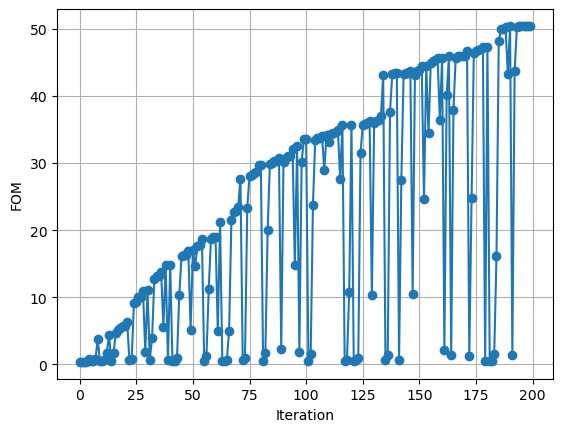

In [10]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

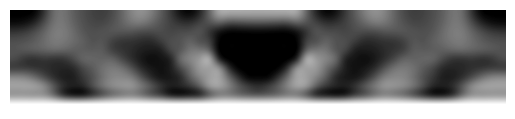

In [11]:
opt.update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

In [12]:
cell_size_pp = mp.Vector3(L + 2*tABS, tPML + tGLS + design_region_height + tITO + tORG + tALU)   
boundary_layers_pp = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

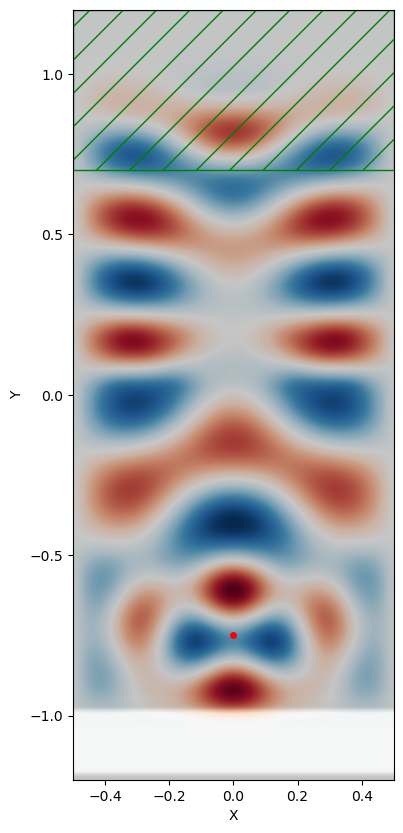

In [32]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

In [33]:
opt.sim.reset_meep()

In [34]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)

In [35]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = 0.05
srcbox_top = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))



<Axes: xlabel='X', ylabel='Y'>

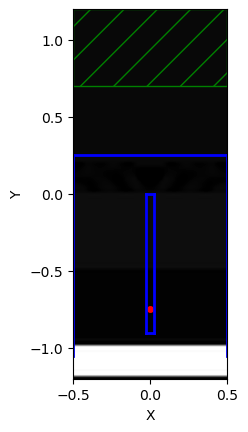

In [36]:
opt.sim.plot2D()

In [37]:
opt.sim.run(until=100.0)

In [38]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)



In [39]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

In [40]:
print(flux_waveguide)

[-2.44061562e-04 -2.34255839e-04 -1.83459243e-04 -7.98001858e-06
  8.33268762e-04 -1.49640515e-02 -3.03279329e-03 -2.71598263e-03
 -2.78960353e-03 -4.14508235e-03 -3.05268536e-03 -3.96225561e-03
 -5.12119881e-03 -7.05056208e-03 -1.15465750e-02 -3.85929890e-02
  2.03157882e-02  7.27307164e-03  4.09190113e-03  2.59557657e-03
  1.98044877e-03  1.54450166e-03  1.26867482e-03  1.08115588e-03
  8.11557348e-04]


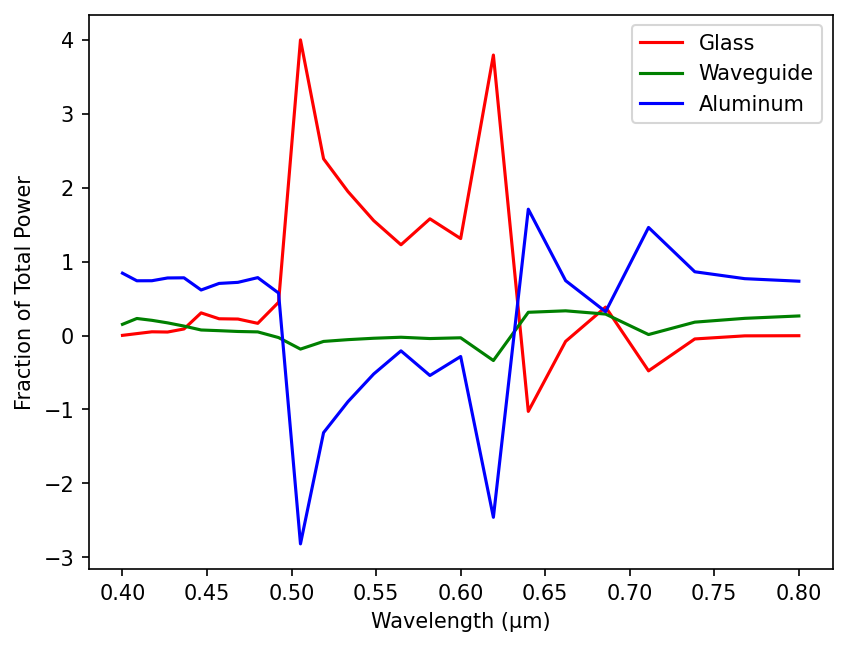

In [41]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    # plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [23]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

In [24]:
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size_pp,
                    boundary_layers=boundary_layers_pp,
                    geometry=geometryo,
                    sources=sources,)

In [25]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = 0.05
srcbox_top = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))


<Axes: xlabel='X', ylabel='Y'>

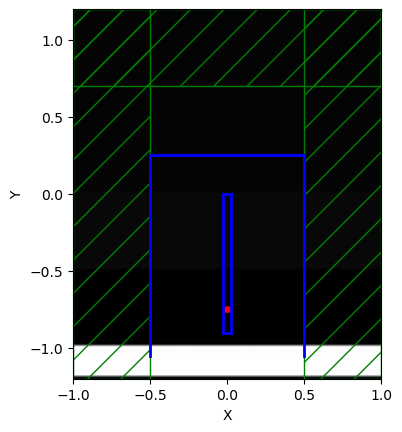

In [26]:
opt.simo.plot2D()

In [27]:
opt.simo.run(until=300.0)

In [28]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)


In [29]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

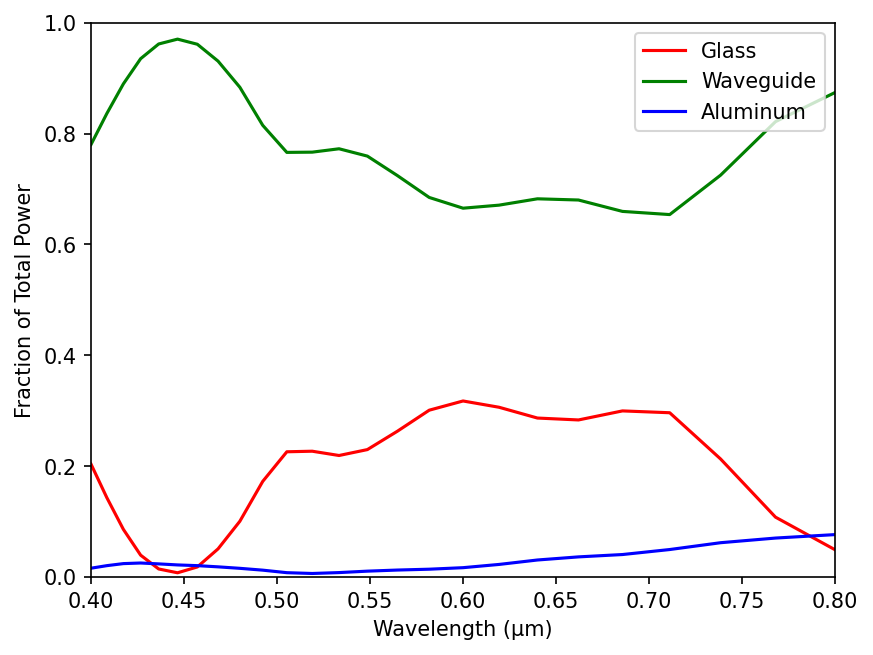

In [30]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

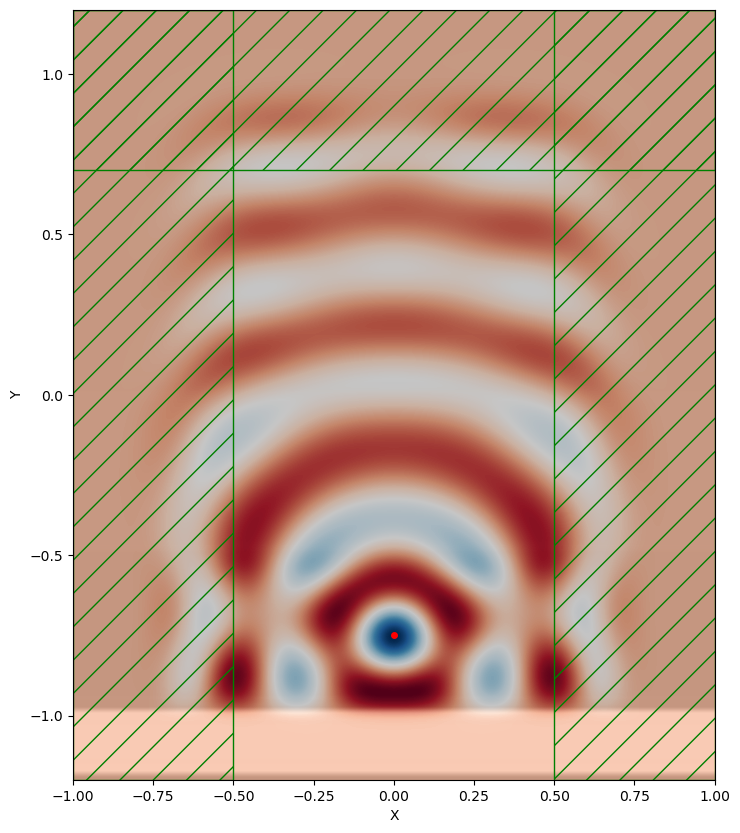

In [31]:
opt.simo.reset_meep()
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size_pp,
                    boundary_layers=boundary_layers_pp,
                    geometry=geometryo,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))]
opt.simo.change_sources(source)

plt.figure(figsize=(16, 10))

opt.simo.run(until=300)
opt.simo.plot2D(fields=mp.Ez)
opt.simo.reset_meep()